In [1]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [2]:
# read zillow data
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df_zillow = pd.read_csv(f).fillna(0)

# read unemployment data
with open('../data/laucnty17.xlsx', 'rb') as f:
    df_labor = pd.read_excel(f, skiprows=range(1, 6)).fillna(0)

# read crime data
with open('../data/district-of-columbia.xls', 'rb') as f:
    df_crime_dc = pd.read_excel(f, skiprows=range(1, 2)).fillna(0)

with open('../data/maryland.xls', 'rb') as f:
    df_crime_md = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/massachusetts.xls', 'rb') as f:
    df_crime_ma = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/virginia.xls', 'rb') as f:
    df_crime_va = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/new-hampshire.xls', 'rb') as f:
    df_crime_nh = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

In [3]:
# crime columns
#dc_col_list = df_crime_dc.iloc[:, 3:12].columns.tolist()
md_col_list = df_crime_md.iloc[:, 3:12].columns.tolist()
ma_col_list = df_crime_ma.iloc[:, 3:12].columns.tolist()
va_col_list = df_crime_va.iloc[:, 3:12].columns.tolist()
nh_col_list = df_crime_nh.iloc[:, 3:12].columns.tolist()

# crime sum: simplified by summing all offense types
#dc_sum = df_crime_dc[dc_col_list].sum(axis=1)
md_sum = df_crime_md[md_col_list].sum(axis=1)
ma_sum = df_crime_ma[ma_col_list].sum(axis=1)
va_sum = df_crime_va[va_col_list].sum(axis=1)
nh_sum = df_crime_nh[nh_col_list].sum(axis=1)

# crime ratio: offense sum / population
df_md = df_crime_md
df_md['City'] = df_crime_md.iloc[:, 0]
df_md['State'] = 'md'
df_md['Population'] = df_crime_md.iloc[:, 1]
df_md['CrimeRatio'] = md_sum/df_crime_md.iloc[:, 1]
df_md = df_crime_md[['City', 'Population', 'CrimeRatio', 'State']]

df_ma = df_crime_ma
df_ma['City'] = df_crime_ma.iloc[:, 0]
df_ma['State'] = 'ma'
df_ma['Population'] = df_crime_ma.iloc[:, 1]
df_ma['CrimeRatio'] = ma_sum/df_crime_ma.iloc[:, 1]
df_ma = df_crime_ma[['City', 'Population', 'CrimeRatio', 'State']]

df_va = df_crime_va
df_va['City'] = df_crime_va.iloc[:, 0]
df_va['State'] = 'va'
df_va['Population'] = df_crime_va.iloc[:, 1]
df_va['CrimeRatio'] = va_sum/df_crime_va.iloc[:, 1]
df_va = df_crime_va[['City', 'Population', 'CrimeRatio', 'State']]

df_nh = df_crime_nh
df_nh['City'] = df_crime_nh.iloc[:, 0]
df_nh['State'] = 'nh'
df_nh['Population'] = df_crime_nh.iloc[:, 1]
df_nh['CrimeRatio'] = nh_sum/df_crime_nh.iloc[:, 1]
df_nh = df_crime_nh[['City', 'Population', 'CrimeRatio', 'State']]

# combine dataframe
df_crime = pd.concat([df_md, df_ma, df_va, df_nh])

# remove unneeded column
df_crime.drop(['Population'], axis=1, inplace=True)

# convert to lowercase
df_crime[['City', 'State']] = df_crime[['City', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

In [4]:
# restructure labor columns
df_labor = pd.DataFrame(df_labor.iloc[:, [3,9]])
df_labor.columns = ['Location', 'Unemployment']
df_labor[['CountyName', 'State']] = df_labor['Location'].str.split(',', expand=True)
df_labor.drop(['Location'], axis=1, inplace=True)

In [5]:
# convert non-timeseries
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
df_zillow[['RegionID', 'RegionName', 'SizeRank']] = df_zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)
df_labor[['CountyName', 'State']] = df_labor[['CountyName', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

# remove redundant suffix
df_labor[['CountyName']] = df_labor['CountyName'].str.rstrip('county').map(lambda x: x.strip())

In [6]:
# arkansas metro areas
hot_springs = df_zillow.loc[(df_zillow['Metro'] == 'hot springs') & (df_zillow['State'] == 'ar')]
little_rock = df_zillow.loc[(df_zillow['Metro'] == 'little rock') & (df_zillow['State'] == 'ar')]
fayetteville = df_zillow.loc[(df_zillow['Metro'] == 'fayetteville') & (df_zillow['State'] == 'ar')]
searcy = df_zillow.loc[(df_zillow['Metro'] == 'searcy') & (df_zillow['State'] == 'ar')]

In [7]:
# merge dataframes
df = pd.merge(df_zillow, df_labor, on=['CountyName', 'State'])
df = pd.merge(df, df_crime, on=['City', 'State'])

# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

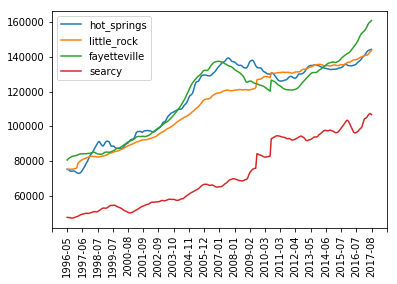

In [8]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [9]:
# remove rows with unemployment >= 3.5%
df = df[df.Unemployment < 3.5]

# remove rows with crime >= 3%
df = df[df.CrimeRatio < 0.03]

# remove redundant columns
df.drop(['Unemployment'], axis=1, inplace=True)
df.drop(['CrimeRatio'], axis=1, inplace=True)

In [10]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [11]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [12]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan).dropna(
    axis=0,
    how='any',
    subset=date_columns
)

In [13]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1992.196
Method:                       css-mle   S.D. of innovations           1006.221
Date:                Sun, 18 Nov 2018   AIC                           3998.391
Time:                        21:41:45   BIC                           4022.726
Sample:                    02-01-1997   HQIC                          4008.197
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1010.1910    484.735      2.084      0.038      60.127    1960.255
ar.L1.D.y      0.7894      0.065     12.235      0.000       0.663       0.916
ar.L2.D.y     -0.0996      0.082     -1.211      0.2

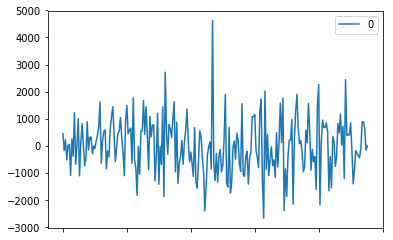

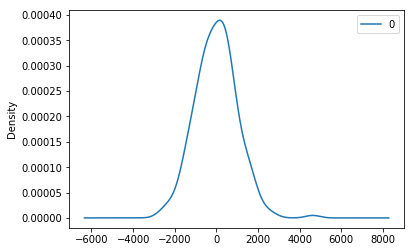

In [14]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [15]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean     -2.069194
std    1008.618450
min   -2682.753851
25%    -675.706720
50%       9.156721
75%     595.122398
max    4625.965351


In [16]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=388813.576701, expected=391050.000000
prediction difference: 0.005719

predicted=388813.576701

date: 2017-3
-----------------------------------------------
predicted=390443.689396, expected=392900.000000
prediction difference: 0.006252

predicted=390443.689396

date: 2017-4
-----------------------------------------------
predicted=392003.290988, expected=395800.000000
prediction difference: 0.009592

predicted=392003.290988

date: 2017-5
-----------------------------------------------
predicted=393503.316512, expected=398850.000000
prediction difference: 0.013405

predicted=393503.316512

date: 2017-6
-----------------------------------------------
predicted=394958.772728, expected=400850.000000
prediction difference: 0.014697

predicted=394958.772728

date: 2017-7
-----------------------------------------------
predicted=396374.708561, expected=402250.000000
prediction difference: 0.014606

predicted=396374.70856

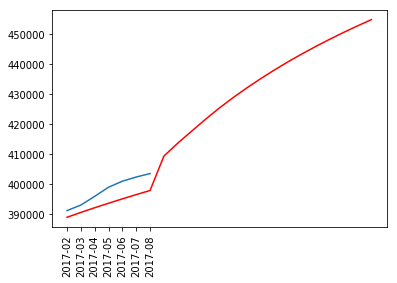

In [17]:
# plot rolling prediction
def rolling_plot(data, predictions):
    plt.plot(data)
    plt.plot(predictions, color='red')
    plt.xticks(rotation=90)
    plt.show()

rolling_plot(df_test, predictions)

In [18]:
# stationarity test
def difference(dataset, delta):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - delta]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def compute_arima(
    df_train,
    p=5,
    q=0,
    d=0,
    iterations=len(df_test),
    alpha=0.05
):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in df_train]
    predictions = list()

    for t in range(iterations):
        delta = 1
        model_fit = False

        # generate model
        try:
            model = ARIMA(history, order=(p,q,d))
            model_fit = model.fit(disp=0)
            print('standard fit used')
        except Exception as e:
            print('stationary differences will be used')
            print('original error: {}'.format(e))

        # significant stationarity: use any that works
        if not model_fit:
            #
            # determine stationarity value: differencing handled with supplied data,
            #     as an indirect solution, since statsmodel not allow d > 2.
            #
            # @delta, autoregressive factor.
            #
            for delta in range(10):
                stationary = difference(history, delta)
                stationary.index = history[1:]
                result = adfuller(stationary)
                print('stationary fit: {}, p: {}'.format(delta, result[1]))

                #
                # generate model: use high (10) autoregression, since data is not
                #     seasonal. Therefore, using previous values is conservative.
                #
                if (result[1] <= 0.05):
                    try:
                        model = ARIMA(stationary, order=(p,q,d))
                        model_fit = model.fit(disp=0)
                        break
                    except Exception as e:
                        print('bad condition {}: stationarity not adequate'.format(delta))
                        print('original error: {}'.format(e))
                        continue

        #
        # generate forecast: an inverse difference is needed to reverse the earlier
        #     difference model scaling.
        #
        if model_fit:
            output = model_fit.forecast(alpha=alpha)
            print(output)
            yhat = inverse_difference(history, output[0], delta)

            #
            # observation: if current value doesn't exist from test, append current
            #     predition, to ensure successive rolling prediction computed.
            #
            try:
                obs = df_test[t]
            except:
                obs = yhat
            history.append(obs)
            predictions.append(yhat)
        else:
            predictions.append(None)
            break

        print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [19]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

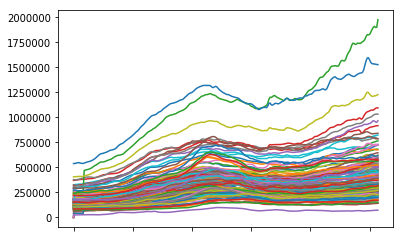

In [20]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [21]:
# iterate columns
results = []
for column in df_zipcode_clean:
    predictions = compute_arima(df_zipcode_clean[column], p=5)
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

standard fit used
(array([343874.31270325]), array([946.83701391]), array([[342018.54625677, 345730.07914974]]))
predictions: [array([686874.31270325])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in le

stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8768240199863697
stationary fit: 2, p: 0.8828024790581743
stationary fit: 3, p: 0.039179355794582676
(array([41898.00143301]), array([15743.29167743]), array([[11041.71674714, 72754.28611888]]))
predictions: [array([686874.31270325]), array([382998.00143301])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.15158606647269718
stationary fit: 2, p: 0.0018426601523951897


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([21830.71951544]), array([15740.62371341]), array([[-9020.33605703, 52681.77508791]]))
predictions: [array([686874.31270325]), array([382998.00143301]), array([412880.71951544])]
standard fit used
(array([400960.48924153]), array([3348.15756487]), array([[394398.22099982, 407522.75748324]]))
predictions: [array([686874.31270325]), array([382998.00143301]), array([412880.71951544]), array([796760.48924153])]
standard fit used
(array([411532.86446597]), array([3342.08977468]), array([[404982.48887449, 418083.24005745]]))
predictions: [array([686874.31270325]), array([382998.00143301]), array([412880.71951544]), array([796760.48924153]), array([810382.86446597])]
standard fit used
(array([401970.57684737]), array([3355.47534931]), array([[395393.9660117 , 408547.18768304]]))
predictions: [array([686874.31270325]), array([382998.00143301]), array([412880.71951544]), array([796760.48924153]), array([810382.86446597]), array([802820.57684737])]
standard fit used
(array([403194.0506193

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([237573.54939457]), array([564.31165121]), array([[236467.51888213, 238679.579907  ]]))
predictions: [array([475373.54939457])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.4558473736448858
stationary fit: 2, p: 0.23274885370376386
stationary fit: 3, p: 0.4033439268825675
stationary fit: 4, p: 4.23375524590364e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([69202.37132928]), array([19834.55981769]), array([[ 30327.34843741, 108077.39422115]]))
predictions: [array([475373.54939457]), array([308502.37132928])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.0199842297079028e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([35422.18232146]), array([9489.30234486]), array([[16823.49148711, 54020.8731558 ]]))
predictions: [array([475373.54939457]), array([308502.37132928]), array([428322.18232146])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 9.470413498841611e-29
bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 8.497942050335637e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:632: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 0.9041293291271675
stationary fit: 4, p: 0.9516730394930468
stationary fit: 5, p: 1.7621133261774645e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([75879.0603684]), array([19945.46452309]), array([[ 36786.66824822, 114971.45248857]]))
predictions: [array([475373.54939457]), array([308502.37132928]), array([428322.18232146]), array([314079.0603684])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([476280.43456505]), array([9528.43819165]), array([[457605.03888051, 494955.8302496 ]]))
predictions: [array([475373.54939457]), array([308502.37132928]), array([428322.18232146]), array([314079.0603684]), array([875130.43456505])]
standard fit used
(array([400284.20352094]), array([9546.38659471]), array([[381573.62961281, 418994.77742907]]))
predictions: [array([475373.54939457]), array([308502.37132928]), array([428322.18232146]), array([314079.0603684]), array([875130.43456505]), array([801134.20352094])]
standard fit used
(array([401688.75784368]), array([9528.47721247]), array([[383013.28567973, 420364.23000763]]))
predictions: [array([475373.54939457]), array([308502.37132928]), array([428322.18232146]), array([314079.0603684]), array([875130.43456505]), array([801134.20352094]), array([803938.75784368])]
standard fit used
(array([312286.36481163]), array([1324.27136189]), array([[309690.84063657, 314881.8889867 ]]))
predictions: [array([625086.36481163]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([495510.48018149]), array([5055.12997191]), array([[485602.60749936, 505418.35286361]]))
predictions: [array([625086.36481163]), array([886560.48018149])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 7.226524064961006e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.31631541291382503
stationary fit: 3, p: 0.05877839971743285
stationary fit: 4, p: 0.24320648745831142
stationary fit: 5, p: 0.003531379559904771


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([58059.93184512]), array([16832.62401882]), array([[25068.59500293, 91051.2686873 ]]))
predictions: [array([625086.36481163]), array([886560.48018149]), array([370159.93184512])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([403666.65138824]), array([5375.44481555]), array([[393130.97314887, 414202.3296276 ]]))
predictions: [array([625086.36481163]), array([886560.48018149]), array([370159.93184512]), array([799466.65138824])]
standard fit used
(array([399729.94143795]), array([5366.43207133]), array([[389211.92785267, 410247.95502324]]))
predictions: [array([625086.36481163]), array([886560.48018149]), array([370159.93184512]), array([799466.65138824]), array([798579.94143795])]
standard fit used
(array([401359.03109429]), array([5356.1924428]), array([[390861.08681214, 411856.97537644]]))
predictions: [array([625086.36481163]), array([886560.48018149]), array([370159.93184512]), array([799466.65138824]), array([798579.94143795]), array([802209.03109429])]
standard fit used
(array([402589.21036391]), array([5346.16546953]), array([[392110.91858825, 413067.50213958]]))
predictions: [array([625086.36481163]), array([886560.48018149]), array([370159.93184512]), array([799466.6513882

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([297415.77876843]), array([920.23093577]), array([[295612.15927686, 299219.39826   ]]))
predictions: [array([595215.77876843])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.5408066111239609
stationary fit: 2, p: 0.11587310549638818
stationary fit: 3, p: 0.5307484047072955
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([62174.96322974]), array([17047.98869154]), array([[28761.51938547, 95588.40707401]]))
predictions: [array([595215.77876843]), array([359474.96322974])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.6918931108643536
stationary fit: 2, p: 0.3253846102884248
stationary fit: 3, p: 0.8028715171333994
stationary fit: 4, p: 0.8816541583369674
stationary fit: 5, p: 4.056187359263081e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([62962.97385889]), array([17087.68578905]), array([[29471.72513322, 96454.22258456]]))
predictions: [array([595215.77876843]), array([359474.96322974]), array([360262.97385889])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.087612597548957e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-8387.37644949]), array([5892.35146191]), array([[-19936.17309908,   3161.42020011]]))
predictions: [array([595215.77876843]), array([359474.96322974]), array([360262.97385889]), array([387412.62355051])]
standard fit used
(array([450903.9848719]), array([5927.17444536]), array([[439286.93642891, 462521.0333149 ]]))
predictions: [array([595215.77876843]), array([359474.96322974]), array([360262.97385889]), array([387412.62355051]), array([849753.9848719])]
standard fit used
(array([401132.94491146]), array([5995.54274101]), array([[389381.89707131, 412883.99275162]]))
predictions: [array([595215.77876843]), array([359474.96322974]), array([360262.97385889]), array([387412.62355051]), array([849753.9848719]), array([801982.94491146])]
standard fit used
(array([402503.47639151]), array([5984.34132448]), array([[390774.38292433, 414232.56985869]]))
predictions: [array([595215.77876843]), array([359474.96322974]), array([360262.97385889]), array([387412.62355051]), array([849753.98

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([225824.47457597]), array([572.24274009]), array([[224702.89941498, 226946.04973696]]))
predictions: [array([451724.47457597])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7914057663659043
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 7.378200585890994e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([69668.26631112]), array([20517.31028957]), array([[ 29455.07708394, 109881.45553831]]))
predictions: [array([451724.47457597]), array([295768.26631112])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.0876574018979374e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.9381771945055973
stationary fit: 3, p: 1.4019769553286292e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([55904.83883522]), array([20552.91602416]), array([[15621.8636506 , 96187.81401984]]))
predictions: [array([451724.47457597]), array([295768.26631112]), array([281804.83883522])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.0086561475680359e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-54904.92241464]), array([10259.22881809]), array([[-75012.64140726, -34797.20342202]]))
predictions: [array([451724.47457597]), array([295768.26631112]), array([281804.83883522]), array([340895.07758536])]
standard fit used
(array([434385.87398212]), array([10286.47054175]), array([[414224.76219226, 454546.98577198]]))
predictions: [array([451724.47457597]), array([295768.26631112]), array([281804.83883522]), array([340895.07758536]), array([833235.87398212])]
standard fit used
(array([400063.7304315]), array([10282.02630634]), array([[379911.32918298, 420216.13168002]]))
predictions: [array([451724.47457597]), array([295768.26631112]), array([281804.83883522]), array([340895.07758536]), array([833235.87398212]), array([800913.7304315])]
standard fit used
(array([401475.4643308]), array([10262.65823881]), array([[381361.0237971 , 421589.90486451]]))
predictions: [array([451724.47457597]), array([295768.26631112]), array([281804.83883522]), array([340895.07758536]), array([8332

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([208801.35543155]), array([687.49718857]), array([[207453.88570247, 210148.82516063]]))
predictions: [array([418001.35543155])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([661652.7826835]), array([11606.67108198]), array([[638904.12538241, 684401.43998459]]))
predictions: [array([418001.35543155]), array([1052702.7826835])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([354111.27115869]), array([11348.79889171]), array([[331868.03406316, 376354.50825422]]))
predictions: [array([418001.35543155]), array([1052702.7826835]), array([747011.27115869])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 7.550165497046469e-29
(array([-7414.44958581]), array([11296.37354357]), array([[-29554.93488711,  14726.03571549]]))
predictions: [array([418001.35543155]), array([1052702.7826835]), array([747011.27115869]), array([388385.55041419])]
standard fit used
(array([404586.78946866]), array([11327.96909422]), array([[382384.37802602, 426789.20091131]]))
predictions: [array([418001.35543155]), array([1052702.7826835]), array([747011.27115869]), array([388385.55041419]), array([803436.78946866])]
standard fit used
(array([399729.33426588]), array([11306.86888798]), array([[377568.27846753, 421890.39006424]]))
predictions: [array([418001.35543155]), array([1052702.7826835

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([286784.95928537]), array([860.92106339]), array([[285097.5850076 , 288472.33356315]]))
predictions: [array([574384.95928537])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.6006188461234814
stationary fit: 2, p: 0.47555320672308604
stationary fit: 3, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 0.14759570738936384
stationary fit: 5, p: 0.47101306094814827
stationary fit: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([59376.45389929]), array([17329.61783852]), array([[25411.02706995, 93341.88072863]]))
predictions: [array([574384.95928537]), array([349476.45389929])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([435706.37978474]), array([6586.15197069]), array([[422797.75912549, 448615.00044399]]))
predictions: [array([574384.95928537]), array([349476.45389929]), array([828606.37978474])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 7.804614161097689e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.004214497394939105


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-16368.02284416]), array([17450.45613505]), array([[-50570.28838266,  17834.24269433]]))
predictions: [array([574384.95928537]), array([349476.45389929]), array([828606.37978474]), array([376531.97715584])]
standard fit used
(array([402381.052889]), array([6646.46000818]), array([[389354.23064829, 415407.87512972]]))
predictions: [array([574384.95928537]), array([349476.45389929]), array([828606.37978474]), array([376531.97715584]), array([801231.05288901])]
standard fit used
(array([401003.79082934]), array([6633.99703705]), array([[388001.39556318, 414006.1860955 ]]))
predictions: [array([574384.95928537]), array([349476.45389929]), array([828606.37978474]), array([376531.97715584]), array([801231.05288901]), array([801853.79082934])]
standard fit used
(array([402326.07660786]), array([6621.59721087]), array([[389347.98455442, 415304.1686613 ]]))
predictions: [array([574384.95928537]), array([349476.45389929]), array([828606.37978474]), array([376531.97715584]), array([801231

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([259777.63233899]), array([4520.98322109]), array([[250916.66805094, 268638.59662703]]))
predictions: [array([926074.73590608]), array([650827.63233899])]
standard fit used
(array([355645.48111833]), array([4745.09859604]), array([[346345.25876701, 364945.70346965]]))
predictions: [array([926074.73590608]), array([650827.63233899]), array([748545.48111833])]
standard fit used
(array([367414.40307145]), array([4779.87221824]), array([[358046.02567298, 376782.78046991]]))
predictions: [array([926074.73590608]), array([650827.63233899]), array([748545.48111833]), array([763214.40307145])]
standard fit used
(array([363075.00805474]), array([4790.65727761]), array([[353685.49232835, 372464.52378114]]))
predictions: [array([926074.73590608]), array([650827.63233899]), array([748545.48111833]), array([763214.40307145]), array([761925.00805474])]
standard fit used
(array([401527.89823191]), array([4879.90490163]), array([[391963.46037674, 411092.33608709]]))
prediction

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([391319.267716]), array([507.8571524]), array([[390323.885988  , 392314.64944399]]))
predictions: [array([782069.26771599])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([390888.99567516]), array([506.90060145]), array([[389895.48875257, 391882.50259775]]))
predictions: [array([782069.26771599]), array([781938.99567516])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([396164.19260752]), array([520.01315094]), array([[395144.98556019, 397183.39965486]]))
predictions: [array([782069.26771599]), array([781938.99567516]), array([789064.19260752])]
standard fit used
(array([397971.97318234]), array([519.2305005]), array([[396954.3001017 , 398989.64626299]]))
predictions: [array([782069.26771599]), array([781938.99567516]), array([789064.19260752]), array([793771.97318234])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([401517.93510621]), array([520.85210758]), array([[400497.08373408, 402538.78647833]]))
predictions: [array([782069.26771599]), array([781938.99567516]), array([789064.19260752]), array([793771.97318234]), array([800367.93510621])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([402065.01378088]), array([522.09713467]), array([[401041.72220049, 403088.30536126]]))
predictions: [array([782069.26771599]), array([781938.99567516]), array([789064.19260752]), array([793771.97318234]), array([800367.93510621]), array([802915.01378088])]
standard fit used
(array([403823.55731221]), array([520.9345501]), array([[402802.54435571, 404844.57026872]]))
predictions: [array([782069.26771599]), array([781938.99567516]), array([789064.19260752]), array([793771.97318234]), array([800367.93510621]), array([802915.01378088]), array([806073.55731221])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([589236.36451888]), array([1027.88308446]), array([[587221.75069302, 591250.97834474]]))
predictions: [array([1182936.36451888])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([113662.4903586]), array([13168.58233748]), array([[ 87852.5432497 , 139472.43746751]]))
predictions: [array([1182936.36451888]), array([504712.4903586])]
standard fit used
(array([186341.7526766]), array([12445.86760818]), array([[161948.30040821, 210735.20494498]]))
predictions: [array([1182936.36451888]), array([504712.4903586]), array([579241.7526766])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([228962.26506844]), array([12645.19825136]), array([[204178.1319184 , 253746.39821848]]))
predictions: [array([1182936.36451888]), array([504712.4903586]), array([579241.7526766]), array([624762.26506844])]
standard fit used
(array([315311.24683249]), array([12725.97634097]), array([[290368.79153609, 340253.70212889]]))
predictions: [array([1182936.36451888]), array([504712.4903586]), array([579241.7526766]), array([624762.26506844]), array([714161.24683249])]
standard fit used
(array([401616.83427732]), array([12782.74850763]), array([[376563.10757894, 426670.5609757 ]]))
predictions: [array([1182936.36451888]), array([504712.4903586]), array([579241.7526766]), array([624762.26506844]), array([714161.24683249]), array([802466.83427732])]
standard fit used
(array([402950.89248253]), array([12758.50822064]), array([[377944.67587362, 427957.10909144]]))
predictions: [array([1182936.36451888]), array([504712.4903586]), array([579241.7526766]), array([624762.265068

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([436442.12817651]), array([969.21072139]), array([[434542.51006915, 438341.74628386]]))
predictions: [array([871042.12817651])]
standard fit used
(array([321377.45145483]), array([2953.24338804]), array([[315589.20077669, 327165.70213296]]))
predictions: [array([871042.12817651]), array([712427.45145483])]
standard fit used
(array([373826.99331836]), array([3304.4567498]), array([[367350.37710028, 380303.60953644]]))
predictions: [array([871042.12817651]), array([712427.45145483]), array([766726.99331836])]
standard fit used
(array([377921.70010225]), array([3331.17658169]), array([[371392.713976  , 384450.68622849]]))
predictions: [array([871042.12817651]), array([712427.45145483]), array([766726.99331836]), array([773721.70010224])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([388500.54160904]), array([3359.153706]), array([[381916.72132674, 395084.36189134]]))
predictions: [array([871042.12817651]), array([712427.45145483]), array([766726.99331836]), array([773721.70010224]), array([787350.54160904])]
standard fit used
(array([402054.06393079]), array([3381.80914427]), array([[395425.83980543, 408682.28805615]]))
predictions: [array([871042.12817651]), array([712427.45145483]), array([766726.99331836]), array([773721.70010224]), array([787350.54160904]), array([802904.06393079])]
standard fit used
(array([403264.79556749]), array([3375.38810649]), array([[396649.15644493, 409880.43469005]]))
predictions: [array([871042.12817651]), array([712427.45145483]), array([766726.99331836]), array([773721.70010224]), array([787350.54160904]), array([802904.06393079]), array([805514.79556749])]
standard fit used
(array([679962.48259016]), array([1230.76353919]), array([[677550.23037986, 682374.73480046]]))
predictions: [array([1359662.4825901

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 1.4281659075797083e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-456561.1510404]), array([24851.32705607]), array([[-505268.85703831, -407853.44504248]]))
predictions: [array([1359662.48259016]), array([219138.8489596])]
standard fit used
(array([158794.36841195]), array([17963.57754735]), array([[123586.40338565, 194002.33343824]]))
predictions: [array([1359662.48259016]), array([219138.8489596]), array([551694.36841195])]
standard fit used
(array([336860.91840579]), array([18115.82875399]), array([[301354.54649787, 372367.29031371]]))
predictions: [array([1359662.48259016]), array([219138.8489596]), array([551694.36841195]), array([732660.91840579])]
standard fit used
(array([356915.17317825]), array([18094.47511206]), array([[321450.65363947, 392379.69271704]]))
predictions: [array([1359662.48259016]), array([219138.8489596]), array([551694.36841195]), array([732660.91840579]), array([755765.17317825])]
standard fit used
(array([401853.05564831]), array([18072.04791989]), array([[366432.49259845, 437273.61869817]]))
predictions: [array([

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([914466.70688229]), array([1888.97932216]), array([[910764.37544332, 918169.03832127]]))
predictions: [array([1828866.70688229])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([-521393.53533786]), array([32453.5796914]), array([[-585001.3827024 , -457785.68797331]]))
predictions: [array([1828866.70688229]), array([-130343.53533786])]
standard fit used
(array([224328.67373762]), array([32663.83495523]), array([[160308.73362841, 288348.61384683]]))
predictions: [array([1828866.70688229]), array([-130343.53533786]), array([617228.67373762])]
standard fit used
(array([336935.47602251]), array([32653.75273414]), array([[272935.29670352, 400935.65534149]]))
predictions: [array([1828866.70688229]), array([-130343.53533786]), array([617228.67373762]), array([732735.47602251])]
standard fit used
(array([331933.33672631]), array([32598.11888141]), array([[268042.197755  , 395824.47569762]]))
predictions: [array([1828866.70688229]), array([-130343.53533786]), array([617228.67373762]), array([732735.47602251]), array([730783.33672631])]
standard fit used
(array([405967.61270068]), array([32553.00102148]), array([[342164.90310988, 469770.32229148

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([443069.72743252]), array([817.96790556]), array([[441466.53979711, 444672.91506793]]))
predictions: [array([885569.72743252])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([310669.06752721]), array([3310.55778879]), array([[304180.49349243, 317157.64156198]]))
predictions: [array([885569.72743252]), array([701719.06752721])]
standard fit used
(array([376468.67550445]), array([3565.88396]), array([[369479.67136981, 383457.67963909]]))
predictions: [array([885569.72743252]), array([701719.06752721]), array([769368.67550445])]
standard fit used
(array([371372.78466152]), array([3575.00092255]), array([[364365.91160864, 378379.65771441]]))
predictions: [array([885569.72743252]), array([701719.06752721]), array([769368.67550445]), array([767172.78466152])]
standard fit used
(array([374788.74848591]), array([3604.94457698]), array([[367723.18694877, 381854.31002304]]))
predictions: [array([885569.72743252]), array([701719.06752721]), array([769368.67550445]), array([767172.78466152]), array([773638.74848591])]
standard fit used
(array([401876.7081653]), array([3684.47966817]), array([[394655.26071391, 409098.15561668]]))
predictions: [

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([378236.11789693]), array([708.57169181]), array([[376847.34290051, 379624.89289334]]))
predictions: [array([754836.11789693])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7441841908474192
stationary fit: 2, p: 0.8185237957146154
stationary fit: 3, p: 0.5756905361196067
stationary fit: 4, p: 0.8248549647885846
stationary fit: 5, p: 0.48735137884474533
stationary fit: 6, p: 0.7587812172723044
stationary fit: 7, p: 0.6062555737182862
stationary fit: 8, p: 0.22979451300700465
stationary fit: 9, p: 0.9071083131314459
standard fit used
(array([562301.80523742]), array([990.54202334]), array([[560360.3785465 , 564243.23192834]]))
predictions: [array([1124401.80523742])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9527805406786224
stationary fit: 2, p: 0.907844633785891
stationary fit: 3, p: 9.191047757485448e-20

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-313370.89418206]), array([16614.87925173]), array([[-345935.45912292, -280806.32924119]]))
predictions: [array([1124401.80523742]), array([248329.10581794])]
standard fit used
(array([285357.66133116]), array([10794.22189605]), array([[264201.37517376, 306513.94748855]]))
predictions: [array([1124401.80523742]), array([248329.10581794]), array([678257.66133116])]
standard fit used
(array([327343.17543434]), array([10845.88537517]), array([[306085.63071856, 348600.72015013]]))
predictions: [array([1124401.80523742]), array([248329.10581794]), array([678257.66133116]), array([723143.17543434])]
standard fit used
(array([345318.75021873]), array([10860.0279542]), array([[324033.48655739, 366604.01388006]]))
predictions: [array([1124401.80523742]), array([248329.10581794]), array([678257.66133116]), array([723143.17543434]), array([744168.75021873])]
standard fit used
(array([400973.48790858]), array([10879.94390045]), array([[379649.18970988, 422297.78610728]]))
predictions: [arr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([782091.69642894]), array([1970.28145883]), array([[778230.01573022, 785953.37712766]]))
predictions: [array([1567291.69642894])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9795476306613029
stationary fit: 2, p: 0.9719570836303891
stationary fit: 3, p: 0.9963579103653385
stationary fit: 4, p: 0.9770841951647421
stationary fit: 5, p: 0.9550865305359437
stationary fit: 6, p: 0.9621396976318092
stationary fit: 7, p: 2.3968416641059156e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-425497.8918902]), array([34867.3516081]), array([[-493836.64527836, -357159.13850204]]))
predictions: [array([1567291.69642894]), array([361502.1081098])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([-36896.3307868]), array([24250.69290966]), array([[-84426.81548988,  10634.15391627]]))
predictions: [array([1567291.69642894]), array([361502.1081098]), array([356003.6692132])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([137979.35183561]), array([24555.15821836]), array([[ 89852.12609294, 186106.57757828]]))
predictions: [array([1567291.69642894]), array([361502.1081098]), array([356003.6692132]), array([533779.35183561])]
standard fit used
(array([401293.19954625]), array([24720.68074414]), array([[352841.55561442, 449744.84347807]]))
predictions: [array([1567291.69642894]), array([361502.1081098]), array([356003.6692132]), array([533779.35183561]), array([800143.19954625])]
standard fit used
(array([404134.01162451]), array([24673.00092077]), array([[355775.81842928, 452492.20481973]]))
predictions: [array([1567291.69642894]), array([361502.1081098]), array([356003.6692132]), array([533779.35183561]), array([800143.19954625]), array([804984.01162451])]
standard fit used
(array([405446.36545613]), array([24625.5705722]), array([[357181.13403587, 453711.59687638]]))
predictions: [array([1567291.69642894]), array([361502.1081098]), array([356003.6692132]), array([533779.3518356

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([510319.86969085]), array([918.87346478]), array([[508518.91079354, 512120.82858816]]))
predictions: [array([1021419.86969085])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9679346765067309
stationary fit: 2, p: 0.9113241548753468
stationary fit: 3, p: 0.9199043706486972
stationary fit: 4, p: 0.9004161425332844
stationary fit: 5, p: 1.7888788127859866e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-207445.34470514]), array([12817.33656042]), array([[-232566.8627413 , -182323.82666899]]))
predictions: [array([1021419.86969085]), array([303854.65529486])]
standard fit used
(array([292440.68730704]), array([7625.91483154]), array([[277494.16888806, 307387.20572602]]))
predictions: [array([1021419.86969085]), array([303854.65529486]), array([685340.68730704])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([304588.4405701]), array([7768.23349381]), array([[289362.98269874, 319813.89844147]]))
predictions: [array([1021419.86969085]), array([303854.65529486]), array([685340.68730704]), array([700388.4405701])]
standard fit used
(array([364298.34183046]), array([7791.68075193]), array([[349026.92817764, 379569.75548328]]))
predictions: [array([1021419.86969085]), array([303854.65529486]), array([685340.68730704]), array([700388.4405701]), array([763148.34183046])]
standard fit used
(array([401309.53206046]), array([7814.2394227]), array([[385993.90422539, 416625.15989553]]))
predictions: [array([1021419.86969085]), array([303854.65529486]), array([685340.68730704]), array([700388.4405701]), array([763148.34183046]), array([802159.53206046])]
standard fit used
(array([402623.89154198]), array([7799.61180589]), array([[387336.93330905, 417910.84977492]]))
predictions: [array([1021419.86969085]), array([303854.65529486]), array([685340.68730704]), array([700388.4405701

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([726790.38473984]), array([1464.04535975]), array([[723920.908563  , 729659.86091668]]))
predictions: [array([1452890.38473984])]
standard fit used
(array([108054.70344364]), array([20900.11810178]), array([[ 67091.22469151, 149018.18219577]]))
predictions: [array([1452890.38473984]), array([499104.70344364])]
standard fit used
(array([291701.21385269]), array([20975.69390811]), array([[250589.60924206, 332812.81846332]]))
predictions: [array([1452890.38473984]), array([499104.70344364]), array([684601.21385269])]
standard fit used
(array([307687.16837644]), array([20961.47722309]), array([[266603.42795643, 348770.90879645]]))
predictions: [array([1452890.38473984]), array([499104.70344364]), array([684601.21385269]), array([703487.16837644])]
standard fit used
(array([301861.00314767]), array([20944.40494255]), array([[260810.72378264, 342911.2825127 ]]))
predictions: [array([1452890.38473984]), array([499104.70344364]), array([684601.21385269]), array([703487

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([723546.81813744]), array([1338.72663747]), array([[720922.96214285, 726170.67413203]]))
predictions: [array([1444646.81813744])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7368551954590912
stationary fit: 2, p: 0.5580818038267911
stationary fit: 3, p: 0.3932740435959216
stationary fit: 4, p: 2.0753810081655437e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 4.302679110440197e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 5: stationarity not adequate
original error: SVD did not converge
stationary fit: 6, p: 0.5338014230844005
stationary fit: 7, p: 9.081285122878398e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-405663.47727189]), array([29310.41685526]), array([[-463110.83868006, -348216.11586372]]))
predictions: [array([1444646.81813744]), array([291036.52272811])]
standard fit used
(array([330679.99396924]), array([20726.25218859]), array([[290057.28614511, 371302.70179336]]))
predictions: [array([1444646.81813744]), array([291036.52272811]), array([723579.99396924])]
standard fit used
(array([339764.15001364]), array([20694.66279911]), array([[299203.35625518, 380324.94377209]]))
predictions: [array([1444646.81813744]), array([291036.52272811]), array([723579.99396924]), array([735564.15001364])]
standard fit used
(array([373193.47443633]), array([20666.4890754]), array([[332687.90016165, 413699.04871101]]))
predictions: [array([1444646.81813744]), array([291036.52272811]), array([723579.99396924]), array([735564.15001364]), array([772043.47443633])]
standard fit used
(array([402417.0311197]), array([20631.26245288]), array([[361980.49975645, 442853.56248294]]))
predictions: [arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([460768.4883275]), array([787.53982817]), array([[459224.9386279 , 462312.03802709]]))
predictions: [array([920868.4883275])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([262537.48561948]), array([4419.03327533]), array([[253876.33955334, 271198.63168562]]))
predictions: [array([920868.4883275]), array([653587.48561948])]
standard fit used
(array([345714.38763268]), array([4624.15380492]), array([[336651.21271606, 354777.56254931]]))
predictions: [array([920868.4883275]), array([653587.48561948]), array([738614.38763268])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([338157.78058268]), array([4697.60928304]), array([[328950.63557449, 347364.92559087]]))
predictions: [array([920868.4883275]), array([653587.48561948]), array([738614.38763268]), array([733957.78058268])]
standard fit used
(array([379020.42691863]), array([4730.40698808]), array([[369748.99958977, 388291.85424748]]))
predictions: [array([920868.4883275]), array([653587.48561948]), array([738614.38763268]), array([733957.78058268]), array([777870.42691863])]
standard fit used
(array([401492.93960188]), array([4756.79208567]), array([[392169.79843203, 410816.08077174]]))
predictions: [array([920868.4883275]), array([653587.48561948]), array([738614.38763268]), array([733957.78058268]), array([777870.42691863]), array([802342.93960188])]
standard fit used
(array([402773.59875263]), array([4747.92794661]), array([[393467.83097609, 412079.36652918]]))
predictions: [array([920868.4883275]), array([653587.48561948]), array([738614.38763268]), array([733957.78058268])

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([424456.18241498]), array([550.12190228]), array([[423377.96329942, 425534.40153055]]))
predictions: [array([847756.18241498])]
standard fit used
(array([325243.89865315]), array([2131.18129572]), array([[321066.86006901, 329420.93723729]]))
predictions: [array([847756.18241498]), array([716293.89865315])]
standard fit used
(array([373453.25164288]), array([2435.95132081]), array([[368678.874786  , 378227.62849976]]))
predictions: [array([847756.18241498]), array([716293.89865315]), array([766353.25164288])]
standard fit used
(array([385735.6238023]), array([2490.25367656]), array([[380854.81628388, 390616.43132073]]))
predictions: [array([847756.18241498]), array([716293.89865315]), array([766353.25164288]), array([781535.6238023])]
standard fit used
(array([387421.43987613]), array([2498.40576243]), array([[382524.65456301, 392318.22518926]]))
predictions: [array([847756.18241498]), array([716293.89865315]), array([766353.25164288]), array([781535.6238023]), 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([396605.66120184]), array([538.98030946]), array([[395549.27920693, 397662.04319676]]))
predictions: [array([792855.66120184])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([382229.05138569]), array([637.19438907]), array([[380980.17333196, 383477.92943942]]))
predictions: [array([792855.66120184]), array([773279.05138569])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([397778.11685699]), array([845.2873548]), array([[396121.38408499, 399434.84962899]]))
predictions: [array([792855.66120184]), array([773279.05138569]), array([790678.11685699])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([396730.98400655]), array([847.55714226]), array([[395069.80253288, 398392.16548021]]))
predictions: [array([792855.66120184]), array([773279.05138569]), array([790678.11685699]), array([792530.98400655])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([400576.61371741]), array([851.68400161]), array([[398907.34374805, 402245.88368678]]))
predictions: [array([792855.66120184]), array([773279.05138569]), array([790678.11685699]), array([792530.98400655]), array([799426.61371741])]
standard fit used
(array([402441.13959911]), array([850.18680551]), array([[400774.80408017, 404107.47511805]]))
predictions: [array([792855.66120184]), array([773279.05138569]), array([790678.11685699]), array([792530.98400655]), array([799426.61371741]), array([803291.13959911])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([403649.56201613]), array([848.10783732]), array([[401987.30119997, 405311.8228323 ]]))
predictions: [array([792855.66120184]), array([773279.05138569]), array([790678.11685699]), array([792530.98400655]), array([799426.61371741]), array([803291.13959911]), array([805899.56201613])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([335083.99607404]), array([522.02554142]), array([[334060.84481385, 336107.14733423]]))
predictions: [array([670183.99607404])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9835308437232122
stationary fit: 2, p: 0.936315090971774
stationary fit: 3, p: 0.29574336003585033
stationary fit: 4, p: 0.0
(array([47365.23236529]), array([16969.13188038]), array([[14106.34503084, 80624.11969974]]))
predictions: [array([670183.99607404]), array([381065.23236529])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9528562826418087
stationary fit: 2, p: 0.9043657963230292
stationary fit: 3, p: 0.9399746106310333
stationary fit: 4, p: 0.3101146941899212
stationary fit: 5, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([47932.35287666]), array([17035.05189976]), array([[14544.26467835, 81320.44107497]]))
predictions: [array([670183.99607404]), array([381065.23236529]), array([381632.35287666])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([392554.92688118]), array([3669.43821899]), array([[385362.96012847, 399746.89363389]]))
predictions: [array([670183.99607404]), array([381065.23236529]), array([381632.35287666]), array([788354.92688118])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([425851.13191974]), array([3662.94754899]), array([[418671.88664646, 433030.37719301]]))
predictions: [array([670183.99607404]), array([381065.23236529]), array([381632.35287666]), array([788354.92688118]), array([824701.13191974])]
standard fit used
(array([401942.01773497]), array([3717.71669929]), array([[394655.42689965, 409228.6085703 ]]))
predictions: [array([670183.99607404]), array([381065.23236529]), array([381632.35287666]), array([788354.92688118]), array([824701.13191974]), array([802792.01773497])]
standard fit used
(array([403198.84547777]), array([3710.65208832]), array([[395926.1010255 , 410471.58993004]]))
predictions: [array([670183.99607404]), array([381065.23236529]), array([381632.35287666]), array([788354.92688118]), array([824701.13191974]), array([802792.01773497]), array([805448.84547777])]
standard fit used
(array([503296.96092022]), array([1560.28091334]), array([[500238.8665243 , 506355.05531613]]))
predictions: [array([1003096.96092

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 0.8584192759329236
stationary fit: 5, p: 0.8892111280132446
stationary fit: 6, p: 1.0380718809881152e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-264570.83951145]), array([15233.34657083]), array([[-294427.65015429, -234714.02886862]]))
predictions: [array([1082579.35199808]), array([274129.16048855])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([279706.13426173]), array([9372.55936623]), array([[261336.25546095, 298076.01306251]]))
predictions: [array([1082579.35199808]), array([274129.16048855]), array([672606.13426173])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([269867.12854623]), array([9445.09481454]), array([[251355.08287917, 288379.17421328]]))
predictions: [array([1082579.35199808]), array([274129.16048855]), array([672606.13426173]), array([665667.12854623])]
standard fit used
(array([341116.7015808]), array([9578.6613756]), array([[322342.87026452, 359890.53289709]]))
predictions: [array([1082579.35199808]), array([274129.16048855]), array([672606.13426173]), array([665667.12854623]), array([739966.7015808])]
standard fit used
(array([401149.68750645]), array([9621.64109606]), array([[382291.617486 , 420007.7575269]]))
predictions: [array([1082579.35199808]), array([274129.16048855]), array([672606.13426173]), array([665667.12854623]), array([739966.7015808]), array([801999.68750645])]
standard fit used
(array([402494.47742683]), array([9603.5999889]), array([[383671.76732666, 421317.187527  ]]))
predictions: [array([1082579.35199808]), array([274129.16048855]), array([672606.13426173]), array([665667.12854623]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([594181.27462474]), array([1023.32803017]), array([[592175.58854124, 596186.96070825]]))
predictions: [array([1186481.27462474])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.6104974915895492
stationary fit: 2, p: 0.3088358270072822
stationary fit: 3, p: 0.5160868232291866
stationary fit: 4, p: 0.5215961734516776
stationary fit: 5, p: 0.6331156130537785
stationary fit: 6, p: 0.39507021474121784
stationary fit: 7, p: 0.12553979134834625
stationary fit: 8, p: 0.06426036703763982
stationary fit: 9, p: 3.844430234462545e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-324687.25476316]), array([18520.36435269]), array([[-360986.50187499, -288388.00765133]]))
predictions: [array([1186481.27462474]), array([233812.74523684])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.5260180470062346
stationary fit: 2, p: 0.12631329719220696
stationary fit: 3, p: 0.24730904600575482
stationary fit: 4, p: 0.22812208308206305
stationary fit: 5, p: 0.4797150786127319
stationary fit: 6, p: 0.21774383634076322
stationary fit: 7, p: 0.10696259100455174
stationary fit: 8, p: 0.00038599476485748607


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-301853.11903612]), array([19097.56364731]), array([[-339283.65597731, -264422.58209493]]))
predictions: [array([1186481.27462474]), array([233812.74523684]), array([265146.88096388])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([303325.51166007]), array([12773.14224791]), array([[278290.61288476, 328360.41043538]]))
predictions: [array([1186481.27462474]), array([233812.74523684]), array([265146.88096388]), array([699125.51166007])]
standard fit used
(array([432352.31336454]), array([12711.79514979]), array([[407437.65269211, 457266.97403697]]))
predictions: [array([1186481.27462474]), array([233812.74523684]), array([265146.88096388]), array([699125.51166007]), array([831202.31336454])]
standard fit used
(array([400840.45334615]), array([12699.93819079]), array([[375949.03188632, 425731.87480599]]))
predictions: [array([1186481.27462474]), array([233812.74523684]), array([265146.88096388]), array([699125.51166007]), array([831202.31336454]), array([801690.45334615])]
standard fit used
(array([402184.36203024]), array([12676.12159628]), array([[377339.62023788, 427029.10382261]]))
predictions: [array([1186481.27462474]), array([233812.74523684]), array([265146.88096388]), array([69912

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([405076.27478891]), array([612.97192516]), array([[403874.87189206, 406277.67768577]]))
predictions: [array([810576.27478891])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([365156.08706828]), array([1066.13125039]), array([[363066.50821473, 367245.66592183]]))
predictions: [array([810576.27478891]), array([756206.08706828])]
standard fit used
(array([388489.81609213]), array([1440.25097866]), array([[385666.97604526, 391312.65613899]]))
predictions: [array([810576.27478891]), array([756206.08706828]), array([781389.81609213])]
standard fit used
(array([400233.52164249]), array([1460.35951873]), array([[397371.2695813 , 403095.77370367]]))
predictions: [array([810576.27478891]), array([756206.08706828]), array([781389.81609213]), array([796033.52164249])]
standard fit used
(array([396830.62116992]), array([1458.53323658]), array([[393971.94855598, 399689.29378387]]))
predictions: [array([810576.27478891]), array([756206.08706828]), array([781389.81609213]), array([796033.52164249]), array([795680.62116992])]
standard fit used
(array([402466.28624188]), array([1467.16993934]), array([[399590.68600159, 405341.88648218]]))
prediction

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([409140.50306539]), array([791.35826252]), array([[407589.46937199, 410691.5367588 ]]))
predictions: [array([817340.50306539])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([367132.78586075]), array([1371.81232309]), array([[364444.08311394, 369821.48860755]]))
predictions: [array([817340.50306539]), array([758182.78586075])]
standard fit used
(array([391115.99676983]), array([1660.93784661]), array([[387860.61840992, 394371.37512974]]))
predictions: [array([817340.50306539]), array([758182.78586075]), array([784015.99676983])]
standard fit used
(array([396035.98033742]), array([1665.49864489]), array([[392771.66297713, 399300.2976977 ]]))
predictions: [array([817340.50306539]), array([758182.78586075]), array([784015.99676983]), array([791835.98033742])]
standard fit used
(array([394855.65082656]), array([1664.91923762]), array([[391592.46908367, 398118.83256946]]))
predictions: [array([817340.50306539]), array([758182.78586075]), array([784015.99676983]), array([791835.98033742]), array([793705.65082656])]
standard fit used
(array([402473.02895623]), array([1683.39511926]), array([[399173.63515072, 405772.42276173]]))
prediction

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([523453.80018363]), array([788.01241646]), array([[521909.32422799, 524998.27613926]]))
predictions: [array([1047953.80018363])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9361548535355331
stationary fit: 2, p: 0.9374974527518309
stationary fit: 3, p: 0.8077709967454395
stationary fit: 4, p: 9.302287420380221e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 0.8944368399763114
stationary fit: 6, p: 4.478232727687731e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-217810.78878242]), array([15424.58173959]), array([[-248042.41346862, -187579.16409622]]))
predictions: [array([1047953.80018363]), array([304589.21121758])]
standard fit used
(array([285633.12469278]), array([8404.87251929]), array([[269159.87726032, 302106.37212524]]))
predictions: [array([1047953.80018363]), array([304589.21121758]), array([678533.12469278])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([288732.89291137]), array([8498.73637613]), array([[272075.67570005, 305390.11012269]]))
predictions: [array([1047953.80018363]), array([304589.21121758]), array([678533.12469278]), array([684532.89291137])]
standard fit used
(array([351850.57916547]), array([8548.95016368]), array([[335094.94473903, 368606.2135919 ]]))
predictions: [array([1047953.80018363]), array([304589.21121758]), array([678533.12469278]), array([684532.89291137]), array([750700.57916547])]
standard fit used
(array([401065.92636301]), array([8580.74628649]), array([[384247.97268101, 417883.88004502]]))
predictions: [array([1047953.80018363]), array([304589.21121758]), array([678533.12469278]), array([684532.89291137]), array([750700.57916547]), array([801915.92636301])]
standard fit used
(array([402404.19501155]), array([8564.72659805]), array([[385617.63934194, 419190.75068116]]))
predictions: [array([1047953.80018363]), array([304589.21121758]), array([678533.12469278]), array([684532.89

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([568019.93730236]), array([1073.87154202]), array([[565915.18775598, 570124.68684875]]))
predictions: [array([1135519.93730236])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8358251589593163
stationary fit: 2, p: 0.9020977793383409
stationary fit: 3, p: 3.6396594328895503e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-369011.97061792]), array([14812.0547952]), array([[-398043.06455354, -339980.8766823 ]]))
predictions: [array([1135519.93730236]), array([197188.02938208])]
standard fit used
(array([324531.39541665]), array([11148.53196328]), array([[302680.67428812, 346382.11654518]]))
predictions: [array([1135519.93730236]), array([197188.02938208]), array([717431.39541665])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([256779.02547355]), array([11139.69376384]), array([[234945.62689761, 278612.42404949]]))
predictions: [array([1135519.93730236]), array([197188.02938208]), array([717431.39541665]), array([652579.02547355])]
standard fit used
(array([351873.07684707]), array([11185.31897689]), array([[329950.25449677, 373795.89919738]]))
predictions: [array([1135519.93730236]), array([197188.02938208]), array([717431.39541665]), array([652579.02547355]), array([750723.07684707])]
standard fit used
(array([401110.87416131]), array([11194.40809678]), array([[379170.23746338, 423051.51085923]]))
predictions: [array([1135519.93730236]), array([197188.02938208]), array([717431.39541665]), array([652579.02547355]), array([750723.07684707]), array([801960.87416131])]
standard fit used
(array([402476.98708573]), array([11173.3781538]), array([[380577.56831864, 424376.40585282]]))
predictions: [array([1135519.93730236]), array([197188.02938208]), array([717431.39541665]), array([652579

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([470081.01514698]), array([752.79726921]), array([[468605.55961167, 471556.47068229]]))
predictions: [array([939681.01514698])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.6930190636971032
stationary fit: 2, p: 0.8047402860148407
stationary fit: 3, p: 0.187095887943648
stationary fit: 4, p: 0.8103422919118035
stationary fit: 5, p: 0.6939528402804713
stationary fit: 6, p: 4.2018463780368895e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-98050.66801653]), array([14621.00224349]), array([[-126707.30583165,  -69394.0302014 ]]))
predictions: [array([939681.01514698]), array([363549.33198347])]
standard fit used
(array([336647.69009742]), array([5167.15246498]), array([[326520.25736343, 346775.1228314 ]]))
predictions: [array([939681.01514698]), array([363549.33198347]), array([729547.69009742])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([355443.09755573]), array([5230.62075517]), array([[345191.26925881, 365694.92585264]]))
predictions: [array([939681.01514698]), array([363549.33198347]), array([729547.69009742]), array([751243.09755573])]
standard fit used
(array([372452.36445361]), array([5265.22431093]), array([[362132.71443366, 382772.01447357]]))
predictions: [array([939681.01514698]), array([363549.33198347]), array([729547.69009742]), array([751243.09755573]), array([771302.36445361])]
standard fit used
(array([401387.61549065]), array([5301.79956235]), array([[390996.2792952, 411778.9516861]]))
predictions: [array([939681.01514698]), array([363549.33198347]), array([729547.69009742]), array([751243.09755573]), array([771302.36445361]), array([802237.61549065])]
standard fit used
(array([402690.54823452]), array([5291.9444968]), array([[392318.5276126 , 413062.56885645]]))
predictions: [array([939681.01514698]), array([363549.33198347]), array([729547.69009742]), array([751243.09755573]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([1092153.11740805]), array([2351.06885971]), array([[1087545.10711785, 1096761.12769825]]))
predictions: [array([2183953.11740805])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.528253458698835
stationary fit: 2, p: 0.6727033442918813
stationary fit: 3, p: 0.04100556316071995


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 0.01859470870501301


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 0.6340493743907978
stationary fit: 6, p: 0.7969671428173939
stationary fit: 7, p: 0.8738607517589639
stationary fit: 8, p: 0.07481883432324178
stationary fit: 9, p: 1.202238628998645e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-753563.20096595]), array([62002.90884127]), array([[-875086.66923156, -632039.73270034]]))
predictions: [array([2183953.11740805]), array([308336.79903405])]
standard fit used
(array([175910.66217611]), array([43579.47903203]), array([[ 90496.45280831, 261324.8715439 ]]))
predictions: [array([2183953.11740805]), array([308336.79903405]), array([568810.66217611])]
standard fit used
(array([527791.45769844]), array([43566.48878114]), array([[442402.70875454, 613180.20664233]]))
predictions: [array([2183953.11740805]), array([308336.79903405]), array([568810.66217611]), array([923591.45769844])]
standard fit used
(array([338687.41065549]), array([43507.73871488]), array([[253413.80972555, 423961.01158543]]))
predictions: [array([2183953.11740805]), array([308336.79903405]), array([568810.66217611]), array([923591.45769844]), array([737537.41065549])]
standard fit used
(array([406692.07110123]), array([43434.59767444]), array([[321561.82397633, 491822.31822612]]))
predictions: [ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([526518.52175242]), array([959.33064328]), array([[524638.26824232, 528398.77526252]]))
predictions: [array([1052518.52175242])]
standard fit used
(array([260900.35229137]), array([8455.03480856]), array([[244328.78857855, 277471.91600419]]))
predictions: [array([1052518.52175242]), array([651950.35229137])]
standard fit used
(array([354565.83133467]), array([8550.20132279]), array([[337807.74468143, 371323.91798791]]))
predictions: [array([1052518.52175242]), array([651950.35229137]), array([747465.83133467])]
standard fit used
(array([359627.0250948]), array([8556.5855029]), array([[342856.42567848, 376397.62451111]]))
predictions: [array([1052518.52175242]), array([651950.35229137]), array([747465.83133467]), array([755427.0250948])]
standard fit used
(array([314970.5173466]), array([8549.27894146]), array([[298214.23852755, 331726.79616564]]))
predictions: [array([1052518.52175242]), array([651950.35229137]), array([747465.83133467]), array([755427.0250948]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([840709.16855387]), array([2003.97606223]), array([[836781.44764601, 844636.88946173]]))
predictions: [array([1679309.16855387])]
standard fit used
(array([136247.04015925]), array([27958.45932603]), array([[ 81449.466817 , 191044.6135015]]))
predictions: [array([1679309.16855387]), array([527297.04015925])]
standard fit used
(array([207951.61883103]), array([27981.33551268]), array([[153109.20898685, 262794.02867521]]))
predictions: [array([1679309.16855387]), array([527297.04015925]), array([600851.61883103])]
standard fit used
(array([258061.25624889]), array([27994.71955724]), array([[203192.6141594 , 312929.89833839]]))
predictions: [array([1679309.16855387]), array([527297.04015925]), array([600851.61883103]), array([653861.25624889])]
standard fit used
(array([284514.44920883]), array([27988.53067906]), array([[229657.93709768, 339370.96131997]]))
predictions: [array([1679309.16855387]), array([527297.04015925]), array([600851.61883103]), array([653861.2

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([440190.98292073]), array([799.52698451]), array([[438623.93882643, 441758.02701504]]))
predictions: [array([879090.98292073])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([320068.10459409]), array([3143.45216195]), array([[313907.05156955, 326229.15761863]]))
predictions: [array([879090.98292073]), array([711118.10459409])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([373700.91680324]), array([3375.27988417]), array([[367085.48979252, 380316.34381395]]))
predictions: [array([879090.98292073]), array([711118.10459409]), array([766600.91680324])]
standard fit used
(array([379281.83547776]), array([3402.97734456]), array([[372612.12244221, 385951.54851331]]))
predictions: [array([879090.98292073]), array([711118.10459409]), array([766600.91680324]), array([775081.83547776])]
standard fit used
(array([376748.04992718]), array([3418.13005071]), array([[370048.63813331, 383447.46172105]]))
predictions: [array([879090.98292073]), array([711118.10459409]), array([766600.91680324]), array([775081.83547776]), array([775598.04992718])]
standard fit used
(array([401980.12440794]), array([3498.83557994]), array([[395122.53268343, 408837.71613245]]))
predictions: [array([879090.98292073]), array([711118.10459409]), array([766600.91680324]), array([775081.83547776]), array([775598.04992718]), array([802830.12440793])]
standard fit used
(a

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([440889.17865589]), array([1002.35322445]), array([[438924.60243618, 442853.7548756 ]]))
predictions: [array([880889.17865589])]
standard fit used
(array([315822.68891953]), array([3239.61606619]), array([[309473.15810606, 322172.219733  ]]))
predictions: [array([880889.17865589]), array([706872.68891953])]
standard fit used
(array([373814.71069887]), array([3584.94781038]), array([[366788.34210407, 380841.07929367]]))
predictions: [array([880889.17865589]), array([706872.68891953]), array([766714.71069887])]
standard fit used
(array([386817.81937775]), array([3621.1081002]), array([[379720.57791723, 393915.06083826]]))
predictions: [array([880889.17865589]), array([706872.68891953]), array([766714.71069887]), array([782617.81937775])]
standard fit used
(array([383074.52435202]), array([3623.76432357]), array([[375972.07678936, 390176.97191468]]))
predictions: [array([880889.17865589]), array([706872.68891953]), array([766714.71069887]), array([782617.81937775]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([530078.61386261]), array([938.83085752]), array([[528238.53919431, 531918.68853092]]))
predictions: [array([1058678.61386261])]
standard fit used
(array([234391.01038927]), array([8625.64411567]), array([[217485.05857911, 251296.96219943]]))
predictions: [array([1058678.61386261]), array([625441.01038927])]
standard fit used
(array([316578.75347039]), array([8800.13491129]), array([[299330.80598517, 333826.70095561]]))
predictions: [array([1058678.61386261]), array([625441.01038927]), array([709478.75347039])]
standard fit used
(array([381610.07640549]), array([8860.37393041]), array([[364244.06261232, 398976.09019865]]))
predictions: [array([1058678.61386261]), array([625441.01038927]), array([709478.75347039]), array([777410.07640549])]
standard fit used
(array([356973.65497635]), array([8843.6529213]), array([[339640.41375884, 374306.89619387]]))
predictions: [array([1058678.61386261]), array([625441.01038927]), array([709478.75347039]), array([777410.07640

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([444840.18347675]), array([711.60793897]), array([[443445.45754525, 446234.90940824]]))
predictions: [array([887340.18347675])]
standard fit used
(array([329039.65464868]), array([3402.39352319]), array([[322371.085882  , 335708.22341536]]))
predictions: [array([887340.18347675]), array([720089.65464868])]
standard fit used
(array([367553.77778403]), array([3521.38322278]), array([[360651.99349161, 374455.56207645]]))
predictions: [array([887340.18347675]), array([720089.65464868]), array([760453.77778403])]
standard fit used
(array([372071.98333169]), array([3554.68026595]), array([[365104.93803387, 379039.02862952]]))
predictions: [array([887340.18347675]), array([720089.65464868]), array([760453.77778403]), array([767871.98333169])]
standard fit used
(array([372301.80229603]), array([3578.29522234]), array([[365288.47253419, 379315.13205787]]))
predictions: [array([887340.18347675]), array([720089.65464868]), array([760453.77778403]), array([767871.98333169]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([475364.28345584]), array([895.56476984]), array([[473609.00876114, 477119.55815054]]))
predictions: [array([949114.28345584])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([262559.1285102]), array([5305.18279908]), array([[252161.1612926, 272957.0957278]]))
predictions: [array([949114.28345584]), array([653609.1285102])]
standard fit used
(array([358114.13056386]), array([5474.79557352]), array([[347383.72841705, 368844.53271067]]))
predictions: [array([949114.28345584]), array([653609.1285102]), array([751014.13056386])]
standard fit used
(array([357252.21919538]), array([5497.18205414]), array([[346477.9403528 , 368026.49803796]]))
predictions: [array([949114.28345584]), array([653609.1285102]), array([751014.13056386]), array([753052.21919538])]
standard fit used
(array([361322.20246107]), array([5528.21268198]), array([[350487.10470551, 372157.30021664]]))
predictions: [array([949114.28345584]), array([653609.1285102]), array([751014.13056386]), array([753052.21919538]), array([760172.20246107])]
standard fit used
(array([401512.02975571]), array([5613.78326663]), array([[390509.2167361 , 412514.84277533]]))
predictions: [arr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([673402.12226046]), array([1321.20023764]), array([[670812.61737832, 675991.6271426 ]]))
predictions: [array([1346702.12226046])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9799754775940878
stationary fit: 2, p: 0.9501051103597346
stationary fit: 3, p: 0.9184025086777015
stationary fit: 4, p: 0.9514214678352092
stationary fit: 5, p: 0.9769619119729969
stationary fit: 6, p: 0.9787631512069914
stationary fit: 7, p: 0.977519477159626
stationary fit: 8, p: 0.9452260692793025
stationary fit: 9, p: 0.0001372643592560233


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-437156.84358323]), array([25090.16647496]), array([[-486332.66624027, -387981.02092619]]))
predictions: [array([1346702.12226046]), array([237243.15641677])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9553266524960371
stationary fit: 2, p: 0.8976169901300658
stationary fit: 3, p: 0.8738772370450447
stationary fit: 4, p: 0.9135796124513422
stationary fit: 5, p: 1.6615326007168029e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([-725924.86378972]), array([20899.23996547]), array([[-766886.6214263 , -684963.10615315]]))
predictions: [array([1346702.12226046]), array([237243.15641677]), array([-51424.86378972])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([115265.29715987]), array([17432.52110399]), array([[ 81098.18363631, 149432.41068342]]))
predictions: [array([1346702.12226046]), array([237243.15641677]), array([-51424.86378972]), array([511065.29715987])]
standard fit used
(array([276916.1972879]), array([17656.38870628]), array([[242310.31132655, 311522.08324926]]))
predictions: [array([1346702.12226046]), array([237243.15641677]), array([-51424.86378972]), array([511065.29715987]), array([675766.1972879])]
standard fit used
(array([401919.42399975]), array([17743.25806144]), array([[367143.27723092, 436695.57076857]]))
predictions: [array([1346702.12226046]), array([237243.15641677]), array([-51424.86378972]), array([511065.29715987]), array([675766.1972879]), array([802769.42399975])]
standard fit used
(array([403284.49107825]), array([17709.48145301]), array([[368574.54524548, 437994.43691103]]))
predictions: [array([1346702.12226046]), array([237243.15641677]), array([-51424.86378972]), array([511065.2

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([763443.97168147]), array([1069.78831867]), array([[761347.22510579, 765540.71825716]]))
predictions: [array([1526093.97168147])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8491331443140819
stationary fit: 2, p: 0.9351777091944365
stationary fit: 3, p: 0.5256367813071803
stationary fit: 4, p: 0.6073635297143708
stationary fit: 5, p: 1.3471461567153545e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-675636.05103075]), array([30918.83235541]), array([[-736235.84889138, -615036.25317012]]))
predictions: [array([1526093.97168147]), array([76413.94896925])]
standard fit used
(array([338053.70715731]), array([23152.92819493]), array([[292674.80175861, 383432.61255601]]))
predictions: [array([1526093.97168147]), array([76413.94896925]), array([730953.70715731])]
standard fit used
(array([325284.4703276]), array([23113.47861139]), array([[279982.88469183, 370586.05596337]]))
predictions: [array([1526093.97168147]), array([76413.94896925]), array([730953.70715731]), array([721084.4703276])]
standard fit used
(array([230016.65770868]), array([23077.13593293]), array([[184786.30241379, 275247.01300357]]))
predictions: [array([1526093.97168147]), array([76413.94896925]), array([730953.70715731]), array([721084.4703276]), array([628866.65770868])]
standard fit used
(array([401273.99956699]), array([23173.16465276]), array([[355855.43143976, 446692.56769422]]))
predictions: [array([15

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 0.3267475038668739
stationary fit: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-38763.80210077]), array([16737.88951258]), array([[-71569.46272263,  -5958.14147891]]))
predictions: [array([874342.5684922]), array([384936.19789923])]
standard fit used
(array([356156.93101627]), array([3145.39604152]), array([[349992.06805777, 362321.79397477]]))
predictions: [array([874342.5684922]), array([384936.19789923]), array([749056.93101627])]
standard fit used
(array([367038.23097209]), array([3203.91839027]), array([[360758.66631775, 373317.79562643]]))
predictions: [array([874342.5684922]), array([384936.19789923]), array([749056.93101627]), array([762838.23097209])]
standard fit used
(array([377058.07458374]), array([3244.19065888]), array([[370699.57773336, 383416.57143412]]))
predictions: [array([874342.5684922]), array([384936.19789923]), array([749056.93101627]), array([762838.23097209]), array([775908.07458374])]
standard fit used
(array([402141.99500692]), array([3320.42827414]), array([[395634.07517636, 408649.91483748]]))
predictions: [array([874342.568

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([500428.88849214]), array([1067.85880018]), array([[498335.92370321, 502521.85328106]]))
predictions: [array([1001328.88849214])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([194201.03459692]), array([6803.11519659]), array([[180867.17382892, 207534.89536492]]))
predictions: [array([1001328.88849214]), array([585251.03459692])]
standard fit used
(array([328647.0597903]), array([7072.18114935]), array([[314785.83944543, 342508.28013517]]))
predictions: [array([1001328.88849214]), array([585251.03459692]), array([721547.0597903])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([297983.85413627]), array([7114.63216149]), array([[284039.4313365 , 311928.27693604]]))
predictions: [array([1001328.88849214]), array([585251.03459692]), array([721547.0597903]), array([693783.85413627])]
standard fit used
(array([352109.90945951]), array([7189.35725711]), array([[338019.02816359, 366200.79075543]]))
predictions: [array([1001328.88849214]), array([585251.03459692]), array([721547.0597903]), array([693783.85413627]), array([750959.90945951])]
standard fit used
(array([401219.26666955]), array([7255.87215401]), array([[386998.01857127, 415440.51476783]]))
predictions: [array([1001328.88849214]), array([585251.03459692]), array([721547.0597903]), array([693783.85413627]), array([750959.90945951]), array([802069.26666955])]
standard fit used
(array([402542.98351007]), array([7242.29860582]), array([[388348.33907738, 416737.62794277]]))
predictions: [array([1001328.88849214]), array([585251.03459692]), array([721547.0597903]), array([693783.854136

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([572862.27384969]), array([1200.42516688]), array([[570509.48375647, 575215.06394291]]))
predictions: [array([1144062.27384969])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([120407.45028777]), array([11276.52597346]), array([[ 98305.86550905, 142509.03506649]]))
predictions: [array([1144062.27384969]), array([511457.45028777])]
standard fit used
(array([268964.12041377]), array([11468.00882095]), array([[246487.23615033, 291441.00467721]]))
predictions: [array([1144062.27384969]), array([511457.45028777]), array([661864.12041377])]
standard fit used
(array([353809.22939497]), array([11558.34656196]), array([[331155.28641269, 376463.17237725]]))
predictions: [array([1144062.27384969]), array([511457.45028777]), array([661864.12041377]), array([749609.22939497])]
standard fit used
(array([372858.34280095]), array([11549.37580262]), array([[350221.98218389, 395494.703418  ]]))
predictions: [array([1144062.27384969]), array([511457.45028777]), array([661864.12041377]), array([749609.22939497]), array([771708.34280095])]
standard fit used
(array([400754.38793049]), array([11536.42329255]), array([[378143.41376668, 423365.36209431]]))
p

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([534723.54917453]), array([888.77980193]), array([[532981.57277257, 536465.5255765 ]]))
predictions: [array([1070623.54917453])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7187488499007111
stationary fit: 2, p: 0.8178075323400946
stationary fit: 3, p: 0.9341754688320892
stationary fit: 4, p: 1.2489705243736298e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 0.8091734601267526
stationary fit: 6, p: 0.6825583779847573
stationary fit: 7, p: 0.7427238167194541
stationary fit: 8, p: 1.711346655844854e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-225605.5449512]), array([16457.42645331]), array([[-257861.50807791, -193349.58182449]]))
predictions: [array([1070623.54917453]), array([297794.4550488])]
standard fit used
(array([251308.41528305]), array([9047.67884801]), array([[233575.29059727, 269041.53996883]]))
predictions: [array([1070623.54917453]), array([297794.4550488]), array([644208.41528305])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([280702.29563616]), array([9201.39741839]), array([[262667.88808868, 298736.70318364]]))
predictions: [array([1070623.54917453]), array([297794.4550488]), array([644208.41528305]), array([676502.29563616])]
standard fit used
(array([353421.64583401]), array([9279.09359952]), array([[335234.95656977, 371608.33509825]]))
predictions: [array([1070623.54917453]), array([297794.4550488]), array([644208.41528305]), array([676502.29563616]), array([752271.64583401])]
standard fit used
(array([401092.32069628]), array([9301.59170552]), array([[382861.53595456, 419323.105438  ]]))
predictions: [array([1070623.54917453]), array([297794.4550488]), array([644208.41528305]), array([676502.29563616]), array([752271.64583401]), array([801942.32069628])]
standard fit used
(array([402420.1776028]), array([9284.17291216]), array([[384223.53306873, 420616.82213687]]))
predictions: [array([1070623.54917453]), array([297794.4550488]), array([644208.41528305]), array([676502.2956361

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([624560.74738043]), array([1233.18585818]), array([[622143.74751216, 626977.7472487 ]]))
predictions: [array([1246060.74738043])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8777534244784755
stationary fit: 2, p: 0.9435657229173926
stationary fit: 3, p: 0.9705545571460202
stationary fit: 4, p: 0.9741793547114281
stationary fit: 5, p: 3.405889263380933e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-457702.3659448]), array([19185.10107837]), array([[-495304.47309817, -420100.25879143]]))
predictions: [array([1246060.74738043]), array([154497.6340552])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([412418.33236044]), array([14291.93673703]), array([[384406.65108655, 440430.01363434]]))
predictions: [array([1246060.74738043]), array([154497.6340552]), array([805318.33236044])]
standard fit used
(array([371796.15661731]), array([14303.59478817]), array([[343761.62598304, 399830.68725157]]))
predictions: [array([1246060.74738043]), array([154497.6340552]), array([805318.33236044]), array([767596.15661731])]
standard fit used
(array([244688.40138109]), array([14274.83003777]), array([[216710.24862163, 272666.55414055]]))
predictions: [array([1246060.74738043]), array([154497.6340552]), array([805318.33236044]), array([767596.15661731]), array([643538.40138109])]
standard fit used
(array([401206.0081919]), array([14568.817261]), array([[372651.651063 , 429760.3653208]]))
predictions: [array([1246060.74738043]), array([154497.6340552]), array([805318.33236044]), array([767596.15661731]), array([643538.40138109]), array([802056.0081919])]
standard fit used
(arr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([370926.1947527]), array([653.20883503]), array([[369645.92896166, 372206.46054374]]))
predictions: [array([742076.1947527])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([416553.53419052]), array([1393.91953826]), array([[413821.50209818, 419285.56628286]]))
predictions: [array([742076.1947527]), array([807603.53419052])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.17200483297648567
stationary fit: 2, p: 0.003173410773337265


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([15726.26900398]), array([16072.96551381]), array([[-15776.16452785,  47228.70253581]]))
predictions: [array([742076.1947527]), array([807603.53419052]), array([406776.26900398])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([393842.39995195]), array([1562.6542955]), array([[390779.65381248, 396905.14609143]]))
predictions: [array([742076.1947527]), array([807603.53419052]), array([406776.26900398]), array([789642.39995195])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([407205.97572721]), array([1568.53269093]), array([[404131.7081444 , 410280.24331001]]))
predictions: [array([742076.1947527]), array([807603.53419052]), array([406776.26900398]), array([789642.39995195]), array([806055.97572721])]
standard fit used
(array([402673.30933622]), array([1593.51686198]), array([[399550.07367797, 405796.54499446]]))
predictions: [array([742076.1947527]), array([807603.53419052]), array([406776.26900398]), array([789642.39995195]), array([806055.97572721]), array([803523.30933622])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([403860.37874405]), array([1590.72526025]), array([[400742.61452466, 406978.14296345]]))
predictions: [array([742076.1947527]), array([807603.53419052]), array([406776.26900398]), array([789642.39995195]), array([806055.97572721]), array([803523.30933622]), array([806110.37874406])]
standard fit used
(array([336242.12846949]), array([656.899041]), array([[334954.63000764, 337529.62693133]]))
predictions: [array([670042.12846949])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9968114111862149
stationary fit: 2, p: 0.9980021863094778
stationary fit: 3, p: 0.9888946735598331
stationary fit: 4, p: 0.988828238754144
stationary fit: 5, p: 0.9737804432006042
stationary fit: 6, p: 0.8600417218410351
stationary fit: 7, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([58023.83101107]), array([17027.40274237]), array([[24650.73488578, 91396.92713637]]))
predictions: [array([670042.12846949]), array([381023.83101107])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9919056837071392
stationary fit: 2, p: 0.9867410586422917
stationary fit: 3, p: 0.9184111304005331
stationary fit: 4, p: 0.9286352695492085
stationary fit: 5, p: 0.9891966829607881
stationary fit: 6, p: 0.5587719997667626
stationary fit: 7, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([58135.58426586]), array([17055.34024222]), array([[24707.73164703, 91563.43688469]]))
predictions: [array([670042.12846949]), array([381023.83101107]), array([382935.58426586])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([412694.63712004]), array([3734.82692881]), array([[405374.51085108, 420014.763389  ]]))
predictions: [array([670042.12846949]), array([381023.83101107]), array([382935.58426586]), array([808494.63712004])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([427992.52941223]), array([3732.1916295]), array([[420677.56823501, 435307.49058946]]))
predictions: [array([670042.12846949]), array([381023.83101107]), array([382935.58426586]), array([808494.63712004]), array([826842.52941223])]
standard fit used
(array([402017.43286992]), array([3796.16344455]), array([[394577.08923918, 409457.77650067]]))
predictions: [array([670042.12846949]), array([381023.83101107]), array([382935.58426586]), array([808494.63712004]), array([826842.52941223]), array([802867.43286992])]
standard fit used
(array([403253.63096206]), array([3788.93061279]), array([[395827.46342107, 410679.79850305]]))
predictions: [array([670042.12846949]), array([381023.83101107]), array([382935.58426586]), array([808494.63712004]), array([826842.52941223]), array([802867.43286992]), array([805503.63096206])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


standard fit used
(array([314937.5887889]), array([542.76427342]), array([[313873.79036089, 316001.38721691]]))
predictions: [array([628137.5887889])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9718256786207952
stationary fit: 2, p: 0.9799119011455889
stationary fit: 3, p: 0.992317306300442
stationary fit: 4, p: 0.963724797169702
stationary fit: 5, p: 2.314660735331697e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([63745.43841488]), array([17894.1010542]), array([[28673.64481292, 98817.23201684]]))
predictions: [array([628137.5887889]), array([371745.43841488])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.989767404935438
stationary fit: 2, p: 0.9782448005295333
stationary fit: 3, p: 0.9920414894957734
stationary fit: 4, p: 0.9460783852505156
stationary fit: 5, p: 0.9125880154154146
stationary fit: 6, p: 0.9029974766648019
stationary fit: 7, p: 0.9621538576933988
stationary fit: 8, p: 3.1473911763349897e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([66715.03497601]), array([17995.84075178]), array([[ 31443.83523101, 101986.23472102]]))
predictions: [array([628137.5887889]), array([371745.43841488]), array([372115.03497601])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([412950.68990269]), array([4902.89170534]), array([[403341.19874012, 422560.18106526]]))
predictions: [array([628137.5887889]), array([371745.43841488]), array([372115.03497601]), array([808750.68990269])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([455089.10356643]), array([4894.71928547]), array([[445495.63005248, 464682.57708038]]))
predictions: [array([628137.5887889]), array([371745.43841488]), array([372115.03497601]), array([808750.68990269]), array([853939.10356643])]
standard fit used
(array([401627.42040519]), array([5009.68744895]), array([[391808.61343145, 411446.22737893]]))
predictions: [array([628137.5887889]), array([371745.43841488]), array([372115.03497601]), array([808750.68990269]), array([853939.10356643]), array([802477.42040519])]
standard fit used
(array([402942.76562363]), array([5000.20437287]), array([[393142.54513747, 412742.98610979]]))
predictions: [array([628137.5887889]), array([371745.43841488]), array([372115.03497601]), array([808750.68990269]), array([853939.10356643]), array([802477.42040519]), array([805192.76562363])]
standard fit used
(array([1987873.51508141]), array([17479.66427523]), array([[1953614.00264011, 2022133.02752271]]))
predictions: [array([3958523.5150

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([568111.48810884]), array([871.07190912]), array([[566404.21853902, 569818.75767865]]))
predictions: [array([1134411.48810884])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.40513508605623016
stationary fit: 2, p: 0.5319485978501672
stationary fit: 3, p: 0.5634284402879043
stationary fit: 4, p: 0.41242178084100206
stationary fit: 5, p: 0.6483480925412937
stationary fit: 6, p: 0.6406763443182173
stationary fit: 7, p: 0.6095858399274168
stationary fit: 8, p: 5.335452443982612e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-279593.61900194]), array([18039.53785572]), array([[-314950.46349689, -244236.77450699]]))
predictions: [array([1134411.48810884]), array([262806.38099806])]
standard fit used
(array([288934.95786386]), array([11109.95107621]), array([[267159.85388448, 310710.06184324]]))
predictions: [array([1134411.48810884]), array([262806.38099806]), array([681834.95786386])]
standard fit used
(array([352962.90329606]), array([11153.03339381]), array([[331103.35952583, 374822.44706629]]))
predictions: [array([1134411.48810884]), array([262806.38099806]), array([681834.95786386]), array([748762.90329606])]
standard fit used
(array([343969.12118264]), array([11140.0981699]), array([[322134.92998541, 365803.31237988]]))
predictions: [array([1134411.48810884]), array([262806.38099806]), array([681834.95786386]), array([748762.90329606]), array([742819.12118264])]
standard fit used
(array([400820.84873727]), array([11159.85984189]), array([[378947.92537465, 422693.77209989]]))
predictions: [arr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([977592.19792875]), array([2164.2398699]), array([[973350.36572984, 981834.03012766]]))
predictions: [array([1940942.19792875])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8053778256644064
stationary fit: 2, p: 0.6622144685466822
stationary fit: 3, p: 0.7622816436513498
stationary fit: 4, p: 0.6451229294855314
stationary fit: 5, p: 0.753465975851658
stationary fit: 6, p: 0.47216083321679986
stationary fit: 7, p: 0.7607368081441019
stationary fit: 8, p: 0.8608226693504459
stationary fit: 9, p: 3.467752848980193e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-622208.10390798]), array([50946.99772862]), array([[-722062.38457651, -522353.82323944]]))
predictions: [array([1940942.19792875]), array([313891.89609202])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9472432860910162
stationary fit: 2, p: 0.8914363591088479
stationary fit: 3, p: 0.9576028342182722
stationary fit: 4, p: 0.9885207251048828
stationary fit: 5, p: 0.9666525059524241
stationary fit: 6, p: 0.6513349649707363
stationary fit: 7, p: 0.94983223331928
stationary fit: 8, p: 0.9280173533904227
stationary fit: 9, p: 4.838678628714637e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-648373.42739888]), array([50527.87074237]), array([[-747406.23426943, -549340.62052834]]))
predictions: [array([1940942.19792875]), array([313891.89609202]), array([292726.57260112])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.95408359067498
stationary fit: 2, p: 0.9034838642384517
stationary fit: 3, p: 0.9669765487659129
stationary fit: 4, p: 0.9317219833410645
stationary fit: 5, p: 0.9484048400864187
stationary fit: 6, p: 0.8842453234796075
stationary fit: 7, p: 0.8364855623321641
stationary fit: 8, p: 0.8805579732322861
stationary fit: 9, p: 0.9187875221234773


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([645108.83706534]), array([1053.35127751]), array([[643044.30649834, 647173.36763233]]))
predictions: [array([1289108.83706534])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.45744138165600556
stationary fit: 2, p: 0.3507556287148522
stationary fit: 3, p: 0.7330594527766476
stationary fit: 4, p: 0.8647960830931678
stationary fit: 5, p: 0.7154664336896606
stationary fit: 6, p: 0.8514187420864368
stationary fit: 7, p: 0.8623559541923702
stationary fit: 8, p: 0.7118628578922734
stationary fit: 9, p: 1.0892938355821425e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-426418.85646048]), array([22892.63355463]), array([[-471287.59373882, -381550.11918214]]))
predictions: [array([1289108.83706534]), array([197781.14353952])]
standard fit used
(array([231072.77216707]), array([15848.08858438]), array([[200011.08931788, 262134.45501627]]))
predictions: [array([1289108.83706534]), array([197781.14353952]), array([623972.77216707])]
standard fit used
(array([370963.36574557]), array([15922.93255931]), array([[339754.99140107, 402171.74009007]]))
predictions: [array([1289108.83706534]), array([197781.14353952]), array([623972.77216707]), array([766763.36574557])]
standard fit used
(array([326851.57415765]), array([15892.49997231]), array([[295702.84658762, 358000.30172768]]))
predictions: [array([1289108.83706534]), array([197781.14353952]), array([623972.77216707]), array([766763.36574557]), array([725701.57415765])]
standard fit used
(array([400975.02285604]), array([15900.43137393]), array([[369810.75002448, 432139.2956876 ]]))
predictions: [ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([725421.17616312]), array([864.04141595]), array([[723727.68610671, 727114.66621952]]))
predictions: [array([1452421.17616312])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.521072115671891
stationary fit: 2, p: 0.5125761741820337
stationary fit: 3, p: 0.609607896395652
stationary fit: 4, p: 1.2618525548191041e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 0.8370209397994187
stationary fit: 6, p: 0.7167604041095139
stationary fit: 7, p: 5.0193738686799376e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-503268.57384266]), array([29683.47188402]), array([[-561447.10967145, -445090.03801387]]))
predictions: [array([1452421.17616312]), array([210181.42615734])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.3514204608607026
stationary fit: 2, p: 0.4122745647792346
stationary fit: 3, p: 0.42687710582901084
stationary fit: 4, p: 0.5851061249885051
stationary fit: 5, p: 0.2004708825393528
stationary fit: 6, p: 0.607620471019119
stationary fit: 7, p: 0.8452869191153625
stationary fit: 8, p: 0.7435145134403423
stationary fit: 9, p: 0.29548063197675073


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([1029342.71942628]), array([1631.63249489]), array([[1026144.77850029, 1032540.66035228]]))
predictions: [array([2059342.71942628])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9864244020898403
stationary fit: 2, p: 0.9082004441551637
stationary fit: 3, p: 0.9703286082668737
stationary fit: 4, p: 2.5889386265500745e-27
bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 0.7719400827493215
stationary fit: 6, p: 0.594084028169587
stationary fit: 7, p: 1.6584650413799225e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-693937.28541969]), array([56200.37880762]), array([[-804088.00380014, -583786.56703925]]))
predictions: [array([2059342.71942628]), array([313862.71458031])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8349657874166402
stationary fit: 2, p: 0.9217646599363764
stationary fit: 3, p: 0.6582733132861203
stationary fit: 4, p: 0.7268360307567584
stationary fit: 5, p: 0.657408741940912
stationary fit: 6, p: 0.4465312599217717
stationary fit: 7, p: 1.8974015078429628e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-731813.00225737]), array([56023.94137117]), array([[-841617.90961685, -622008.09489789]]))
predictions: [array([2059342.71942628]), array([313862.71458031]), array([286386.99774263])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([-4126.73466709]), array([39649.98303569]), array([[-81839.27340466,  73585.80407049]]))
predictions: [array([2059342.71942628]), array([313862.71458031]), array([286386.99774263]), array([391673.26533291])]
standard fit used
(array([345550.58913835]), array([39646.76346195]), array([[267844.36064935, 423256.81762735]]))
predictions: [array([2059342.71942628]), array([313862.71458031]), array([286386.99774263]), array([391673.26533291]), array([744400.58913835])]
standard fit used
(array([406174.73817232]), array([39579.24168757]), array([[328600.84992927, 483748.62641538]]))
predictions: [array([2059342.71942628]), array([313862.71458031]), array([286386.99774263]), array([391673.26533291]), array([744400.58913835]), array([807024.73817232])]
standard fit used
(array([407487.62490678]), array([39503.68928208]), array([[330061.81665745, 484913.43315611]]))
predictions: [array([2059342.71942628]), array([313862.71458031]), array([286386.99774263]), array([391673

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([1229510.19968861]), array([2569.10091023]), array([[1224474.8544319 , 1234545.54494532]]))
predictions: [array([2453860.19968861])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([-396645.62936153]), array([51931.89083773]), array([[-498430.26505255, -294860.99367051]]))
predictions: [array([2453860.19968861]), array([-5595.62936153])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7942925385230118
stationary fit: 2, p: 0.8004156969502609
stationary fit: 3, p: 0.8964960741626354
stationary fit: 4, p: 0.9363077907052729
stationary fit: 5, p: 0.9546169299858397
stationary fit: 6, p: 0.6603297636688872
stationary fit: 7, p: 0.8347941686752255
stationary fit: 8, p: 0.9463457110852758
stationary fit: 9, p: 0.988091647263526
standard fit used
(array([825153.18433115]), array([1294.9853095]), array([[822615.05976402, 827691.30889827]]))
predictions: [array([1647103.18433115])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8233397349428357
stationary fit: 2, p: 0.007261145557347669


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-394530.75890421]), array([27819.65359977]), array([[-449056.27802215, -340005.23978627]]))
predictions: [array([1647103.18433115]), array([427419.24109579])]
standard fit used
(array([274865.03207104]), array([26881.21636461]), array([[222178.81613578, 327551.24800629]]))
predictions: [array([1647103.18433115]), array([427419.24109579]), array([667765.03207104])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([77196.98036598]), array([26840.68430286]), array([[ 24590.20581197, 129803.75491998]]))
predictions: [array([1647103.18433115]), array([427419.24109579]), array([667765.03207104]), array([472996.98036598])]
standard fit used
(array([329389.60094295]), array([26835.05893666]), array([[276793.85190409, 381985.3499818 ]]))
predictions: [array([1647103.18433115]), array([427419.24109579]), array([667765.03207104]), array([472996.98036598]), array([728239.60094295])]
standard fit used
(array([403215.22584606]), array([26803.849557]), array([[350680.64606732, 455749.8056248 ]]))
predictions: [array([1647103.18433115]), array([427419.24109579]), array([667765.03207104]), array([472996.98036598]), array([728239.60094295]), array([804065.22584606])]
standard fit used
(array([404579.59661956]), array([26752.57314294]), array([[352145.51676562, 457013.67647349]]))
predictions: [array([1647103.18433115]), array([427419.24109579]), array([667765.03207104]), array([472996.9

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([1522252.78297686]), array([4122.42372464]), array([[1514172.98094755, 1530332.58500617]]))
predictions: [array([3045452.78297686])]
standard fit used
(array([-402987.50764102]), array([70258.54401621]), array([[-540691.72351903, -265283.29176302]]))
predictions: [array([3045452.78297686]), array([-11937.50764102])]
standard fit used
(array([-26210.65199836]), array([70388.45057239]), array([[-164169.48004782,  111748.17605109]]))
predictions: [array([3045452.78297686]), array([-11937.50764102]), array([366689.34800164])]
standard fit used
(array([79324.05389604]), array([70382.61892572]), array([[-58623.34433598, 217271.45212806]]))
predictions: [array([3045452.78297686]), array([-11937.50764102]), array([366689.34800164]), array([475124.05389604])]
standard fit used
(array([161824.73002583]), array([70348.1526625]), array([[ 23944.88442841, 299704.57562326]]))
predictions: [array([3045452.78297686]), array([-11937.50764102]), array([366689.34800164]), array([

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([376953.15771972]), array([865.89322574]), array([[375256.03818282, 378650.27725662]]))
predictions: [array([752253.15771972])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([411278.60536054]), array([1224.9484706]), array([[408877.75047524, 413679.46024583]]))
predictions: [array([752253.15771972]), array([802328.60536054])]
standard fit used
(array([394157.52081535]), array([1470.22106072]), array([[391275.94048703, 397039.10114367]]))
predictions: [array([752253.15771972]), array([802328.60536054]), array([787057.52081535])]
standard fit used
(array([394675.23656442]), array([1468.4557057]), array([[391797.11626835, 397553.35686049]]))
predictions: [array([752253.15771972]), array([802328.60536054]), array([787057.52081535]), array([790475.23656442])]
standard fit used
(array([404115.98000856]), array([1475.24843031]), array([[401224.54621689, 407007.41380022]]))
predictions: [array([752253.15771972]), array([802328.60536054]), array([787057.52081535]), array([790475.23656442]), array([802965.98000856])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([402413.72122173]), array([1482.07142624]), array([[399508.91460378, 405318.52783968]]))
predictions: [array([752253.15771972]), array([802328.60536054]), array([787057.52081535]), array([790475.23656442]), array([802965.98000856]), array([803263.72122173])]
standard fit used
(array([403521.96543345]), array([1479.28781116]), array([[400622.61460081, 406421.31626609]]))
predictions: [array([752253.15771972]), array([802328.60536054]), array([787057.52081535]), array([790475.23656442]), array([802965.98000856]), array([803263.72122173]), array([805771.96543345])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([328471.14916345]), array([798.90597935]), array([[326905.3222169 , 330036.97611001]]))
predictions: [array([656571.14916345])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([486641.47237051]), array([3959.61937236]), array([[478880.7610082 , 494402.18373282]]))
predictions: [array([656571.14916345]), array([877691.47237051])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([428270.88310071]), array([4160.76119384]), array([[420115.94101252, 436425.8251889 ]]))
predictions: [array([656571.14916345]), array([877691.47237051]), array([821170.88310071])]
standard fit used
(array([404541.62648997]), array([4189.6464025]), array([[396330.07043311, 412753.18254683]]))
predictions: [array([656571.14916345]), array([877691.47237051]), array([821170.88310071]), array([800341.62648997])]
standard fit used
(array([421048.78433049]), array([4182.3339549]), array([[412851.56040757, 429246.00825341]]))
predictions: [array([656571.14916345]), array([877691.47237051]), array([821170.88310071]), array([800341.62648997]), array([819898.78433049])]
standard fit used
(array([401773.86099792]), array([4216.20084154]), array([[393510.25919692, 410037.46279892]]))
predictions: [array([656571.14916345]), array([877691.47237051]), array([821170.88310071]), array([800341.62648997]), array([819898.78433049]), array([802623.86099792])]
standard fit used
(arr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([277397.74750657]), array([597.67995983]), array([[276226.31631102, 278569.17870212]]))
predictions: [array([554797.74750657])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([533027.02950644]), array([7080.39010598]), array([[519149.71990223, 546904.33911065]]))
predictions: [array([554797.74750657]), array([924077.02950644])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([470873.82012714]), array([7119.41594888]), array([[456920.02127638, 484827.6189779 ]]))
predictions: [array([554797.74750657]), array([924077.02950644]), array([863773.82012714])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([437782.71493238]), array([7136.83568151]), array([[423794.77403304, 451770.65583171]]))
predictions: [array([554797.74750657]), array([924077.02950644]), array([863773.82012714]), array([833582.71493238])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([460050.63671477]), array([7127.71898813]), array([[446080.56420611, 474020.70922343]]))
predictions: [array([554797.74750657]), array([924077.02950644]), array([863773.82012714]), array([833582.71493238]), array([858900.63671477])]
standard fit used
(array([400976.04753739]), array([7180.04948854]), array([[386903.40913263, 415048.68594215]]))
predictions: [array([554797.74750657]), array([924077.02950644]), array([863773.82012714]), array([833582.71493238]), array([858900.63671477]), array([801826.04753739])]
standard fit used
(array([402337.77640502]), array([7166.58490771]), array([[388291.52809376, 416384.02471627]]))
predictions: [array([554797.74750657]), array([924077.02950644]), array([863773.82012714]), array([833582.71493238]), array([858900.63671477]), array([801826.04753739]), array([804587.77640502])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([317797.99453205]), array([604.89270073]), array([[316612.42662411, 318983.56243999]]))
predictions: [array([634597.99453205])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9286723575260523
stationary fit: 2, p: 0.9889332425041144
stationary fit: 3, p: 0.9880586426963349
stationary fit: 4, p: 0.9708000323127933
stationary fit: 5, p: 3.0164135452191175e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([64174.53062625]), array([17792.98815887]), array([[29300.91465752, 99048.14659497]]))
predictions: [array([634597.99453205]), array([375174.53062625])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9819841935344494
stationary fit: 2, p: 0.906172405314675
stationary fit: 3, p: 5.878029146878106e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([69451.46857235]), array([17778.7827372]), array([[ 34605.69471847, 104297.24242623]]))
predictions: [array([634597.99453205]), array([375174.53062625]), array([386251.46857235])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([448613.09998719]), array([4650.49516134]), array([[439498.29696069, 457727.90301369]]))
predictions: [array([634597.99453205]), array([375174.53062625]), array([386251.46857235]), array([844413.09998719])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([451583.05964942]), array([4666.27786869]), array([[442437.32308493, 460728.79621391]]))
predictions: [array([634597.99453205]), array([375174.53062625]), array([386251.46857235]), array([844413.09998719]), array([850433.05964942])]
standard fit used
(array([401663.01596678]), array([4769.62577971]), array([[392314.72121882, 411011.31071474]]))
predictions: [array([634597.99453205]), array([375174.53062625]), array([386251.46857235]), array([844413.09998719]), array([850433.05964942]), array([802513.01596678])]
standard fit used
(array([402984.35798847]), array([4760.59965053]), array([[393653.75412861, 412314.96184833]]))
predictions: [array([634597.99453205]), array([375174.53062625]), array([386251.46857235]), array([844413.09998719]), array([850433.05964942]), array([802513.01596678]), array([805234.35798847])]
standard fit used
(array([278002.44881241]), array([656.1774438]), array([[276716.3646551 , 279288.53296972]]))
predictions: [array([555902.44881241

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([71329.72177841]), array([19725.51122946]), array([[ 32668.43019201, 109991.0133648 ]]))
predictions: [array([555902.44881241]), array([348629.72177841])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9392724768878429
stationary fit: 2, p: 0.8972858836694289
stationary fit: 3, p: 0.4765978538132179
stationary fit: 4, p: 0.9112929517190755
stationary fit: 5, p: 4.846937895669886e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([73410.37355128]), array([19773.69150586]), array([[ 34654.65035839, 112166.09674417]]))
predictions: [array([555902.44881241]), array([348629.72177841]), array([350410.37355128])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([425154.6866485]), array([7126.39058978]), array([[411187.21775277, 439122.15554423]]))
predictions: [array([555902.44881241]), array([348629.72177841]), array([350410.37355128]), array([820954.6866485])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([456693.54507632]), array([7115.09735884]), array([[442748.21050651, 470638.87964614]]))
predictions: [array([555902.44881241]), array([348629.72177841]), array([350410.37355128]), array([820954.6866485]), array([855543.54507632])]
standard fit used
(array([401006.91879202]), array([7158.90826722]), array([[386975.71641965, 415038.12116439]]))
predictions: [array([555902.44881241]), array([348629.72177841]), array([350410.37355128]), array([820954.6866485]), array([855543.54507632]), array([801856.91879202])]
standard fit used
(array([402360.17013375]), array([7145.47852672]), array([[388355.28956907, 416365.05069843]]))
predictions: [array([555902.44881241]), array([348629.72177841]), array([350410.37355128]), array([820954.6866485]), array([855543.54507632]), array([801856.91879202]), array([804610.17013375])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([273980.33490277]), array([696.11839864]), array([[272615.96791246, 275344.70189307]]))
predictions: [array([547980.33490277])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.924072620081426
stationary fit: 2, p: 0.8638817779968038
stationary fit: 3, p: 0.7616797524939164
stationary fit: 4, p: 0.7499730325765707
stationary fit: 5, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([68535.05711507]), array([18747.41487575]), array([[ 31790.79915536, 105279.31507478]]))
predictions: [array([547980.33490277]), array([342435.05711507])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7321568974628133
stationary fit: 2, p: 0.7449655200368005
stationary fit: 3, p: 0.8317552857723524
stationary fit: 4, p: 0.898128954785613
stationary fit: 5, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([70801.78599136]), array([18785.8514646]), array([[ 33982.19370182, 107621.3782809 ]]))
predictions: [array([547980.33490277]), array([342435.05711507]), array([343301.78599136])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 6.923175935661555e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 1.6490679864828304e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-25240.00069996]), array([18906.49674548]), array([[-62296.05339493,  11816.05199501]]))
predictions: [array([547980.33490277]), array([342435.05711507]), array([343301.78599136]), array([367659.99930004])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 6.398861436404236e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.284670933624522
stationary fit: 3, p: 2.164793980533002e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-24956.99799584]), array([28820.51062793]), array([[-81444.16084263,  31530.16485096]]))
predictions: [array([547980.33490277]), array([342435.05711507]), array([343301.78599136]), array([367659.99930004]), array([367943.00200416])]
standard fit used
(array([400885.86029309]), array([7418.29513446]), array([[386346.26900285, 415425.45158333]]))
predictions: [array([547980.33490277]), array([342435.05711507]), array([343301.78599136]), array([367659.99930004]), array([367943.00200416]), array([801735.86029309])]
standard fit used
(array([402228.93189183]), array([7404.39205518]), array([[387716.59013626, 416741.27364739]]))
predictions: [array([547980.33490277]), array([342435.05711507]), array([343301.78599136]), array([367659.99930004]), array([367943.00200416]), array([801735.86029309]), array([804478.93189183])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([266555.74457935]), array([6236.58374818]), array([[254332.26504636, 278779.22411234]]))
predictions: [array([532455.74457935])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.8118580230897507e-22
(array([97034.17930672]), array([9844.12571182]), array([[ 77740.04745227, 116328.31116117]]))
predictions: [array([532455.74457935]), array([488084.17930672])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 9.067681775444374e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([39705.78713836]), array([10449.63875187]), array([[19224.87153324, 60186.70274347]]))
predictions: [array([532455.74457935]), array([488084.17930672]), array([432605.78713836])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([457613.35683784]), array([9982.69843815]), array([[438047.62743053, 477179.08624514]]))
predictions: [array([532455.74457935]), array([488084.17930672]), array([432605.78713836]), array([853413.35683784])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([420553.74268037]), array([9975.41705533]), array([[401002.28452115, 440105.20083959]]))
predictions: [array([532455.74457935]), array([488084.17930672]), array([432605.78713836]), array([853413.35683784]), array([819403.74268037])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([401370.57533228]), array([9969.5305193]), array([[381830.65457167, 420910.49609289]]))
predictions: [array([532455.74457935]), array([488084.17930672]), array([432605.78713836]), array([853413.35683784]), array([819403.74268037]), array([802220.57533228])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([402644.69798958]), array([9950.94469145]), array([[383141.20478219, 422148.19119696]]))
predictions: [array([532455.74457935]), array([488084.17930672]), array([432605.78713836]), array([853413.35683784]), array([819403.74268037]), array([802220.57533228]), array([804894.69798958])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([281985.00901807]), array([969.86899776]), array([[280084.10071275, 283885.91732339]]))
predictions: [array([564285.00901807])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.21618328292515743
stationary fit: 2, p: 0.038702513749042745


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 0.2553750322231867
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([65900.74233029]), array([18177.58561477]), array([[ 30273.32919945, 101528.15546112]]))
predictions: [array([564285.00901807]), array([350000.74233029])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.0819489272489527e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.3556889809186949
stationary fit: 3, p: 0.013150841595726345


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([101588.9167413]), array([18177.3602508]), array([[ 65961.94531573, 137215.88816687]]))
predictions: [array([564285.00901807]), array([350000.74233029]), array([383888.9167413])]
standard fit used
(array([385553.36198079]), array([7012.82369144]), array([[371808.48011564, 399298.24384594]]))
predictions: [array([564285.00901807]), array([350000.74233029]), array([383888.9167413]), array([781353.36198079])]
standard fit used
(array([422569.45276366]), array([7003.80732883]), array([[408842.2426445 , 436296.66288281]]))
predictions: [array([564285.00901807]), array([350000.74233029]), array([383888.9167413]), array([781353.36198079]), array([821419.45276366])]
standard fit used
(array([400931.35606181]), array([7008.46492359]), array([[387195.01722466, 414667.69489897]]))
predictions: [array([564285.00901807]), array([350000.74233029]), array([383888.9167413]), array([781353.36198079]), array([821419.45276366]), array([801781.35606181])]
standard fit used
(array([402283.48227423])

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([457024.03500148]), array([14081.54002067]), array([[429424.7237141 , 484623.34628886]]))
predictions: [array([914524.03500148])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([311781.51467133]), array([14642.8636059]), array([[283082.02937322, 340480.99996943]]))
predictions: [array([914524.03500148]), array([702831.51467133])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([333476.0211396]), array([14677.03312852]), array([[304709.56480779, 362242.47747141]]))
predictions: [array([914524.03500148]), array([702831.51467133]), array([726376.0211396])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([381768.22869959]), array([14637.05719614]), array([[353080.1237555 , 410456.33364368]]))
predictions: [array([914524.03500148]), array([702831.51467133]), array([726376.0211396]), array([777568.22869959])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([390314.61209415]), array([14620.93031529]), array([[361658.11525571, 418971.1089326 ]]))
predictions: [array([914524.03500148]), array([702831.51467133]), array([726376.0211396]), array([777568.22869959]), array([789164.61209415])]
standard fit used
(array([401482.27958739]), array([14600.21478405]), array([[372866.3844441 , 430098.17473068]]))
predictions: [array([914524.03500148]), array([702831.51467133]), array([726376.0211396]), array([777568.22869959]), array([789164.61209415]), array([802332.27958739])]
standard fit used
(array([402743.16870846]), array([14572.433001]), array([[374181.72485938, 431304.61255754]]))
predictions: [array([914524.03500148]), array([702831.51467133]), array([726376.0211396]), array([777568.22869959]), array([789164.61209415]), array([802332.27958739]), array([804993.16870846])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([334304.46769866]), array([8068.05702198]), array([[318491.36651035, 350117.56888696]]))
predictions: [array([667104.46769866])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7348335033465218
stationary fit: 2, p: 0.9185347004721067
stationary fit: 3, p: 0.9835942502024324
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([27153.44094497]), array([22784.38498499]), array([[-17503.1330355 ,  71810.01492544]]))
predictions: [array([667104.46769866]), array([355953.44094497])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.10999566941094047
stationary fit: 2, p: 0.7188996625302337
stationary fit: 3, p: 0.9596840817809726
stationary fit: 4, p: 0.8735866316571079
stationary fit: 5, p: 0.9130316865893928
stationary fit: 6, p: 0.9603386019354728
stationary fit: 7, p: 0.8774947363309111
stationary fit: 8, p: 0.9944837695242655
stationary fit: 9, p: 3.049080898017679e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([56524.63126424]), array([24380.83356019]), array([[  8739.0755732 , 104310.18695527]]))
predictions: [array([667104.46769866]), array([355953.44094497]), array([379424.63126424])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([419917.29886499]), array([8861.7656551]), array([[402548.55734156, 437286.04038841]]))
predictions: [array([667104.46769866]), array([355953.44094497]), array([379424.63126424]), array([815717.29886499])]
standard fit used
(array([415939.71763157]), array([8859.17659356]), array([[398576.05057551, 433303.38468764]]))
predictions: [array([667104.46769866]), array([355953.44094497]), array([379424.63126424]), array([815717.29886499]), array([814789.71763157])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([401699.97485138]), array([8863.73664179]), array([[384327.37026503, 419072.57943773]]))
predictions: [array([667104.46769866]), array([355953.44094497]), array([379424.63126424]), array([815717.29886499]), array([814789.71763157]), array([802549.97485138])]
standard fit used
(array([402989.1664567]), array([8846.84376103]), array([[385649.67130823, 420328.66160517]]))
predictions: [array([667104.46769866]), array([355953.44094497]), array([379424.63126424]), array([815717.29886499]), array([814789.71763157]), array([802549.97485138]), array([805239.1664567])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([299532.48269986]), array([7440.73959054]), array([[284948.90108407, 314116.06431565]]))
predictions: [array([598432.48269986])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.0
bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.8338287291629123
stationary fit: 3, p: 0.6682235728652182
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([32045.93061367]), array([22632.09364557]), array([[-12312.15782638,  76404.01905373]]))
predictions: [array([598432.48269986]), array([328845.93061367])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([475139.46084411]), array([9357.2342214]), array([[456799.61877525, 493479.30291297]]))
predictions: [array([598432.48269986]), array([328845.93061367]), array([868039.46084411])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([447722.2650924]), array([9440.30655403]), array([[429219.60424349, 466224.92594132]]))
predictions: [array([598432.48269986]), array([328845.93061367]), array([868039.46084411]), array([843522.2650924])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([423982.69021951]), array([9442.85275333]), array([[405475.03891167, 442490.34152735]]))
predictions: [array([598432.48269986]), array([328845.93061367]), array([868039.46084411]), array([843522.2650924]), array([822832.69021951])]
standard fit used
(array([401624.15312827]), array([9444.47032997]), array([[383113.33142848, 420134.97482806]]))
predictions: [array([598432.48269986]), array([328845.93061367]), array([868039.46084411]), array([843522.2650924]), array([822832.69021951]), array([802474.15312827])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([402796.64757241]), array([9429.59903301]), array([[384314.97307905, 421278.32206577]]))
predictions: [array([598432.48269986]), array([328845.93061367]), array([868039.46084411]), array([843522.2650924]), array([822832.69021951]), array([802474.15312827]), array([805046.64757241])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([283807.86282107]), array([6858.71594494]), array([[270365.0265888 , 297250.69905335]]))
predictions: [array([566607.86282107])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.9165746323763255e-28
(array([21481.53576032]), array([9491.95254131]), array([[ 2877.65063639, 40085.42088424]]))
predictions: [array([566607.86282107]), array([412531.53576032])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.0380609588771142e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-17721.63068208]), array([19823.73272682]), array([[-56575.43286579,  21132.17150163]]))
predictions: [array([566607.86282107]), array([412531.53576032]), array([373328.36931792])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 3.648079231055105e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([52937.7829902]), array([9481.97098934]), array([[34353.46134863, 71522.10463176]]))
predictions: [array([566607.86282107]), array([412531.53576032]), array([373328.36931792]), array([448737.7829902])]
standard fit used
(array([444404.56697958]), array([9540.11989705]), array([[425706.27557316, 463102.85838599]]))
predictions: [array([566607.86282107]), array([412531.53576032]), array([373328.36931792]), array([448737.7829902]), array([843254.56697958])]
standard fit used
(array([401141.18589716]), array([9589.8697445]), array([[382345.38658151, 419936.98521282]]))
predictions: [array([566607.86282107]), array([412531.53576032]), array([373328.36931792]), array([448737.7829902]), array([843254.56697958]), array([801991.18589716])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([402494.74036857]), array([9571.71928952]), array([[383734.51529099, 421254.96544614]]))
predictions: [array([566607.86282107]), array([412531.53576032]), array([373328.36931792]), array([448737.7829902]), array([843254.56697958]), array([801991.18589716]), array([804744.74036857])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([231345.59293034]), array([6693.97084349]), array([[218225.65116354, 244465.53469713]]))
predictions: [array([462545.59293034])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([673317.74360177]), array([12067.23971496]), array([[649666.38836763, 696969.09883591]]))
predictions: [array([462545.59293034]), array([1064367.74360177])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.9986237874713555
stationary fit: 3, p: 0.2080579318044795
stationary fit: 4, p: 0.998859397889145
stationary fit: 5, p: 1.4500238730378585e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([78864.98405252]), array([25877.07047312]), array([[ 28146.85789981, 129583.11020524]]))
predictions: [array([462545.59293034]), array([1064367.74360177]), array([311464.98405252])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 1.985706290031969e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-2206.42338004]), array([23827.78853281]), array([[-48908.03073558,  44495.18397551]]))
predictions: [array([462545.59293034]), array([1064367.74360177]), array([311464.98405252]), array([390693.57661996])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-5319.1591854]), array([11909.00444614]), array([[-28660.37899156,  18022.06062076]]))
predictions: [array([462545.59293034]), array([1064367.74360177]), array([311464.98405252]), array([390693.57661996]), array([393530.8408146])]
standard fit used
(array([400328.42816901]), array([11986.36104516]), array([[376835.59221481, 423821.26412321]]))
predictions: [array([462545.59293034]), array([1064367.74360177]), array([311464.98405252]), array([390693.57661996]), array([393530.8408146]), array([801178.42816901])]
standard fit used
(array([401722.07803929]), array([11963.74150457]), array([[378273.57556998, 425170.58050861]]))
predictions: [array([462545.59293034]), array([1064367.74360177]), array([311464.98405252]), array([390693.57661996]), array([393530.8408146]), array([801178.42816901]), array([803972.07803929])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([237021.75090336]), array([6403.30074213]), array([[224471.5120666 , 249571.98974011]]))
predictions: [array([474521.75090336])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.3222991023150807e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([49823.86606504]), array([11430.56934028]), array([[27420.36183531, 72227.37029477]]))
predictions: [array([474521.75090336]), array([440873.86606504])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([481462.15693425]), array([11504.48836984]), array([[458913.7740688, 504010.5397997]]))
predictions: [array([474521.75090336]), array([440873.86606504]), array([874362.15693425])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([435650.83466063]), array([11492.70647007]), array([[413125.5438944 , 458176.12542687]]))
predictions: [array([474521.75090336]), array([440873.86606504]), array([874362.15693425]), array([831450.83466063])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([427618.50220441]), array([11463.09055393]), array([[405151.25756718, 450085.74684164]]))
predictions: [array([474521.75090336]), array([440873.86606504]), array([874362.15693425]), array([831450.83466063]), array([826468.50220441])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([401110.13793685]), array([11451.68186381]), array([[378665.25392138, 423555.02195232]]))
predictions: [array([474521.75090336]), array([440873.86606504]), array([874362.15693425]), array([831450.83466063]), array([826468.50220441]), array([801960.13793685])]
standard fit used
(array([402451.35375333]), array([11430.359108]), array([[380048.26157129, 424854.44593537]]))
predictions: [array([474521.75090336]), array([440873.86606504]), array([874362.15693425]), array([831450.83466063]), array([826468.50220441]), array([801960.13793685]), array([804701.35375333])]
standard fit used
(array([421505.58747332]), array([1046.70848874]), array([[419454.07653307, 423557.09841357]]))
predictions: [array([843305.58747332])]
standard fit used
(array([345963.30737522]), array([2139.7274084]), array([[341769.51871803, 350157.09603241]]))
predictions: [array([843305.58747332]), array([737013.30737522])]
standard fit used
(array([383980.47050532]), array([2568.9218456]), array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([403481.65859895]), array([2627.97471249]), array([[398330.92281017, 408632.39438772]]))
predictions: [array([843305.58747332]), array([737013.30737522]), array([776880.47050532]), array([792346.23093006]), array([787448.68574999]), array([803052.18434105]), array([805731.65859895])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([434685.05615788]), array([11292.66187766]), array([[412551.84558808, 456818.26672769]]))
predictions: [array([868185.05615788])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([374311.53798855]), array([11535.03275771]), array([[351703.28922294, 396919.78675416]]))
predictions: [array([868185.05615788]), array([765361.53798855])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([347217.50753343]), array([11561.10722117]), array([[324558.15375853, 369876.86130833]]))
predictions: [array([868185.05615788]), array([765361.53798855]), array([740117.50753343])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([378027.18030428]), array([11558.43444657]), array([[355373.06507134, 400681.29553722]]))
predictions: [array([868185.05615788]), array([765361.53798855]), array([740117.50753343]), array([773827.18030428])]
standard fit used
(array([398682.86781561]), array([11569.50991064]), array([[376007.04507197, 421358.69055925]]))
predictions: [array([868185.05615788]), array([765361.53798855]), array([740117.50753343]), array([773827.18030428]), array([797532.86781561])]
standard fit used
(array([402071.54547095]), array([11547.91385997]), array([[379438.05020885, 424705.04073306]]))
predictions: [array([868185.05615788]), array([765361.53798855]), array([740117.50753343]), array([773827.18030428]), array([797532.86781561]), array([802921.54547095])]
standard fit used
(array([403160.83541087]), array([11525.70739884]), array([[380570.8640128 , 425750.80680894]]))
predictions: [array([868185.05615788]), array([765361.53798855]), array([740117.50753343]), array([773827.18

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([181461.08780142]), array([592.68419303]), array([[180299.44812887, 182622.72747398]]))
predictions: [array([362761.08780142])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.906049473131209
stationary fit: 2, p: 0.0
(array([162142.8306078]), array([23518.98033582]), array([[116046.4761965 , 208239.18501911]]))
predictions: [array([362761.08780142]), array([343442.8306078])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.0074221350986658e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([43591.71713252]), array([13037.61897729]), array([[18038.45349288, 69144.98077216]]))
predictions: [array([362761.08780142]), array([343442.8306078]), array([436491.71713252])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 9.330440675237036e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([121740.30673159]), array([13014.24829342]), array([[ 96232.84879063, 147247.76467255]]))
predictions: [array([362761.08780142]), array([343442.8306078]), array([436491.71713252]), array([517540.30673159])]
standard fit used
(array([431247.01808367]), array([13037.84263976]), array([[405693.31607363, 456800.7200937 ]]))
predictions: [array([362761.08780142]), array([343442.8306078]), array([436491.71713252]), array([517540.30673159]), array([830097.01808367])]
standard fit used
(array([399124.9957061]), array([13023.11011152]), array([[373600.16892081, 424649.82249138]]))
predictions: [array([362761.08780142]), array([343442.8306078]), array([436491.71713252]), array([517540.30673159]), array([830097.01808367]), array([799974.9957061])]
standard fit used
(array([400587.79521986]), array([12998.41017705]), array([[375111.37941657, 426064.21102315]]))
predictions: [array([362761.08780142]), array([343442.8306078]), array([436491.71713252]), array([517540.30673159]), array([830097.

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([75140.52933831]), array([20957.07363183]), array([[ 34065.41979857, 116215.63887805]]))
predictions: [array([463036.61919182]), array([304240.52933831])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8843683863719232
stationary fit: 2, p: 0.9493319310786082
stationary fit: 3, p: 0.32398137438419167
stationary fit: 4, p: 0.5149135440878697
stationary fit: 5, p: 2.1539968433962493e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([78063.35908331]), array([21040.69768924]), array([[ 36824.34940281, 119302.36876381]]))
predictions: [array([463036.61919182]), array([304240.52933831]), array([307163.35908331])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.4452057536659447e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-16656.73033048]), array([9988.79652376]), array([[-36234.41176594,   2920.95110498]]))
predictions: [array([463036.61919182]), array([304240.52933831]), array([307163.35908331]), array([379143.26966952])]
standard fit used
(array([430222.74454135]), array([10033.68503023]), array([[410557.08324988, 449888.40583282]]))
predictions: [array([463036.61919182]), array([304240.52933831]), array([307163.35908331]), array([379143.26966952]), array([829072.74454135])]
standard fit used
(array([400264.79418802]), array([10028.89297504]), array([[380608.52515213, 419921.06322391]]))
predictions: [array([463036.61919182]), array([304240.52933831]), array([307163.35908331]), array([379143.26966952]), array([829072.74454135]), array([801114.79418802])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.9121480336728288e-28
(array([1237.67492939]), array([9956.34965834]), array([[-18276.41181845,  20751.76167722]]))
pred

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([262861.11375956]), array([936.07956613]), array([[261026.43152328, 264695.79599583]]))
predictions: [array([525861.11375956])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.384243532389745
stationary fit: 2, p: 0.13261299415636968
stationary fit: 3, p: 0.3807049914869313
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([74978.29617502]), array([20228.36985891]), array([[ 35331.41978561, 114625.17256444]]))
predictions: [array([525861.11375956]), array([339078.29617502])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 4.160055579154242e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([53023.00913221]), array([8091.88622276]), array([[37163.2035686 , 68882.81469583]]))
predictions: [array([525861.11375956]), array([339078.29617502]), array([445923.00913221])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 3.8334764124421937e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-11871.93160224]), array([8099.64191063]), array([[-27746.93803473,   4003.07483026]]))
predictions: [array([525861.11375956]), array([339078.29617502]), array([445923.00913221]), array([383928.06839776])]
standard fit used
(array([429115.46739451]), array([8137.49748618]), array([[413166.26539732, 445064.66939171]]))
predictions: [array([525861.11375956]), array([339078.29617502]), array([445923.00913221]), array([383928.06839776]), array([827965.46739451])]
standard fit used
(array([400749.69460534]), array([8142.94736369]), array([[384789.81104451, 416709.57816617]]))
predictions: [array([525861.11375956]), array([339078.29617502]), array([445923.00913221]), array([383928.06839776]), array([827965.46739451]), array([801599.69460534])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.981136389658285e-28
(array([1259.55020413]), array([8064.52028336]), array([[-14546.61910386,  17065.71951211]]))
predict

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([247593.75833143]), array([999.93647935]), array([[245633.91884508, 249553.59781778]]))
predictions: [array([495593.75833143])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7504341316380339
stationary fit: 2, p: 0.4614869073846627
stationary fit: 3, p: 0.751747048182704
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([80132.40704351]), array([20590.54737202]), array([[ 39775.67577238, 120489.13831463]]))
predictions: [array([495593.75833143]), array([326932.40704351])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.8855783205985907e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([127184.98532777]), array([8945.62314545]), array([[109651.88614341, 144718.08451213]]))
predictions: [array([495593.75833143]), array([326932.40704351]), array([520084.98532777])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([401197.62742544]), array([9022.36058787]), array([[383514.12561768, 418881.1292332 ]]))
predictions: [array([495593.75833143]), array([326932.40704351]), array([520084.98532777]), array([796997.62742544])]
standard fit used
(array([434878.54322]), array([9023.77243724]), array([[417192.27423831, 452564.81220168]]))
predictions: [array([495593.75833143]), array([326932.40704351]), array([520084.98532777]), array([796997.62742544]), array([833728.54322])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.262050054481763e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([42215.07989224]), array([8943.90976095]), array([[24685.3388798 , 59744.82090468]]))
predictions: [array([495593.75833143]), array([326932.40704351]), array([520084.98532777]), array([796997.62742544]), array([833728.54322]), array([443065.07989224])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.080072302486261e-28
(array([1267.00272431]), array([8956.31117901]), array([[-16287.04462089,  18821.0500695 ]]))
predictions: [array([495593.75833143]), array([326932.40704351]), array([520084.98532777]), array([796997.62742544]), array([833728.54322]), array([443065.07989224]), array([403517.00272431])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([211211.54645549]), array([3096.51855111]), array([[205142.48161785, 217280.61129312]]))
predictions: [array([419511.54645549])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([615958.09648003]), array([11146.97749457]), array([[594110.4220542 , 637805.77090586]]))
predictions: [array([419511.54645549]), array([1007008.09648003])]
standard fit used
(array([394915.02888984]), array([11739.46681972]), array([[371906.09672548, 417923.9610542 ]]))
predictions: [array([419511.54645549]), array([1007008.09648003]), array([787815.02888984])]
standard fit used
(array([388380.18336181]), array([11716.79847584]), array([[365415.68033506, 411344.68638857]]))
predictions: [array([419511.54645549]), array([1007008.09648003]), array([787815.02888984]), array([784180.18336181])]
standard fit used
(array([398295.76154195]), array([11695.02454517]), array([[375373.9346351 , 421217.58844879]]))
predictions: [array([419511.54645549]), array([1007008.09648003]), array([787815.02888984]), array([784180.18336181]), array([797145.76154195])]
standard fit used
(array([399941.87395415]), array([11672.5320554]), array([[377064.13151717, 422819.61639113]]))
pr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([252157.18338688]), array([873.87570815]), array([[250444.41847194, 253869.94830181]]))
predictions: [array([504457.18338688])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([591464.645256]), array([8653.73885533]), array([[574503.62876793, 608425.66174407]]))
predictions: [array([504457.18338688]), array([982514.645256])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.313674095920421e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([96713.82576611]), array([8697.88833033]), array([[ 79666.27789711, 113761.37363511]]))
predictions: [array([504457.18338688]), array([982514.645256]), array([489613.82576611])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.1379556019815352e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-21625.93103494]), array([8708.52099831]), array([[-38694.31855024,  -4557.54351963]]))
predictions: [array([504457.18338688]), array([982514.645256]), array([489613.82576611]), array([374174.06896506])]
standard fit used
(array([403553.55831301]), array([8772.22475551]), array([[386360.31372792, 420746.8028981 ]]))
predictions: [array([504457.18338688]), array([982514.645256]), array([489613.82576611]), array([374174.06896506]), array([802403.55831301])]
standard fit used
(array([400537.39092294]), array([8755.87773326]), array([[383376.18591271, 417698.59593317]]))
predictions: [array([504457.18338688]), array([982514.645256]), array([489613.82576611]), array([374174.06896506]), array([802403.55831301]), array([801387.39092294])]
standard fit used
(array([401908.21814638]), array([8739.47658038]), array([[384779.1588051 , 419037.27748766]]))
predictions: [array([504457.18338688]), array([982514.645256]), array([489613.82576611]), array([374174.06896506]), array([802403.558313

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([229838.87765134]), array([943.71567289]), array([[227989.22892083, 231688.52638185]]))
predictions: [array([458438.87765134])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9356696556666735
stationary fit: 2, p: 0.9471183957309601
stationary fit: 3, p: 0.0
(array([74501.80824234]), array([20847.93297684]), array([[ 33640.61045564, 115363.00602904]]))
predictions: [array([458438.87765134]), array([301801.80824234])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.5979573733635505
stationary fit: 2, p: 2.2131321806885405e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([25138.402668]), array([20800.07923326]), array([[-15629.00350478,  65905.80884077]]))
predictions: [array([458438.87765134]), array([301801.80824234]), array([416188.402668])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.66243602206155e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([40986.93848404]), array([10168.03031296]), array([[21057.96527692, 60915.91169116]]))
predictions: [array([458438.87765134]), array([301801.80824234]), array([416188.402668]), array([436786.93848404])]
standard fit used
(array([428718.07346451]), array([10201.27587907]), array([[408723.94014516, 448712.20678385]]))
predictions: [array([458438.87765134]), array([301801.80824234]), array([416188.402668]), array([436786.93848404]), array([827568.07346451])]
standard fit used
(array([400128.84969636]), array([10195.20349045]), array([[380146.61804002, 420111.08135269]]))
predictions: [array([458438.87765134]), array([301801.80824234]), array([416188.402668]), array([436786.93848404]), array([827568.07346451]), array([800978.84969636])]
standard fit used
(array([401517.17486637]), array([10175.99905122]), array([[381572.58321927, 421461.76651347]]))
predictions: [array([458438.87765134]), array([301801.80824234]), array([416188.402668]), array([436786.93848404]), array([827568.07346

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([225868.45172451]), array([679.2771688]), array([[224537.09293816, 227199.81051087]]))
predictions: [array([451568.45172451])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8631992857396149
stationary fit: 2, p: 0.7579719926386206
stationary fit: 3, p: 0.7209568998244545
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([73790.38744769]), array([21317.46407043]), array([[ 32008.92562792, 115571.84926745]]))
predictions: [array([451568.45172451]), array([299190.38744769])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.534202487595646e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.9089345950310374
stationary fit: 3, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([32687.24897862]), array([21466.19394367]), array([[-9385.71803614, 74760.21599337]]))
predictions: [array([451568.45172451]), array([299190.38744769]), array([258387.24897862])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.4187548477989175e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 4.506450237580756e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-63456.28210966]), array([21599.51750623]), array([[-105790.55850532,  -21122.00571401]]))
predictions: [array([451568.45172451]), array([299190.38744769]), array([258387.24897862]), array([329443.71789034])]
standard fit used
(array([414700.00106567]), array([10352.0290057]), array([[394410.39704757, 434989.60508376]]))
predictions: [array([451568.45172451]), array([299190.38744769]), array([258387.24897862]), array([329443.71789034]), array([813550.00106567])]
standard fit used
(array([400211.20000325]), array([10335.94485318]), array([[379953.12034482, 420469.27966167]]))
predictions: [array([451568.45172451]), array([299190.38744769]), array([258387.24897862]), array([329443.71789034]), array([813550.00106567]), array([801061.20000325])]
standard fit used
(array([401600.74396274]), array([10316.48399147]), array([[381380.80689237, 421820.68103311]]))
predictions: [array([451568.45172451]), array([299190.38744769]), array([258387.24897862]), array([329443.71789034]), array([

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([76277.145264]), array([19987.59337592]), array([[ 37102.18210957, 115452.10841843]]))
predictions: [array([503201.03115734]), array([325777.145264])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.3715710820869987e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([91404.2790963]), array([8728.14826333]), array([[ 74297.42284844, 108511.13534416]]))
predictions: [array([503201.03115734]), array([325777.145264]), array([484304.2790963])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.191033397503972e-28
(array([17179.23757336]), array([8728.48829436]), array([[   71.71487694, 34286.76026978]]))
predictions: [array([503201.03115734]), array([325777.145264]), array([484304.2790963]), array([412979.23757336])]
standard fit used
(array([441417.74278426]), array([8758.02924127]), array([[424252.32089582, 458583.1646727 ]]))
predictions: [array([503201.03115734]), array([325777.145264]), array([484304.2790963]), array([412979.23757336]), array([840267.74278426])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.8684722970592164e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([34938.19660227]), array([8697.93707075]), array([[17890.55320381, 51985.84000074]]))
predictions: [array([503201.03115734]), array([325777.145264]), array([484304.2790963]), array([412979.23757336]), array([840267.74278426]), array([435788.19660228])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.7203899365632477e-28
(array([1242.99178371]), array([8698.4672957]), array([[-15805.69083656,  18291.67440398]]))
predictions: [array([503201.03115734]), array([325777.145264]), array([484304.2790963]), array([412979.23757336]), array([840267.74278426]), array([435788.19660228]), array([403492.99178371])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([192935.15419473]), array([800.3191758]), array([[191366.55743403, 194503.75095543]]))
predictions: [array([386235.15419473])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([582182.58996848]), array([12322.00630957]), array([[558031.90138444, 606333.27855252]]))
predictions: [array([386235.15419473]), array([973232.58996848])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.0595534923220392e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.940679599366803
stationary fit: 3, p: 1.8010845609787937e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([83553.93532513]), array([22493.7489171]), array([[ 39466.99757032, 127640.87307995]]))
predictions: [array([386235.15419473]), array([973232.58996848]), array([276853.93532513])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 9.813491865991102e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 8.795230256038828e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-26836.89396265]), array([22614.29223263]), array([[-71160.09227448,  17486.30434917]]))
predictions: [array([386235.15419473]), array([973232.58996848]), array([276853.93532513]), array([366063.10603735])]
standard fit used
(array([443603.22560417]), array([12316.46306522]), array([[419463.40157942, 467743.04962892]]))
predictions: [array([386235.15419473]), array([973232.58996848]), array([276853.93532513]), array([366063.10603735]), array([842453.22560417])]
standard fit used
(array([399431.91406024]), array([12313.69539868]), array([[375297.51456223, 423566.31355826]]))
predictions: [array([386235.15419473]), array([973232.58996848]), array([276853.93532513]), array([366063.10603735]), array([842453.22560417]), array([800281.91406024])]
standard fit used
(array([400874.76538139]), array([12290.42655152]), array([[376785.97198578, 424963.55877701]]))
predictions: [array([386235.15419473]), array([973232.58996848]), array([276853.93532513]), array([366063.10603735]), array([8

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([317912.70409444]), array([702.42389906]), array([[316535.9785504 , 319289.42963848]]))
predictions: [array([635112.70409444])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8922204029366991
stationary fit: 2, p: 0.8063647058766298
stationary fit: 3, p: 0.8876532145577849
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 6.498831439189183e-19
(array([59417.34606367]), array([17865.16273887]), array([[24402.27051754, 94432.42160981]]))
predictions: [array([635112.70409444]), array([371417.34606367])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.5451911896523517
stationary fit: 2, p: 0.9164752551419002
stationary fit: 3, p: 0.2539162643570735
stationary fit: 4, p: 0.8991019909067969
stationary fit: 5, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 5: stationarity not adequate
original error: SVD did not converge
stationary fit: 6, p: 1.8230879453665935e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([60891.95599048]), array([17914.07005358]), array([[25781.02386893, 96002.88811203]]))
predictions: [array([635112.70409444]), array([371417.34606367]), array([372891.95599048])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.1505541480329896
stationary fit: 2, p: 0.04381509440571101


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-15792.62567816]), array([18051.47517766]), array([[-51172.8668942 ,  19587.61553788]]))
predictions: [array([635112.70409444]), array([371417.34606367]), array([372891.95599048]), array([377107.37432184])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([421862.41180076]), array([4759.01401654]), array([[412534.91572642, 431189.9078751 ]]))
predictions: [array([635112.70409444]), array([371417.34606367]), array([372891.95599048]), array([377107.37432184]), array([820712.41180076])]
standard fit used
(array([401581.10550621]), array([4780.99704191]), array([[392210.52349388, 410951.68751855]]))
predictions: [array([635112.70409444]), array([371417.34606367]), array([372891.95599048]), array([377107.37432184]), array([820712.41180076]), array([802431.10550621])]
standard fit used
(array([402861.57876089]), array([4771.99011266]), array([[393508.65000549, 412214.50751629]]))
predictions: [array([635112.70409444]), array([371417.34606367]), array([372891.95599048]), array([377107.37432184]), array([820712.41180076]), array([802431.10550621]), array([805111.57876089])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([254404.58039612]), array([820.22182645]), array([[252796.97515694, 256012.1856353 ]]))
predictions: [array([508304.58039612])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8069651590669455
stationary fit: 2, p: 0.5388767157114487
stationary fit: 3, p: 0.7826521689626895
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([78549.38575793]), array([20547.32177004]), array([[ 38277.37510989, 118821.39640597]]))
predictions: [array([508304.58039612]), array([331649.38575793])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.327326750743949e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([77214.96981657]), array([8586.51063376]), array([[60385.71822153, 94044.22141162]]))
predictions: [array([508304.58039612]), array([331649.38575793]), array([470114.96981657])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.1501332658309493e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([13756.21347153]), array([8581.67693242]), array([[-3063.56424297, 30575.99118603]]))
predictions: [array([508304.58039612]), array([331649.38575793]), array([470114.96981657]), array([409556.21347153])]
standard fit used
(array([439325.04977736]), array([8613.96017531]), array([[422441.99806949, 456208.10148523]]))
predictions: [array([508304.58039612]), array([331649.38575793]), array([470114.96981657]), array([409556.21347153]), array([838175.04977736])]
standard fit used
(array([400647.24299858]), array([8626.93047596]), array([[383738.76996856, 417555.7160286 ]]))
predictions: [array([508304.58039612]), array([331649.38575793]), array([470114.96981657]), array([409556.21347153]), array([838175.04977736]), array([801497.24299858])]
standard fit used
(array([402026.69201854]), array([8610.72752227]), array([[385149.9761942 , 418903.40784288]]))
predictions: [array([508304.58039612]), array([331649.38575793]), array([470114.96981657]), array([409556.21347153]), array([838175.0

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([259224.34719225]), array([1652.76663726]), array([[255984.98410837, 262463.71027613]]))
predictions: [array([519024.34719225])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([557474.41629575]), array([8329.96825002]), array([[541147.97853336, 573800.85405815]]))
predictions: [array([519024.34719225]), array([948524.41629575])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([451465.91595086]), array([8598.61131334]), array([[434612.94745966, 468318.88444206]]))
predictions: [array([519024.34719225]), array([948524.41629575]), array([844365.91595086])]
standard fit used
(array([387881.01210946]), array([8665.24815116]), array([[370897.43781608, 404864.58640283]]))
predictions: [array([519024.34719225]), array([948524.41629575]), array([844365.91595086]), array([783681.01210946])]
standard fit used
(array([420195.90364759]), array([8651.3629793]), array([[403239.54379097, 437152.26350421]]))
predictions: [array([519024.34719225]), array([948524.41629575]), array([844365.91595086]), array([783681.01210946]), array([819045.90364759])]
standard fit used
(array([400634.43559112]), array([8650.43829977]), array([[383679.88807309, 417588.98310915]]))
predictions: [array([519024.34719225]), array([948524.41629575]), array([844365.91595086]), array([783681.01210946]), array([819045.90364759]), array([801484.43559112])]
standard fit used
(ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([170970.83201155]), array([634.88375072]), array([[169726.48272577, 172215.18129734]]))
predictions: [array([341670.83201155])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.980849387517578
stationary fit: 2, p: 0.9579276554201464
stationary fit: 3, p: 0.9575417430653195
stationary fit: 4, p: 1.2058255528687512e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([63855.49761648]), array([23330.75570108]), array([[ 18128.05671027, 109582.93852269]]))
predictions: [array([341670.83201155]), array([232055.49761648])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.979641799058614
stationary fit: 2, p: 0.839980912592965
stationary fit: 3, p: 0.8270997319617828
stationary fit: 4, p: 6.903494364682708e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([65853.16864886]), array([23322.69793126]), array([[ 20141.52068128, 111564.81661644]]))
predictions: [array([341670.83201155]), array([232055.49761648]), array([235253.16864886])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9660393826903411
stationary fit: 2, p: 0.8229704555908738
stationary fit: 3, p: 0.9399426986399249
stationary fit: 4, p: 2.77312113645339e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([158775.6166016]), array([23392.33823017]), array([[112927.47615629, 204623.75704691]]))
predictions: [array([341670.83201155]), array([232055.49761648]), array([235253.16864886]), array([329475.6166016])]
standard fit used
(array([417062.64337977]), array([13698.74795285]), array([[390213.59075888, 443911.69600065]]))
predictions: [array([341670.83201155]), array([232055.49761648]), array([235253.16864886]), array([329475.6166016]), array([815912.64337977])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 9.989661329002164e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([155794.05003987]), array([13589.75626995]), array([[129158.61719209, 182429.48288765]]))
predictions: [array([341670.83201155]), array([232055.49761648]), array([235253.16864886]), array([329475.6166016]), array([815912.64337977]), array([556644.05003987])]
standard fit used
(array([399766.89191699]), array([13650.3479861]), array([[373012.7014878 , 426521.08234618]]))
predictions: [array([341670.83201155]), array([232055.49761648]), array([235253.16864886]), array([329475.6166016]), array([815912.64337977]), array([556644.05003987]), array([802016.89191699])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([207818.81159419]), array([623.48110044]), array([[206596.8110923 , 209040.81209609]]))
predictions: [array([417118.81159419])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9570428350234564
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 0.6768617535384704
stationary fit: 4, p: 7.283613384770301e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([68309.16779133]), array([21337.65269377]), array([[ 26488.13699692, 110130.19858574]]))
predictions: [array([417118.81159419]), array([280209.16779133])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 8.83643954887632e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.6558637180273235
stationary fit: 3, p: 0.9368270109300281
stationary fit: 4, p: 1.1250264740935296e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([69448.5398227]), array([21414.34056101]), array([[ 27477.20357045, 111419.87607495]]))
predictions: [array([417118.81159419]), array([280209.16779133]), array([280448.5398227])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([375214.95682481]), array([11284.96551143]), array([[353096.83085563, 397333.08279399]]))
predictions: [array([417118.81159419]), array([280209.16779133]), array([280448.5398227]), array([771014.95682481])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([542012.91213177]), array([11264.68180881]), array([[519934.5414892 , 564091.28277435]]))
predictions: [array([417118.81159419]), array([280209.16779133]), array([280448.5398227]), array([771014.95682481]), array([940862.91213177])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 7.069753610297308e-29
(array([77673.67667526]), array([11214.60148313]), array([[55693.46166736, 99653.89168315]]))
predictions: [array([417118.81159419]), array([280209.16779133]), array([280448.5398227]), array([771014.95682481]), array([940862.91213177]), array([478523.67667526])]
standard fit used
(array([401136.78475172]), array([11303.42371818]), array([[378982.48136209, 423291.08814135]]))
predictions: [array([417118.81159419]), array([280209.16779133]), array([280448.5398227]), array([771014.95682481]), array([940862.91213177]), array([478523.67667526]), array([803386.78475172])]
standard fit used
(array([

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 9.117241179427628e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([486540.0769628]), array([43004.01330765]), array([[402253.75968912, 570826.39423649]]))
predictions: [array([282372.35476837]), array([627040.0769628])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 9.186513446162485e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([367556.78092731]), array([15480.60899336]), array([[337215.34484157, 397898.21701304]]))
predictions: [array([282372.35476837]), array([627040.0769628]), array([760456.78092731])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 8.508452209554273e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([52463.48143216]), array([15484.69508158]), array([[22114.03676068, 82812.92610365]]))
predictions: [array([282372.35476837]), array([627040.0769628]), array([760456.78092731]), array([448263.48143216])]
standard fit used
(array([417399.95071646]), array([15503.70743065]), array([[387013.24252554, 447786.65890737]]))
predictions: [array([282372.35476837]), array([627040.0769628]), array([760456.78092731]), array([448263.48143216]), array([816249.95071646])]
standard fit used
(array([396796.35623512]), array([15477.61160584]), array([[366460.79492098, 427131.91754927]]))
predictions: [array([282372.35476837]), array([627040.0769628]), array([760456.78092731]), array([448263.48143216]), array([816249.95071646]), array([797646.35623512])]
standard fit used
(array([398594.04131548]), array([15448.03034368]), array([[368316.45820978, 428871.62442117]]))
predictions: [array([282372.35476837]), array([627040.0769628]), array([760456.78092731]), array([448263.48143216]), array([816249.9

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([72012.71442953]), array([408.51144602]), array([[71212.04670806, 72813.38215099]]))
predictions: [array([143912.71442953])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9589801189438971
stationary fit: 2, p: 2.4805468755546055e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 1.0450049984363077e-18
bad condition 3: stationarity not adequate
original error: SVD did not converge


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


stationary fit: 4, p: 3.550707253713851e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([44909.50619473]), array([30278.35409567]), array([[-14434.97734394, 104253.9897334 ]]))
predictions: [array([143912.71442953]), array([116209.50619473])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 7.601520921956497e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([155875.22261548]), array([19761.36662473]), array([[117143.65574572, 194606.78948523]]))
predictions: [array([143912.71442953]), array([116209.50619473]), array([548775.22261548])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 7.04598394694897e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([20320.07127]), array([19742.79173858]), array([[-18375.08949189,  59015.23203189]]))
predictions: [array([143912.71442953]), array([116209.50619473]), array([548775.22261548]), array([416120.07127])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 6.539457584120204e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-66413.65290163]), array([19693.11244108]), array([[-105011.44402963,  -27815.86177362]]))
predictions: [array([143912.71442953]), array([116209.50619473]), array([548775.22261548]), array([416120.07127]), array([332436.34709837])]
standard fit used
(array([388321.52868296]), array([19719.47376949]), array([[349672.07030068, 426970.98706524]]))
predictions: [array([143912.71442953]), array([116209.50619473]), array([548775.22261548]), array([416120.07127]), array([332436.34709837]), array([789171.52868296])]
standard fit used
(array([393330.42812565]), array([19683.35497523]), array([[354751.76127928, 431909.09497203]]))
predictions: [array([143912.71442953]), array([116209.50619473]), array([548775.22261548]), array([416120.07127]), array([332436.34709837]), array([789171.52868296]), array([795580.42812565])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([140179.7655739]), array([641.07620687]), array([[138923.27929708, 141436.25185071]]))
predictions: [array([281379.7655739])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([426031.05673729]), array([15532.02369604]), array([[395588.84968603, 456473.26378854]]))
predictions: [array([281379.7655739]), array([817081.05673729])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 8.061172527820136e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 1.1494539591769465e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([185389.20721212]), array([25816.09670786]), array([[134790.58744332, 235987.82698092]]))
predictions: [array([281379.7655739]), array([817081.05673729]), array([576439.20721212])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 7.473490085208308e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([85281.37254615]), array([15452.68851786]), array([[ 54994.65958683, 115568.08550547]]))
predictions: [array([281379.7655739]), array([817081.05673729]), array([576439.20721212]), array([481081.37254615])]
standard fit used
(array([390866.7398097]), array([15510.3240347]), array([[360467.06331315, 421266.41630625]]))
predictions: [array([281379.7655739]), array([817081.05673729]), array([576439.20721212]), array([481081.37254615]), array([789716.7398097])]
standard fit used
(array([397402.33929283]), array([15479.6481011]), array([[367062.78652131, 427741.89206434]]))
predictions: [array([281379.7655739]), array([817081.05673729]), array([576439.20721212]), array([481081.37254615]), array([789716.7398097]), array([798252.33929283])]
standard fit used
(array([399073.92065016]), array([15449.99933713]), array([[368792.47838821, 429355.36291211]]))
predictions: [array([281379.7655739]), array([817081.05673729]), array([576439.20721212]), array([481081.37254615]), array([789716.7398

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([177906.08668876]), array([619.00679937]), array([[176692.85565581, 179119.31772171]]))
predictions: [array([355706.08668876])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8610738104901371
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 1.2711589917998138e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([66893.94572547]), array([23373.32316268]), array([[ 21083.07412761, 112704.81732333]]))
predictions: [array([355706.08668876]), array([244693.94572547])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 8.67802522644102e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([14621.64335805]), array([13242.27393848]), array([[-11332.73663478,  40576.02335089]]))
predictions: [array([355706.08668876]), array([244693.94572547]), array([407521.64335805])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 8.046489563845231e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 7.430331042028908e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-48883.1103576]), array([23564.82532021]), array([[-95069.31928718,  -2696.90142802]]))
predictions: [array([355706.08668876]), array([244693.94572547]), array([407521.64335805]), array([344016.8896424])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([550790.92750172]), array([13198.85304912]), array([[524921.65088821, 576660.20411522]]))
predictions: [array([355706.08668876]), array([244693.94572547]), array([407521.64335805]), array([344016.8896424]), array([949640.92750172])]
standard fit used
(array([398959.88302588]), array([13221.79727651]), array([[373045.63655304, 424874.12949872]]))
predictions: [array([355706.08668876]), array([244693.94572547]), array([407521.64335805]), array([344016.8896424]), array([949640.92750172]), array([799809.88302588])]
standard fit used
(array([400443.28748547]), array([13196.66908666]), array([[374578.29135973, 426308.28361121]]))
predictions: [array([355706.08668876]), array([244693.94572547]), array([407521.64335805]), array([344016.8896424]), array([949640.92750172]), array([799809.88302588]), array([802693.28748547])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([484542.76743565]), array([966.99816201]), array([[482647.485865 , 486438.0490063]]))
predictions: [array([968842.76743565])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.1755055793351193
stationary fit: 2, p: 0.06244167282986968
stationary fit: 3, p: 0.7875618270003099
stationary fit: 4, p: 0.7707255032714982
stationary fit: 5, p: 0.03152446248871772


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-126908.95867625]), array([17145.44612903]), array([[-160513.41558802,  -93304.50176447]]))
predictions: [array([968842.76743565]), array([356891.04132375])]
standard fit used
(array([343750.35546071]), array([6081.59055382]), array([[331830.6570065 , 355670.05391492]]))
predictions: [array([968842.76743565]), array([356891.04132375]), array([736650.35546071])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([315230.12498463]), array([6113.73861883]), array([[303247.41748082, 327212.83248844]]))
predictions: [array([968842.76743565]), array([356891.04132375]), array([736650.35546071]), array([711030.12498463])]
standard fit used
(array([362848.18783179]), array([6193.4175292]), array([[350709.31253334, 374987.06313024]]))
predictions: [array([968842.76743565]), array([356891.04132375]), array([736650.35546071]), array([711030.12498463]), array([761698.18783179])]
standard fit used
(array([401313.11894584]), array([6244.98323209]), array([[389073.17672689, 413553.0611648 ]]))
predictions: [array([968842.76743565]), array([356891.04132375]), array([736650.35546071]), array([711030.12498463]), array([761698.18783179]), array([802163.11894584])]
standard fit used
(array([402629.70470749]), array([6233.30361356]), array([[390412.65412022, 414846.75529477]]))
predictions: [array([968842.76743565]), array([356891.04132375]), array([736650.35546071]), array([711030.1249846

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([266974.23869522]), array([838.2161364]), array([[265331.36525661, 268617.11213383]]))
predictions: [array([535224.23869522])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.02457189390314371
bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.004017312717083226


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 0.042775883521136614


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([64501.81140559]), array([19604.84862688]), array([[ 26077.01417454, 102926.60863664]]))
predictions: [array([535224.23869522]), array([339301.81140559])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([372102.27764151]), array([7996.62455588]), array([[356429.1815141 , 387775.37376891]]))
predictions: [array([535224.23869522]), array([339301.81140559]), array([765002.27764151])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.291629823863809e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 8.504866551026612e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 0.3255841537806795
stationary fit: 4, p: 0.8596542727306749
stationary fit: 5, p: 0.5361531800139366
stationary fit: 6, p: 1.3186602133309749e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([67978.96980902]), array([19811.32081033]), array([[ 29149.4945346 , 106808.44508343]]))
predictions: [array([535224.23869522]), array([339301.81140559]), array([765002.27764151]), array([342778.96980902])]
standard fit used
(array([429193.53643096]), array([7830.65740951]), array([[413845.72993305, 444541.34292888]]))
predictions: [array([535224.23869522]), array([339301.81140559]), array([765002.27764151]), array([342778.96980902]), array([828043.53643096])]
standard fit used
(array([400745.25976461]), array([7838.66455536]), array([[385381.75954921, 416108.75998001]]))
predictions: [array([535224.23869522]), array([339301.81140559]), array([765002.27764151]), array([342778.96980902]), array([828043.53643096]), array([801595.25976461])]
standard fit used
(array([402135.84237302]), array([7824.03442607]), array([[386801.01668413, 417470.66806191]]))
predictions: [array([535224.23869522]), array([339301.81140559]), array([765002.27764151]), array([342778.96980902]), array([82804

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([352476.32988226]), array([835.23342645]), array([[350839.30244773, 354113.35731679]]))
predictions: [array([704476.32988226])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7005046124743892
stationary fit: 2, p: 0.3554607732190106
stationary fit: 3, p: 0.42796045732668914
stationary fit: 4, p: 0.8285543804502972
stationary fit: 5, p: 0.7131123795428247
stationary fit: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([36232.42640479]), array([15622.04173529]), array([[ 5613.78723865, 66851.06557093]]))
predictions: [array([704476.32988226]), array([385132.42640479])]
standard fit used
(array([416868.90093148]), array([2777.31663212]), array([[411425.46035886, 422312.34150409]]))
predictions: [array([704476.32988226]), array([385132.42640479]), array([809768.90093148])]
standard fit used
(array([397873.63681297]), array([2852.08743607]), array([[392283.64815752, 403463.62546842]]))
predictions: [array([704476.32988226]), array([385132.42640479]), array([809768.90093148]), array([793673.63681297])]
standard fit used
(array([405919.532519]), array([2846.73682913]), array([[400340.03086044, 411499.03417757]]))
predictions: [array([704476.32988226]), array([385132.42640479]), array([809768.90093148]), array([793673.63681297]), array([804769.532519])]
standard fit used
(array([402223.49770892]), array([2848.00056237]), array([[396641.51917872, 407805.47623911]]))
predictions: [array([704476.329882

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([309643.78659101]), array([702.64479907]), array([[308266.6280909 , 311020.94509112]]))
predictions: [array([618243.78659101])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.921811510726148
stationary fit: 2, p: 0.9597078078150963
stationary fit: 3, p: 0.960079249116327
stationary fit: 4, p: 0.9285730645016553
stationary fit: 5, p: 7.621437333874641e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([62351.15116161]), array([17611.34341001]), array([[27833.55235862, 96868.7499646 ]]))
predictions: [array([618243.78659101]), array([366451.15116161])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9411561932163685
stationary fit: 2, p: 0.7790928368095087
stationary fit: 3, p: 0.5349204223053671
stationary fit: 4, p: 0.9359147307927105
stationary fit: 5, p: 0.6936677086064419
stationary fit: 6, p: 0.9460740064832054
stationary fit: 7, p: 3.8982200883108413e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([66181.4515787]), array([17674.38701128]), array([[ 31540.28958777, 100822.61356963]]))
predictions: [array([618243.78659101]), array([366451.15116161]), array([369481.4515787])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([434044.96597743]), array([5237.37914156]), array([[423779.89148658, 444310.04046828]]))
predictions: [array([618243.78659101]), array([366451.15116161]), array([369481.4515787]), array([829844.96597743])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([436459.92000059]), array([5242.642979]), array([[426184.52857794, 446735.31142323]]))
predictions: [array([618243.78659101]), array([366451.15116161]), array([369481.4515787]), array([829844.96597743]), array([835309.92000059])]
standard fit used
(array([401466.91937198]), array([5303.91211401]), array([[391071.44265136, 411862.3960926 ]]))
predictions: [array([618243.78659101]), array([366451.15116161]), array([369481.4515787]), array([829844.96597743]), array([835309.92000059]), array([802316.91937198])]
standard fit used
(array([402785.46130778]), array([5293.91915688]), array([[392409.57042323, 413161.35219234]]))
predictions: [array([618243.78659101]), array([366451.15116161]), array([369481.4515787]), array([829844.96597743]), array([835309.92000059]), array([802316.91937198]), array([805035.46130778])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([278252.98004896]), array([487.92169211]), array([[277296.67110516, 279209.28899276]]))
predictions: [array([554452.98004896])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9969454373238421
stationary fit: 2, p: 0.9967293365266063
stationary fit: 3, p: 0.99646450140853
stationary fit: 4, p: 3.1658848713213045e-15
bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 3.233499913925281e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([81075.94424889]), array([19448.88535891]), array([[ 42956.82940597, 119195.05909181]]))
predictions: [array([554452.98004896]), array([349675.94424889])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9956674964520701
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 0.9955405283989562
stationary fit: 4, p: 0.9891627228760266
stationary fit: 5, p: 0.9860477020717493
stationary fit: 6, p: 2.1063621490188113e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([81796.38228622]), array([19536.8153653]), array([[ 43504.92779763, 120087.83677481]]))
predictions: [array([554452.98004896]), array([349675.94424889]), array([350396.38228622])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.935529418224813
stationary fit: 2, p: 6.0954031626584994e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([86.86539092]), array([19684.77359335]), array([[-38494.58189587,  38668.31267772]]))
predictions: [array([554452.98004896]), array([349675.94424889]), array([350396.38228622]), array([392986.86539092])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.949406600767785
stationary fit: 2, p: 1.20715063760266e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 1.6297622365100993e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 9.701795815056792e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([90095.06262082]), array([19830.79856743]), array([[ 51227.411644  , 128962.71359765]]))
predictions: [array([554452.98004896]), array([349675.94424889]), array([350396.38228622]), array([392986.86539092]), array([481145.06262082])]
standard fit used
(array([401029.2396836]), array([7188.72615888]), array([[386939.59531748, 415118.88404973]]))
predictions: [array([554452.98004896]), array([349675.94424889]), array([350396.38228622]), array([392986.86539092]), array([481145.06262082]), array([801879.2396836])]
standard fit used
(array([402383.65251897]), array([7175.20543897]), array([[388320.50827692, 416446.79676102]]))
predictions: [array([554452.98004896]), array([349675.94424889]), array([350396.38228622]), array([392986.86539092]), array([481145.06262082]), array([801879.2396836]), array([804633.65251897])]
standard fit used
(array([367263.2988912]), array([1355.3264584]), array([[364606.90784545, 369919.68993695]]))
predictions: [array([735363.2988912])]
standard fit used


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([281199.38970014]), array([824.49921655]), array([[279583.40093042, 282815.37846986]]))
predictions: [array([561699.38970014])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9273803608851346
stationary fit: 2, p: 0.856463190976072
stationary fit: 3, p: 0.9469402193801741
stationary fit: 4, p: 3.0969389221001884e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([75606.75153884]), array([19086.694821]), array([[ 38197.51710577, 113015.9859719 ]]))
predictions: [array([561699.38970014]), array([352006.75153884])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7530158062721645
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([73227.78663658]), array([19019.28122563]), array([[ 35950.68042251, 110504.89285065]]))
predictions: [array([561699.38970014]), array([352006.75153884]), array([464277.78663658])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([460616.52869726]), array([6983.35022895]), array([[446929.41375709, 474303.64363743]]))
predictions: [array([561699.38970014]), array([352006.75153884]), array([464277.78663658]), array([856416.52869726])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([462725.78521998]), array([6996.01079202]), array([[449013.85603217, 476437.71440779]]))
predictions: [array([561699.38970014]), array([352006.75153884]), array([464277.78663658]), array([856416.52869726]), array([861575.78521998])]
standard fit used
(array([401123.55115414]), array([7078.4625852]), array([[387250.01942124, 414997.08288704]]))
predictions: [array([561699.38970014]), array([352006.75153884]), array([464277.78663658]), array([856416.52869726]), array([861575.78521998]), array([801973.55115414])]
standard fit used
(array([402458.33246614]), array([7065.10054309]), array([[388610.98985454, 416305.67507775]]))
predictions: [array([561699.38970014]), array([352006.75153884]), array([464277.78663658]), array([856416.52869726]), array([861575.78521998]), array([801973.55115414]), array([804708.33246614])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([393509.52725158]), array([934.1918822]), array([[391678.54480782, 395340.50969535]]))
predictions: [array([785409.52725158])]
standard fit used
(array([388337.6233636]), array([945.75665838]), array([[386483.97437503, 390191.27235217]]))
predictions: [array([785409.52725158]), array([779387.6233636])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([397528.09152531]), array([983.7690197]), array([[395599.9396776 , 399456.24337302]]))
predictions: [array([785409.52725158]), array([779387.6233636]), array([790428.09152531])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([396761.8399618]), array([987.36417982]), array([[394826.64172973, 398697.03819387]]))
predictions: [array([785409.52725158]), array([779387.6233636]), array([790428.09152531]), array([792561.8399618])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([401659.7580675]), array([992.55266349]), array([[399714.3905943 , 403605.12554071]]))
predictions: [array([785409.52725158]), array([779387.6233636]), array([790428.09152531]), array([792561.8399618]), array([800509.7580675])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([402170.05312368]), array([992.87837034]), array([[400224.04727678, 404116.05897058]]))
predictions: [array([785409.52725158]), array([779387.6233636]), array([790428.09152531]), array([792561.8399618]), array([800509.7580675]), array([803020.05312368])]
standard fit used
(array([403681.52599939]), array([990.04501311]), array([[401741.07343061, 405621.97856816]]))
predictions: [array([785409.52725158]), array([779387.6233636]), array([790428.09152531]), array([792561.8399618]), array([800509.7580675]), array([803020.05312368]), array([805931.52599939])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([443112.3270322]), array([1012.72331329]), array([[441127.42581185, 445097.22825256]]))
predictions: [array([886212.3270322])]
standard fit used
(array([319077.3576992]), array([3359.3230263]), array([[312493.20555521, 325661.50984319]]))
predictions: [array([886212.3270322]), array([710127.3576992])]
standard fit used
(array([372761.98367149]), array([3704.16562711]), array([[365501.95244958, 380022.0148934 ]]))
predictions: [array([886212.3270322]), array([710127.3576992]), array([765661.98367149])]
standard fit used
(array([402668.87678927]), array([3752.63750648]), array([[395313.84242953, 410023.91114901]]))
predictions: [array([886212.3270322]), array([710127.3576992]), array([765661.98367149]), array([798468.87678927])]
standard fit used
(array([375051.60894866]), array([3748.04481702]), array([[367705.57609485, 382397.64180246]]))
predictions: [array([886212.3270322]), array([710127.3576992]), array([765661.98367149]), array([798468.87678927]), array([7

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([40869.0353635]), array([15711.60134529]), array([[10074.86258728, 71663.20813971]]))
predictions: [array([689818.29613635]), array([383569.0353635])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([421208.31213565]), array([3167.88546692]), array([[414999.37071334, 427417.25355796]]))
predictions: [array([689818.29613635]), array([383569.0353635]), array([814108.31213565])]
standard fit used
(array([412994.52018203]), array([3199.84743217]), array([[406722.93445895, 419266.10590512]]))
predictions: [array([689818.29613635]), array([383569.0353635]), array([814108.31213565]), array([808794.52018203])]
standard fit used
(array([412467.83291702]), array([3208.90618693]), array([[406178.49236087, 418757.17347317]]))
predictions: [array([689818.29613635]), array([383569.0353635]), array([814108.31213565]), array([808794.52018203]), array([811317.83291702])]
standard fit used
(array([402162.57055018]), array([3227.23765516]), array([[395837.30097652, 408487.84012384]]))
predictions: [array([689818.29613635]), array([383569.0353635]), array([814108.31213565]), array([808794.52018203]), array([811317.83291702]), array([803012.57055018])]
standard fit used
(array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([295194.71098411]), array([683.71185368]), array([[293854.66037509, 296534.76159312]]))
predictions: [array([589894.71098411])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([571647.63026311]), array([5982.06181395]), array([[559923.00455447, 583372.25597175]]))
predictions: [array([589894.71098411]), array([962697.63026311])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.3247788529497839
stationary fit: 2, p: 0.5965894619259985
stationary fit: 3, p: 0.1502114844810497
stationary fit: 4, p: 0.8421672045108298
stationary fit: 5, p: 1.649796013685222e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([66033.3678076]), array([18087.61557329]), array([[ 30582.29271775, 101484.44289744]]))
predictions: [array([589894.71098411]), array([962697.63026311]), array([359733.3678076])]
standard fit used
(array([430076.7184672]), array([6170.14938657]), array([[417983.44789029, 442169.98904411]]))
predictions: [array([589894.71098411]), array([962697.63026311]), array([359733.3678076]), array([825876.7184672])]
standard fit used
(array([421817.6759573]), array([6174.72769078]), array([[409715.43206903, 433919.91984558]]))
predictions: [array([589894.71098411]), array([962697.63026311]), array([359733.3678076]), array([825876.7184672]), array([820667.6759573])]
standard fit used
(array([401193.23688621]), array([6181.15399108]), array([[389078.39768079, 413308.07609163]]))
predictions: [array([589894.71098411]), array([962697.63026311]), array([359733.3678076]), array([825876.7184672]), array([820667.6759573]), array([802043.23688621])]
standard fit used
(array([402514.03767429]), array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([5680.71244214]), array([8235.95761807]), array([[-10461.46786748,  21822.89275176]]))
predictions: [array([210880.71244214])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9609995444220818
stationary fit: 2, p: 0.9937414172915636
stationary fit: 3, p: 0.9489175917101266
stationary fit: 4, p: 0.9729156177849014
stationary fit: 5, p: 0.9793909949124373
stationary fit: 6, p: 1.1473676051304083e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([87869.93169688]), array([22518.80951509]), array([[ 43733.87607258, 132005.98732117]]))
predictions: [array([210880.71244214]), array([293369.93169688])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9308979887961286
stationary fit: 2, p: 0.8514191667277607
stationary fit: 3, p: 0.9903009676291739
stationary fit: 4, p: 0.9607195461825743
stationary fit: 5, p: 0.8821367867304848
stationary fit: 6, p: 1.7990710595527058e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([87625.53078274]), array([22438.79877859]), array([[ 43646.29332036, 131604.76824511]]))
predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.3741704305128804e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 0.9251893339115933
stationary fit: 3, p: 8.561935348104002e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 0.9080419525334114
stationary fit: 5, p: 6.025191544694778e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([90071.39056215]), array([22505.88046306]), array([[ 45960.67541419, 134182.10571011]]))
predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274]), array([298471.39056215])]
standard fit used
(array([417103.32446868]), array([11234.51940941]), array([[395084.07104262, 439122.57789474]]))
predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274]), array([298471.39056215]), array([815953.32446868])]
standard fit used
(array([399895.75873762]), array([11217.38851287]), array([[377910.0812518 , 421881.43622343]]))
predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274]), array([298471.39056215]), array([815953.32446868]), array([800745.75873762])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.8546512879967525e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([1292.05239211]), array([11146.18318085]), array([[-20554.06520745,  23138.16999166]]))
predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274]), array([298471.39056215]), array([815953.32446868]), array([800745.75873762]), array([403542.05239211])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([242747.37803955]), array([724.87951818]), array([[241326.64029078, 244168.11578832]]))
predictions: [array([484547.37803955])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9508755730327549
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([304029.38356853]), array([20578.24563012]), array([[263696.76326847, 344362.00386858]]))
predictions: [array([484547.37803955]), array([545829.38356853])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8837582819190544
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([82519.78299107]), array([20701.60397805]), array([[ 41945.38477188, 123094.18121027]]))
predictions: [array([484547.37803955]), array([545829.38356853]), array([473569.78299107])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([518266.82939282]), array([9276.11482207]), array([[500085.97842511, 536447.68036053]]))
predictions: [array([484547.37803955]), array([545829.38356853]), array([473569.78299107]), array([914066.82939282])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([505574.03133672]), array([9287.09318937]), array([[487371.66316448, 523776.39950897]]))
predictions: [array([484547.37803955]), array([545829.38356853]), array([473569.78299107]), array([914066.82939282]), array([904424.03133672])]
standard fit used
(array([400445.74626435]), array([9366.22380999]), array([[382088.28492563, 418803.20760306]]))
predictions: [array([484547.37803955]), array([545829.38356853]), array([473569.78299107]), array([914066.82939282]), array([904424.03133672]), array([801295.74626435])]
standard fit used
(array([401828.92167936]), array([9348.55651984]), array([[383506.08759303, 420151.75576569]]))
predictions: [array([484547.37803955]), array([545829.38356853]), array([473569.78299107]), array([914066.82939282]), array([904424.03133672]), array([801295.74626435]), array([804078.92167936])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([407358.86886949]), array([1151.60321515]), array([[405101.76804332, 409615.96969566]]))
predictions: [array([815758.86886949])]
standard fit used
(array([365201.45754165]), array([1528.25097979]), array([[362206.14066193, 368196.77442138]]))
predictions: [array([815758.86886949]), array([756251.45754165])]
standard fit used
(array([398917.42860596]), array([2003.13558769]), array([[394991.35499793, 402843.50221399]]))
predictions: [array([815758.86886949]), array([756251.45754165]), array([791817.42860596])]
standard fit used
(array([396136.26346258]), array([2003.165327]), array([[392210.13156658, 400062.39535857]]))
predictions: [array([815758.86886949]), array([756251.45754165]), array([791817.42860596]), array([791936.26346258])]
standard fit used
(array([397875.4974232]), array([2002.64733928]), array([[393950.38076447, 401800.61408193]]))
predictions: [array([815758.86886949]), array([756251.45754165]), array([791817.42860596]), array([791936.26346258]),

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([312171.26554871]), array([775.14327489]), array([[310652.01264706, 313690.51845035]]))
predictions: [array([622971.26554871])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9432564123558215
stationary fit: 2, p: 0.9195322214908966
stationary fit: 3, p: 0.9496632756379095
stationary fit: 4, p: 0.0
bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 2.6274738756045922e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([67046.36213412]), array([18040.43145943]), array([[ 31687.76620808, 102404.95806016]]))
predictions: [array([622971.26554871]), array([371346.36213412])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7050966684737994
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([114196.20075237]), array([17750.46596398]), array([[ 79405.92675417, 148986.47475057]]))
predictions: [array([622971.26554871]), array([371346.36213412]), array([505246.20075237])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([449234.08155793]), array([5101.64016977]), array([[439235.0505631 , 459233.11255277]]))
predictions: [array([622971.26554871]), array([371346.36213412]), array([505246.20075237]), array([845034.08155793])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8313654436231719
stationary fit: 2, p: 0.4787691987281625
stationary fit: 3, p: 0.5196778461318026
stationary fit: 4, p: 0.8119441326127599
stationary fit: 5, p: 5.164627059417445e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([64689.22381096]), array([18306.0625775]), array([[ 28810.00046033, 100568.44716159]]))
predictions: [array([622971.26554871]), array([371346.36213412]), array([505246.20075237]), array([845034.08155793]), array([375489.22381096])]
standard fit used
(array([401561.44001354]), array([5183.50274789]), array([[391401.96131392, 411720.91871316]]))
predictions: [array([622971.26554871]), array([371346.36213412]), array([505246.20075237]), array([845034.08155793]), array([375489.22381096]), array([802411.44001354])]
standard fit used
(array([402859.93531981]), array([5173.70494892]), array([[392719.6599533 , 413000.21068633]]))
predictions: [array([622971.26554871]), array([371346.36213412]), array([505246.20075237]), array([845034.08155793]), array([375489.22381096]), array([802411.44001354]), array([805109.93531981])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([318477.59915134]), array([1002.7388612]), array([[316512.26709748, 320442.9312052 ]]))
predictions: [array([635077.59915134])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.800678998738495
stationary fit: 2, p: 0.9160285407197811
stationary fit: 3, p: 0.8511681310831498
stationary fit: 4, p: 0.24566433779675212
stationary fit: 5, p: 0.8510222882983617
stationary fit: 6, p: 2.4171527419436217e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([54704.91923356]), array([15881.59344688]), array([[23577.56806058, 85832.27040655]]))
predictions: [array([635077.59915134]), array([367504.91923356])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.657387296613425
stationary fit: 2, p: 0.7376692759320642
stationary fit: 3, p: 0.5733554054868161
stationary fit: 4, p: 0.854480573012881
stationary fit: 5, p: 0.17503508891564623
stationary fit: 6, p: 0.3557719429144678
stationary fit: 7, p: 4.936440467149293e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([57533.94898661]), array([15970.11722872]), array([[26233.09438944, 88834.80358379]]))
predictions: [array([635077.59915134]), array([367504.91923356]), array([370333.94898661])]
standard fit used
(array([412373.15320177]), array([4964.04428228]), array([[402643.80519084, 422102.50121271]]))
predictions: [array([635077.59915134]), array([367504.91923356]), array([370333.94898661]), array([808173.15320177])]
standard fit used
(array([413759.38741179]), array([4960.95278243]), array([[404036.09862922, 423482.67619436]]))
predictions: [array([635077.59915134]), array([367504.91923356]), array([370333.94898661]), array([808173.15320177]), array([812609.38741179])]
standard fit used
(array([401563.01731215]), array([4965.28657712]), array([[391831.23444807, 411294.80017623]]))
predictions: [array([635077.59915134]), array([367504.91923356]), array([370333.94898661]), array([808173.15320177]), array([812609.38741179]), array([802413.01731215])]
standard fit used
(array([402795.4788924

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([503557.0262289]), array([1404.47845719]), array([[500804.29903575, 506309.75342205]]))
predictions: [array([1008657.0262289])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([248721.11336424]), array([7086.70960132]), array([[234831.41777675, 262610.80895172]]))
predictions: [array([1008657.0262289]), array([639771.11336424])]
standard fit used
(array([320559.97173961]), array([7408.33137852]), array([[306039.90905217, 335080.03442705]]))
predictions: [array([1008657.0262289]), array([639771.11336424]), array([713459.97173961])]
standard fit used
(array([358042.29387685]), array([7544.18043518]), array([[343255.97193101, 372828.61582268]]))
predictions: [array([1008657.0262289]), array([639771.11336424]), array([713459.97173961]), array([753842.29387685])]
standard fit used
(array([359482.34743861]), array([7558.7382847]), array([[344667.49263204, 374297.20224518]]))
predictions: [array([1008657.0262289]), array([639771.11336424]), array([713459.97173961]), array([753842.29387685]), array([758332.34743861])]
standard fit used
(array([401326.79582077]), array([7608.17373652]), array([[386415.04930907, 416238.54233246]]))
predictions

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([261259.73529831]), array([737.51672218]), array([[259814.22908483, 262705.24151178]]))
predictions: [array([521259.73529831])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9695792592438165
stationary fit: 2, p: 0.9631366992003847
stationary fit: 3, p: 0.9644661006696706
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([90495.48970418]), array([20213.3703958]), array([[ 50878.01172224, 130112.96768611]]))
predictions: [array([521259.73529831]), array([346795.48970418])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8903905653748284
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([83686.78801688]), array([19557.67647733]), array([[ 45354.44650002, 122019.12953373]]))
predictions: [array([521259.73529831]), array([346795.48970418]), array([474736.78801688])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([502245.37299178]), array([8187.92097198]), array([[486197.34277844, 518293.40320512]]))
predictions: [array([521259.73529831]), array([346795.48970418]), array([474736.78801688]), array([898045.37299178])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([472705.44306243]), array([8201.23546663]), array([[456631.31691911, 488779.56920576]]))
predictions: [array([521259.73529831]), array([346795.48970418]), array([474736.78801688]), array([898045.37299178]), array([871555.44306243])]
standard fit used
(array([400729.70503782]), array([8252.11456675]), array([[384555.85769069, 416903.55238496]]))
predictions: [array([521259.73529831]), array([346795.48970418]), array([474736.78801688]), array([898045.37299178]), array([871555.44306243]), array([801579.70503782])]
standard fit used
(array([402088.62582907]), array([8236.5722834]), array([[385945.24079755, 418232.0108606 ]]))
predictions: [array([521259.73529831]), array([346795.48970418]), array([474736.78801688]), array([898045.37299178]), array([871555.44306243]), array([801579.70503782]), array([804338.62582907])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([730489.52253158]), array([2036.13769496]), array([[726498.7659819 , 734480.27908126]]))
predictions: [array([1457089.52253158])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([141671.06344401]), array([20922.81676827]), array([[100663.09612306, 182679.03076495]]))
predictions: [array([1457089.52253158]), array([532721.06344401])]
standard fit used
(array([417180.47563389]), array([20997.53086717]), array([[376026.07136997, 458334.8798978 ]]))
predictions: [array([1457089.52253158]), array([532721.06344401]), array([810080.47563389])]
standard fit used
(array([333281.7446886]), array([20960.10546681]), array([[292200.6928615, 374362.7965157]]))
predictions: [array([1457089.52253158]), array([532721.06344401]), array([810080.47563389]), array([729081.7446886])]
standard fit used
(array([225838.97552843]), array([20927.74667136]), array([[184821.34577499, 266856.60528187]]))
predictions: [array([1457089.52253158]), array([532721.06344401]), array([810080.47563389]), array([729081.7446886]), array([624688.97552843])]
standard fit used
(array([402083.79883704]), array([21122.35069389]), array([[360684.75220819, 443482.8454659 ]]))
predic

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([274872.01873821]), array([608.76403494]), array([[273678.86315465, 276065.17432177]]))
predictions: [array([549972.01873821])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8137319641491743
stationary fit: 2, p: 0.7509114137482067
stationary fit: 3, p: 0.8250215988340225
stationary fit: 4, p: 0.7372815304509309
stationary fit: 5, p: 4.224262437366955e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([67039.96753039]), array([19282.46754617]), array([[ 29247.02560683, 104832.90945394]]))
predictions: [array([549972.01873821]), array([342439.96753039])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.45266265597637373
stationary fit: 2, p: 0.9367994014198658
stationary fit: 3, p: 0.34017810900935996
stationary fit: 4, p: 0.9038175982746636
stationary fit: 5, p: 5.464382229595785e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([70426.50975043]), array([19346.62545481]), array([[ 32507.82063661, 108345.19886425]]))
predictions: [array([549972.01873821]), array([342439.96753039]), array([345226.50975043])]
standard fit used
(array([439704.60825151]), array([7316.8200102]), array([[425363.90455016, 454045.31195287]]))
predictions: [array([549972.01873821]), array([342439.96753039]), array([345226.50975043]), array([835504.60825151])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([445359.91538605]), array([7305.51691362]), array([[431041.3653469 , 459678.46542521]]))
predictions: [array([549972.01873821]), array([342439.96753039]), array([345226.50975043]), array([835504.60825151]), array([844209.91538605])]
standard fit used
(array([400923.88918318]), array([7331.21001346]), array([[386554.9815937 , 415292.79677267]]))
predictions: [array([549972.01873821]), array([342439.96753039]), array([345226.50975043]), array([835504.60825151]), array([844209.91538605]), array([801773.88918318])]
standard fit used
(array([402280.83984353]), array([7317.47968003]), array([[387938.84321306, 416622.83647399]]))
predictions: [array([549972.01873821]), array([342439.96753039]), array([345226.50975043]), array([835504.60825151]), array([844209.91538605]), array([801773.88918318]), array([804530.83984353])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([271110.95633587]), array([676.44159231]), array([[269785.15517729, 272436.75749444]]))
predictions: [array([541110.95633587])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9810299828075546
stationary fit: 2, p: 0.9789590203923859
stationary fit: 3, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([245883.78897267]), array([32821.14924741]), array([[181555.51851653, 310212.05942881]]))
predictions: [array([541110.95633587]), array([511083.78897267])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9280660233519961
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([117362.56079044]), array([19635.67886251]), array([[ 78877.33740792, 155847.78417296]]))
predictions: [array([541110.95633587]), array([511083.78897267]), array([508412.56079044])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 7.272609703263406e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([82872.10665595]), array([7554.85973056]), array([[68064.8536758, 97679.3596361]]))
predictions: [array([541110.95633587]), array([511083.78897267]), array([508412.56079044]), array([478672.10665595])]
standard fit used
(array([434760.52120409]), array([7618.11269753]), array([[419829.29468676, 449691.74772141]]))
predictions: [array([541110.95633587]), array([511083.78897267]), array([508412.56079044]), array([478672.10665595]), array([833610.52120409])]
standard fit used
(array([400917.73613651]), array([7631.56449599]), array([[385960.14457867, 415875.32769434]]))
predictions: [array([541110.95633587]), array([511083.78897267]), array([508412.56079044]), array([478672.10665595]), array([833610.52120409]), array([801767.73613651])]
standard fit used
(array([402256.30934486]), array([7617.21014861]), array([[387326.85179092, 417185.76689881]]))
predictions: [array([541110.95633587]), array([511083.78897267]), array([508412.56079044]), array([478672.10665595]), array([833610.521

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([447200.68607389]), array([1028.91225263]), array([[445184.05511548, 449217.3170323 ]]))
predictions: [array([894200.68607389])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([306908.53323648]), array([3627.23374859]), array([[299799.28572573, 314017.78074723]]))
predictions: [array([894200.68607389]), array([697958.53323648])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.09135123461710143
stationary fit: 2, p: 0.0009857417080156358


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-45414.65316345]), array([13873.3836896]), array([[-72605.98553878, -18223.32078813]]))
predictions: [array([894200.68607389]), array([697958.53323648]), array([345635.34683655])]
standard fit used
(array([386351.4222864]), array([4021.55234597]), array([[378469.32452637, 394233.52004644]]))
predictions: [array([894200.68607389]), array([697958.53323648]), array([345635.34683655]), array([782151.4222864])]
standard fit used
(array([379943.92536005]), array([4021.73687115]), array([[372061.46593731, 387826.38478279]]))
predictions: [array([894200.68607389]), array([697958.53323648]), array([345635.34683655]), array([782151.4222864]), array([778793.92536005])]
standard fit used
(array([401708.89591226]), array([4069.73888317]), array([[393732.35427476, 409685.43754977]]))
predictions: [array([894200.68607389]), array([697958.53323648]), array([345635.34683655]), array([782151.4222864]), array([778793.92536005]), array([802558.89591226])]
standard fit used
(array([402996.8857809])

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([620604.2004685]), array([1917.72531217]), array([[616845.52792441, 624362.87301258]]))
predictions: [array([1238204.2004685])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.854875477916393
stationary fit: 2, p: 0.7849060273737718
stationary fit: 3, p: 0.8390742581629985
stationary fit: 4, p: 0.7993225464343048
stationary fit: 5, p: 1.2187378458301365e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-386552.84243136]), array([19085.61452179]), array([[-423959.95951688, -349145.72534585]]))
predictions: [array([1238204.2004685]), array([225847.15756864])]
standard fit used
(array([369515.73994313]), array([14407.44556573]), array([[341277.66552507, 397753.81436119]]))
predictions: [array([1238204.2004685]), array([225847.15756864]), array([762415.73994313])]
standard fit used
(array([373173.33206933]), array([14387.8686832]), array([[344973.62763597, 401373.03650269]]))
predictions: [array([1238204.2004685]), array([225847.15756864]), array([762415.73994313]), array([768973.33206933])]
standard fit used
(array([260553.15417287]), array([14357.66259278]), array([[232412.65258883, 288693.6557569 ]]))
predictions: [array([1238204.2004685]), array([225847.15756864]), array([762415.73994313]), array([768973.33206933]), array([659403.15417287])]
standard fit used
(array([402037.26196716]), array([14716.88830477]), array([[373192.69092531, 430881.83300902]]))
predictions: [array([

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([522381.79617526]), array([1265.77820759]), array([[519900.91647596, 524862.67587455]]))
predictions: [array([1043881.79617526])]
standard fit used
(array([226250.69729929]), array([8258.0033466]), array([[210065.30815575, 242436.08644283]]))
predictions: [array([1043881.79617526]), array([617300.69729929])]
standard fit used
(array([327267.63783454]), array([8462.26902738]), array([[310681.89531338, 343853.38035569]]))
predictions: [array([1043881.79617526]), array([617300.69729929]), array([720167.63783454])]
standard fit used
(array([337941.64178824]), array([8511.24418876]), array([[321259.90971464, 354623.37386184]]))
predictions: [array([1043881.79617526]), array([617300.69729929]), array([720167.63783454]), array([733741.64178824])]
standard fit used
(array([327929.64158186]), array([8537.58831563]), array([[311196.2759684 , 344663.00719532]]))
predictions: [array([1043881.79617526]), array([617300.69729929]), array([720167.63783454]), array([733741.6417

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([39234.49891383]), array([11807.47758015]), array([[16092.26810846, 62376.72971919]]))
predictions: [array([1161640.0474748]), array([430284.49891383])]
standard fit used
(array([336667.01473225]), array([11901.13473974]), array([[313341.2192672 , 359992.81019729]]))
predictions: [array([1161640.0474748]), array([430284.49891383]), array([729567.01473225])]
standard fit used
(array([309584.30721409]), array([11887.71553126]), array([[286284.81291436, 332883.80151383]]))
predictions: [array([1161640.0474748]), array([430284.49891383]), array([729567.01473225]), array([705384.30721409])]
standard fit used
(array([277128.28782974]), array([11899.24021147]), array([[253806.20557186, 300450.37008761]]))
predictions: [array([1161640.0474748]), array([430284.49891383]), array([729567.01473225]), array([705384.30721409]), array([675978.28782974])]
standard fit used
(array([401667.34550325]), array([12198.81765982]), array([[377758.10223604, 425576.58877046]]))
predicti

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([403673.08130093]), array([897.07199505]), array([[401914.85249909, 405431.31010277]]))
predictions: [array([806873.08130093])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([371866.02826645]), array([1191.0307588]), array([[369531.65087473, 374200.40565818]]))
predictions: [array([806873.08130093]), array([762916.02826645])]
standard fit used
(array([397479.02459705]), array([1554.57819094]), array([[394432.10733165, 400525.94186245]]))
predictions: [array([806873.08130093]), array([762916.02826645]), array([790379.02459705])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([396871.90143979]), array([1553.16133156]), array([[393827.76116776, 399916.04171181]]))
predictions: [array([806873.08130093]), array([762916.02826645]), array([790379.02459705]), array([792671.90143979])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([398270.07773633]), array([1552.32677619]), array([[395227.57316277, 401312.58230989]]))
predictions: [array([806873.08130093]), array([762916.02826645]), array([790379.02459705]), array([792671.90143979]), array([797120.07773633])]
standard fit used
(array([402460.88768637]), array([1555.0936964]), array([[399412.96004884, 405508.81532391]]))
predictions: [array([806873.08130093]), array([762916.02826645]), array([790379.02459705]), array([792671.90143979]), array([797120.07773633]), array([803310.88768637])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([403666.39248561]), array([1552.15983033]), array([[400624.21511992, 406708.56985131]]))
predictions: [array([806873.08130093]), array([762916.02826645]), array([790379.02459705]), array([792671.90143979]), array([797120.07773633]), array([803310.88768637]), array([805916.39248561])]
standard fit used
(array([784542.76426873]), array([1065.64375888]), array([[782454.14088096, 786631.38765649]]))
predictions: [array([1568942.76426873])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9772546423822165
stationary fit: 2, p: 0.9613327093315728
stationary fit: 3, p: 3.223516064847562e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 0.9937130259402813
stationary fit: 5, p: 0.9733211140474888
stationary fit: 6, p: 0.9506043531371298
stationary fit: 7, p: 8.935918607018512e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-512860.75393597]), array([34696.95207254]), array([[-580865.53037147, -444855.97750047]]))
predictions: [array([1568942.76426873]), array([285439.24606403])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9704742573511934
stationary fit: 2, p: 0.8708852953417122
stationary fit: 3, p: 0.812126550113462
stationary fit: 4, p: 0.9659901907979158
stationary fit: 5, p: 5.371235594171827e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 5: stationarity not adequate
original error: SVD did not converge
stationary fit: 6, p: 0.9827630517498473
stationary fit: 7, p: 2.987647320289563e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([-523165.4272396]), array([34550.46811193]), array([[-590883.10038798, -455447.75409123]]))
predictions: [array([1568942.76426873]), array([285439.24606403]), array([270534.5727604])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([208063.1439001]), array([24214.63169085]), array([[160603.33788713, 255522.94991307]]))
predictions: [array([1568942.76426873]), array([285439.24606403]), array([270534.5727604]), array([603863.1439001])]
standard fit used
(array([157711.13796724]), array([24308.37619768]), array([[110067.59609713, 205354.67983735]]))
predictions: [array([1568942.76426873]), array([285439.24606403]), array([270534.5727604]), array([603863.1439001]), array([556561.13796724])]
standard fit used
(array([402817.2650196]), array([24667.89073126]), array([[354469.08761177, 451165.44242743]]))
predictions: [array([1568942.76426873]), array([285439.24606403]), array([270534.5727604]), array([603863.1439001]), array([556561.13796724]), array([803667.2650196])]
standard fit used
(array([404194.98206584]), array([24620.75714633]), array([[355939.18478693, 452450.77934475]]))
predictions: [array([1568942.76426873]), array([285439.24606403]), array([270534.5727604]), array([603863.1439001]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([339243.36802141]), array([20357.90300218]), array([[299342.61133638, 379144.12470645]]))
predictions: [array([482865.90235885]), array([580343.36802141])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8920443410843022
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([80968.76468127]), array([20380.28858227]), array([[ 41024.13306548, 120913.39629706]]))
predictions: [array([482865.90235885]), array([580343.36802141]), array([472018.76468127])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7780850077170551
stationary fit: 2, p: 1.7577068199848735e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-12526.49287953]), array([20509.76953584]), array([[-52724.90250099,  27671.91674193]]))
predictions: [array([482865.90235885]), array([580343.36802141]), array([472018.76468127]), array([380373.50712047])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([514401.25827463]), array([9327.75497001]), array([[496119.19447679, 532683.32207247]]))
predictions: [array([482865.90235885]), array([580343.36802141]), array([472018.76468127]), array([380373.50712047]), array([913251.25827463])]
standard fit used
(array([400420.80446689]), array([9435.7268846]), array([[381927.11960512, 418914.48932866]]))
predictions: [array([482865.90235885]), array([580343.36802141]), array([472018.76468127]), array([380373.50712047]), array([913251.25827463]), array([801270.80446689])]
standard fit used
(array([401802.83665167]), array([9417.93561321]), array([[383344.02204105, 420261.65126228]]))
predictions: [array([482865.90235885]), array([580343.36802141]), array([472018.76468127]), array([380373.50712047]), array([913251.25827463]), array([801270.80446689]), array([804052.83665167])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


standard fit used
(array([231215.42852443]), array([573.07494728]), array([[230092.22226732, 232338.63478153]]))
predictions: [array([461615.42852443])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9717405970212881
stationary fit: 2, p: 0.0
bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 5.820319781527342e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([67895.38260126]), array([20305.88673986]), array([[ 28096.57591698, 107694.18928554]]))
predictions: [array([461615.42852443]), array([296995.38260126])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9790700048363831
stationary fit: 2, p: 3.5240650160953306e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([122959.17936818]), array([20315.0952371]), array([[ 83142.32436097, 162776.03437539]]))
predictions: [array([461615.42852443]), array([296995.38260126]), array([514009.17936818])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9719207439662946
stationary fit: 2, p: 0.9601891271664378
stationary fit: 3, p: 9.478938102638209e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([153635.37638014]), array([20421.41010083]), array([[113610.14806899, 193660.60469128]]))
predictions: [array([461615.42852443]), array([296995.38260126]), array([514009.17936818]), array([544685.37638014])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9553537938823206
stationary fit: 2, p: 1.3807780357363322e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([82548.49581006]), array([20602.2339134]), array([[ 42168.85933872, 122928.13228141]]))
predictions: [array([461615.42852443]), array([296995.38260126]), array([514009.17936818]), array([544685.37638014]), array([478348.49581006])]
standard fit used
(array([400057.72322108]), array([10088.99851197]), array([[380283.64949753, 419831.79694462]]))
predictions: [array([461615.42852443]), array([296995.38260126]), array([514009.17936818]), array([544685.37638014]), array([478348.49581006]), array([800907.72322108])]
standard fit used
(array([401456.50753247]), array([10069.95564232]), array([[381719.7571476 , 421193.25791734]]))
predictions: [array([461615.42852443]), array([296995.38260126]), array([514009.17936818]), array([544685.37638014]), array([478348.49581006]), array([800907.72322108]), array([803706.50753247])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([224470.35734027]), array([705.27186502]), array([[223088.04988552, 225852.66479502]]))
predictions: [array([450170.35734027])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.733228587328154
stationary fit: 2, p: 0.9102084216941
stationary fit: 3, p: 0.9651591960131883
stationary fit: 4, p: 0.9908957114522208
stationary fit: 5, p: 0.899817340975873
stationary fit: 6, p: 0.9849928275935887
stationary fit: 7, p: 8.411032021915664e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([72467.31330407]), array([20886.19044133]), array([[ 31531.13226483, 113403.49434332]]))
predictions: [array([450170.35734027]), array([304767.31330407])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.6614862947762122
stationary fit: 2, p: 0.870107409785669
stationary fit: 3, p: 0.8866713869079264
stationary fit: 4, p: 0.9841898395079397
stationary fit: 5, p: 0.9386056335333854
stationary fit: 6, p: 0.949066901960314
stationary fit: 7, p: 1.295578666975032e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([70915.00971188]), array([20911.64366641]), array([[ 29928.94126818, 111901.07815559]]))
predictions: [array([450170.35734027]), array([304767.31330407]), array([305815.00971188])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.5315652816039328
stationary fit: 2, p: 0.8022934315760883
stationary fit: 3, p: 0.8520460149091863
stationary fit: 4, p: 0.982781729401617
stationary fit: 5, p: 0.882300203370337
stationary fit: 6, p: 0.9346080878912781
stationary fit: 7, p: 2.709180401716769e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([70165.59031913]), array([20989.71937322]), array([[ 29026.49630203, 111304.68433624]]))
predictions: [array([450170.35734027]), array([304767.31330407]), array([305815.00971188]), array([304365.59031913])]
standard fit used
(array([417529.50364994]), array([10351.74523154]), array([[397240.45581899, 437818.55148089]]))
predictions: [array([450170.35734027]), array([304767.31330407]), array([305815.00971188]), array([304365.59031913]), array([816379.50364994])]
standard fit used
(array([400131.48395417]), array([10336.91559693]), array([[379871.50167296, 420391.46623538]]))
predictions: [array([450170.35734027]), array([304767.31330407]), array([305815.00971188]), array([304365.59031913]), array([816379.50364994]), array([800981.48395417])]
standard fit used
(array([401540.1677216]), array([10317.49403804]), array([[381318.25099635, 421762.08444686]]))
predictions: [array([450170.35734027]), array([304767.31330407]), array([305815.00971188]), array([304365.59031913]), array([816

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([69812.09759355]), array([23182.02648599]), array([[ 24376.16059235, 115248.03459474]]))
predictions: [array([349453.3119183]), array([245812.09759355])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8983754140075036
stationary fit: 2, p: 0.9665245662959204
stationary fit: 3, p: 0.9897343860973868
stationary fit: 4, p: 0.9940054364007812
stationary fit: 5, p: 0.9877859211252153
stationary fit: 6, p: 0.878893899228159
stationary fit: 7, p: 0.9840250581597262
stationary fit: 8, p: 2.182094996914601e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([78494.80937457]), array([23500.51819144]), array([[ 32434.64010133, 124554.97864782]]))
predictions: [array([349453.3119183]), array([245812.09759355]), array([255294.80937457])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([280595.92398261]), array([13391.2769625]), array([[254349.50342911, 306842.34453612]]))
predictions: [array([349453.3119183]), array([245812.09759355]), array([255294.80937457]), array([676395.92398261])]
standard fit used
(array([403476.5010359]), array([13424.01540558]), array([[377165.91431306, 429787.08775875]]))
predictions: [array([349453.3119183]), array([245812.09759355]), array([255294.80937457]), array([676395.92398261]), array([802326.5010359])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9501074548010798
stationary fit: 2, p: 0.9831521247010284
stationary fit: 3, p: 0.9942388046692868
stationary fit: 4, p: 0.9974547264203433
stationary fit: 5, p: 0.9922553145468964
stationary fit: 6, p: 1.811790394297855e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([213583.24537829]), array([23593.53212915]), array([[167340.77213707, 259825.71861952]]))
predictions: [array([349453.3119183]), array([245812.09759355]), array([255294.80937457]), array([676395.92398261]), array([802326.5010359]), array([388583.24537829])]
standard fit used
(array([400432.26557264]), array([13373.19025672]), array([[374221.29431106, 426643.23683422]]))
predictions: [array([349453.3119183]), array([245812.09759355]), array([255294.80937457]), array([676395.92398261]), array([802326.5010359]), array([388583.24537829]), array([802682.26557264])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([200312.94497371]), array([650.86702446]), array([[199037.26904705, 201588.62090037]]))
predictions: [array([400012.94497371])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9454474877750808
stationary fit: 2, p: 0.7875224339137863
stationary fit: 3, p: 0.7986859616834193
stationary fit: 4, p: 0.9935712569175867
stationary fit: 5, p: 0.9859521359336284
stationary fit: 6, p: 0.9712268576884608
stationary fit: 7, p: 0.9301748322998077
stationary fit: 8, p: 1.2094127909662804e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([80313.5323388]), array([22344.61771179]), array([[ 36518.88637537, 124108.17830224]]))
predictions: [array([400012.94497371]), array([279113.5323388])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.926296853668131
stationary fit: 2, p: 0.6785245197013227
stationary fit: 3, p: 0.6584860120159549
stationary fit: 4, p: 0.9929461787815663
stationary fit: 5, p: 0.9896545181852265
stationary fit: 6, p: 0.9148731601262323
stationary fit: 7, p: 2.660553921396691e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([77389.17904851]), array([22338.32498008]), array([[ 33606.86661261, 121171.49148441]]))
predictions: [array([400012.94497371]), array([279113.5323388]), array([277389.17904851])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9009090168700358
stationary fit: 2, p: 0.789864701343776
stationary fit: 3, p: 0.4529857314929431
stationary fit: 4, p: 0.9749340606334992
stationary fit: 5, p: 0.9829275635842655
stationary fit: 6, p: 0.9062445492492759
stationary fit: 7, p: 0.00018702536088881206


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([80381.99600351]), array([22433.97787993]), array([[ 36412.20732888, 124351.78467814]]))
predictions: [array([400012.94497371]), array([279113.5323388]), array([277389.17904851]), array([280681.99600351])]
standard fit used
(array([429768.84069466]), array([11925.76865148]), array([[406394.7636498 , 453142.91773953]]))
predictions: [array([400012.94497371]), array([279113.5323388]), array([277389.17904851]), array([280681.99600351]), array([828618.84069466])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9687482370080573
stationary fit: 2, p: 0.922289315394358
stationary fit: 3, p: 0.7910305410790537
stationary fit: 4, p: 0.9871336171425903
stationary fit: 5, p: 0.9956144458278012
stationary fit: 6, p: 0.9636311666263194
stationary fit: 7, p: 0.007673602174126702


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([133059.14203417]), array([23526.27379876]), array([[ 86948.49269818, 179169.79137017]]))
predictions: [array([400012.94497371]), array([279113.5323388]), array([277389.17904851]), array([280681.99600351]), array([828618.84069466]), array([332259.14203417])]
standard fit used
(array([401115.58284461]), array([11891.1463665]), array([[377809.36423137, 424421.80145785]]))
predictions: [array([400012.94497371]), array([279113.5323388]), array([277389.17904851]), array([280681.99600351]), array([828618.84069466]), array([332259.14203417]), array([803365.58284461])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([174712.47932428]), array([606.6758669]), array([[173523.41647485, 175901.5421737 ]]))
predictions: [array([350012.47932428])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9696338037685198
stationary fit: 2, p: 0.8915701454789564
stationary fit: 3, p: 0.6855137281397109
stationary fit: 4, p: 0.9944149079663928
stationary fit: 5, p: 2.1374384854745284e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([69767.02370086]), array([23437.76869649]), array([[ 23829.84117777, 115704.20622396]]))
predictions: [array([350012.47932428]), array([246867.02370086])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.961739649058243
stationary fit: 2, p: 0.6216224069850365
stationary fit: 3, p: 0.9511128421854215
stationary fit: 4, p: 0.99180181185407
stationary fit: 5, p: 5.426954375952623e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([71756.39327919]), array([23431.07192926]), array([[ 25832.33617868, 117680.45037971]]))
predictions: [array([350012.47932428]), array([246867.02370086]), array([248056.39327919])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([322488.46320791]), array([13382.02782177]), array([[296260.17063714, 348716.75577869]]))
predictions: [array([350012.47932428]), array([246867.02370086]), array([248056.39327919]), array([718288.46320791])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([523523.42294942]), array([13374.46351854]), array([[497309.95614053, 549736.88975831]]))
predictions: [array([350012.47932428]), array([246867.02370086]), array([248056.39327919]), array([718288.46320791]), array([922373.42294942])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 6.974649829897871e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([88065.79362217]), array([13285.99647188]), array([[ 62025.71903855, 114105.86820578]]))
predictions: [array([350012.47932428]), array([246867.02370086]), array([248056.39327919]), array([718288.46320791]), array([922373.42294942]), array([488915.79362217])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 6.470318872283874e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([1255.22886753]), array([13319.60269199]), array([[-24850.71269714,  27361.17043221]]))
predictions: [array([350012.47932428]), array([246867.02370086]), array([248056.39327919]), array([718288.46320791]), array([922373.42294942]), array([488915.79362217]), array([403505.22886753])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([151066.48371005]), array([514.60040282]), array([[150057.8854541, 152075.081966 ]]))
predictions: [array([302466.48371005])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8839463060587045
stationary fit: 2, p: 0.9755996958870815
stationary fit: 3, p: 0.99586224887189
stationary fit: 4, p: 0.9946097320384034
stationary fit: 5, p: 0.9731467472767944
stationary fit: 6, p: 0.9769305375809044
stationary fit: 7, p: 0.00015971769906396777


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([62320.80405882]), array([24641.56966072]), array([[ 14024.21500127, 110617.39311636]]))
predictions: [array([302466.48371005]), array([216020.80405882])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7854996997155259
stationary fit: 2, p: 0.9502865038566539
stationary fit: 3, p: 0.9883585000524145
stationary fit: 4, p: 0.9907713702591681
stationary fit: 5, p: 0.9402711845038183
stationary fit: 6, p: 0.8646050187100558
stationary fit: 7, p: 8.872840003576688e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([63672.64669719]), array([24612.38765029]), array([[ 15433.25332909, 111912.04006529]]))
predictions: [array([302466.48371005]), array([216020.80405882]), array([217772.64669719])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.7689291741977267
stationary fit: 2, p: 0.9545745863092227
stationary fit: 3, p: 0.990359711455882
stationary fit: 4, p: 0.9907947957314912
stationary fit: 5, p: 0.8932528061116473
stationary fit: 6, p: 0.9084012313951366
stationary fit: 7, p: 1.0996656391364246e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([67521.10508463]), array([24695.12213469]), array([[ 19119.55510682, 115922.65506243]]))
predictions: [array([302466.48371005]), array([216020.80405882]), array([217772.64669719]), array([221621.10508463])]
standard fit used
(array([402041.21159631]), array([14873.02507922]), array([[372890.61809989, 431191.80509274]]))
predictions: [array([302466.48371005]), array([216020.80405882]), array([217772.64669719]), array([221621.10508463]), array([800891.21159631])]
standard fit used
(array([398200.58696698]), array([14844.67418698]), array([[369105.56019826, 427295.6137357 ]]))
predictions: [array([302466.48371005]), array([216020.80405882]), array([217772.64669719]), array([221621.10508463]), array([800891.21159631]), array([799050.58696698])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.8877337659002917
stationary fit: 2, p: 0.9801531440642685
stationary fit: 3, p: 0.9956911909278773
stationary fit: 4, p

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([-79758.02494613]), array([26661.07647917]), array([[-132012.77463437,  -27503.27525789]]))
predictions: [array([302466.48371005]), array([216020.80405882]), array([217772.64669719]), array([221621.10508463]), array([800891.21159631]), array([799050.58696698]), array([313141.97505387])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([169142.40678805]), array([445.07773818]), array([[168270.07045089, 170014.7431252 ]]))
predictions: [array([338542.40678805])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.953387041664695
stationary fit: 2, p: 0.9860125736247843
stationary fit: 3, p: 0.994213027206783
stationary fit: 4, p: 0.9652779717582891
stationary fit: 5, p: 0.9921766009338857
stationary fit: 6, p: 0.9951257044049894
stationary fit: 7, p: 4.9108636273706186e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([67235.9380323]), array([23562.68096298]), array([[ 21053.93196565, 113417.94409894]]))
predictions: [array([338542.40678805]), array([234635.9380323])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9514911503878852
stationary fit: 2, p: 0.9882818969545791
stationary fit: 3, p: 0.9913487866674442
stationary fit: 4, p: 0.9726734516244406
stationary fit: 5, p: 0.9922398550463463
stationary fit: 6, p: 0.9920409604455629
stationary fit: 7, p: 7.493497445693992e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([70276.36584582]), array([23592.16830881]), array([[ 24036.56564335, 116516.16604829]]))
predictions: [array([338542.40678805]), array([234635.9380323]), array([239476.36584582])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9406712111818447
stationary fit: 2, p: 0.9859623635779586
stationary fit: 3, p: 0.9943332034886024
stationary fit: 4, p: 0.9727832952495401
stationary fit: 5, p: 0.9853856135618382
stationary fit: 6, p: 0.9910833868723419
stationary fit: 7, p: 1.468685117901277e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([72759.51496842]), array([23696.02847491]), array([[ 26316.15258096, 119202.87735588]]))
predictions: [array([338542.40678805]), array([234635.9380323]), array([239476.36584582]), array([243359.51496842])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9502326865313435
stationary fit: 2, p: 0.9899778007248615
stationary fit: 3, p: 0.9958304888442698
stationary fit: 4, p: 0.9682478376189741
stationary fit: 5, p: 0.992481524834156
stationary fit: 6, p: 0.9960823923256757
stationary fit: 7, p: 0.003109180358982463


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([78782.60084235]), array([23874.41304623]), array([[ 31989.61111972, 125575.59056499]]))
predictions: [array([338542.40678805]), array([234635.9380323]), array([239476.36584582]), array([243359.51496842]), array([249282.60084235])]
standard fit used
(array([398663.37497271]), array([13729.98744291]), array([[371753.09407642, 425573.65586899]]))
predictions: [array([338542.40678805]), array([234635.9380323]), array([239476.36584582]), array([243359.51496842]), array([249282.60084235]), array([799513.37497271])]
standard fit used
(array([400183.87064468]), array([13703.81007653]), array([[373324.8964437 , 427042.84484565]]))
predictions: [array([338542.40678805]), array([234635.9380323]), array([239476.36584582]), array([243359.51496842]), array([249282.60084235]), array([799513.37497271]), array([802433.87064468])]


In [22]:
# local variables
agg = []

# sum difference squared
for zipcode in results:
    z = zipcode['zip_code']
    actual = df_zipcode_clean.loc[test_columns][z]
    predicted = zipcode['predictions'][0]

    # compare differences
    sum = 0
    for act, pred in zip(actual, predicted):
        sum += (act - pred)**2

    # aggregate data
    agg.append({
        'zipcode': zipcode['zip_code'],
        'difference': sum
    })

# sort results: allows the n lowest to be collected
sorted_results = sorted(agg, key=lambda x: (x['difference']))

C:\Users\jeff1\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array

standard fit used
(array([211670.0677839]), array([657.46588995]), array([[210381.45831854, 212958.67724926]]))
predictions: [array([420070.0677839])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9741115022606752
stationary fit: 2, p: 0.8998956895340017
stationary fit: 3, p: 0.946747743997809
stationary fit: 4, p: 2.2879032034095643e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 4.5933541192071235e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([81696.04316466]), array([22874.91585486]), array([[ 36862.03193974, 126530.05438958]]))
predictions: [array([420070.0677839]), array([287196.04316466])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9434975212995315
stationary fit: 2, p: 0.7389440632047626
stationary fit: 3, p: 0.7168054569303695
stationary fit: 4, p: 0.9606804990315467
stationary fit: 5, p: 7.365722521594127e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([83861.40568772]), array([22809.45466001]), array([[ 39155.69604711, 128567.11532833]]))
predictions: [array([420070.0677839]), array([287196.04316466]), array([289061.40568772])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 5.51735878762086e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 7.522427007102042e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 4.355297468040075e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([102049.84142618]), array([22969.47388826]), array([[ 57030.49986135, 147069.18299101]]))
predictions: [array([420070.0677839]), array([287196.04316466]), array([289061.40568772]), array([493099.84142618])]
standard fit used
(array([445433.05074165]), array([11606.67853786]), array([[422684.37882732, 468181.72265598]]))
predictions: [array([420070.0677839]), array([287196.04316466]), array([289061.40568772]), array([493099.84142618]), array([844283.05074165])]
standard fit used
(array([399711.66252633]), array([11609.38208967]), array([[376957.69174782, 422465.63330484]]))
predictions: [array([420070.0677839]), array([287196.04316466]), array([289061.40568772]), array([493099.84142618]), array([844283.05074165]), array([800561.66252633])]
standard fit used
(array([401126.81917889]), array([11586.55365498]), array([[378417.5913102 , 423836.04704758]]))
predictions: [array([420070.0677839]), array([287196.04316466]), array([289061.40568772]), array([493099.84142618]), array([84428

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:207: RuntimeWarning: invalid value encountered in greater
  if teststat > maxstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:209: RuntimeWarning: invalid value encountered in less
  elif teststat < minstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:211: RuntimeWarning: invalid value encountered in less_equal
  if teststat <= starstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less_equal


stationary fit: 0, p: [nan]
stationary fit: 1, p: [0.99823111]
stationary fit: 2, p: [0.99883715]
stationary fit: 3, p: [0.99778477]
stationary fit: 4, p: 1.0
stationary fit: 5, p: [0.99831287]
stationary fit: 6, p: 1.0
stationary fit: 7, p: 1.0
stationary fit: 8, p: 1.0
stationary fit: 9, p: 1.0


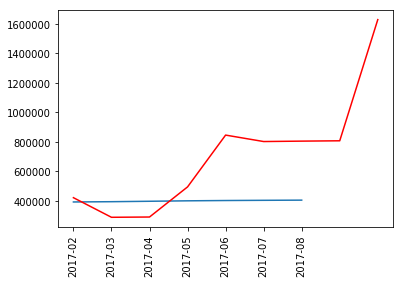

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([72055.97543088]), array([414.85012725]), array([[71242.88412248, 72869.06673928]]))
predictions: [array([143655.97543088])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.9592928747317334
stationary fit: 2, p: 3.7573184051446916e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 3.267472641750304e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([48858.6390236]), array([30744.78522437]), array([[-11400.03272858, 109117.31077578]]))
predictions: [array([143655.97543088]), array([120158.6390236])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.7106401329591975e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 2.30481982431426e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([119342.20852765]), array([30786.08753348]), array([[ 59002.58573713, 179681.83131817]]))
predictions: [array([143655.97543088]), array([120158.6390236]), array([510392.20852765])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.5706889018766294e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 4.1207258994422916e-21


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([-21183.59809356]), array([30847.68906561]), array([[-81643.95766844,  39276.76148131]]))
predictions: [array([143655.97543088]), array([120158.6390236]), array([510392.20852765]), array([371716.40190644])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 1.4441404250456362e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(array([72141.04734645]), array([20107.77695429]), array([[ 32730.52870689, 111551.56598602]]))
predictions: [array([143655.97543088]), array([120158.6390236]), array([510392.20852765]), array([371716.40190644]), array([470991.04734645])]
standard fit used
(array([385637.03651216]), array([20118.50369804]), array([[346205.49384116, 425068.57918317]]))
predictions: [array([143655.97543088]), array([120158.6390236]), array([510392.20852765]), array([371716.40190644]), array([470991.04734645]), array([786487.03651216])]
standard fit used
(array([392134.82660911]), array([20082.24578319]), array([[352774.34814538, 431495.30507284]]))
predictions: [array([143655.97543088]), array([120158.6390236]), array([510392.20852765]), array([371716.40190644]), array([470991.04734645]), array([786487.03651216]), array([794384.82660911])]
standard fit used
(array([395231.17860446]), array([20043.92340038]), array([[355945.81063083, 434516.54657809]]))
predictions: [array([143655.97543088]), array([12015

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


standard fit used
(array([800475.85513184]), array([31832.19119991]), array([[738085.90683103, 862865.80343265]]))
predictions: [array([143655.97543088]), array([120158.6390236]), array([510392.20852765]), array([371716.40190644]), array([470991.04734645]), array([786487.03651216]), array([794384.82660911]), array([798631.17860446]), array([1599107.0337363])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: [nan]
stationary fit: 1, p: [0.8960784]
stationary fit: 2, p: [0.79087638]
stationary fit: 3, p: [0.99068735]
stationary fit: 4, p: [0.81433951]
stationary fit: 5, p: 1.0
stationary fit: 6, p: 1.0
stationary fit: 7, p: 1.0
stationary fit: 8, p: 1.0
stationary fit: 9, p: 1.0


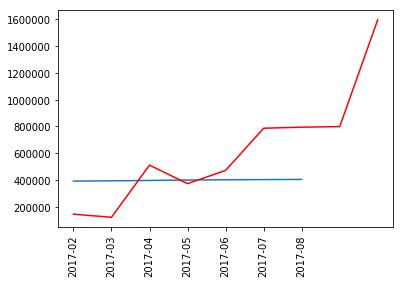

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


standard fit used
(array([141250.21857573]), array([525.85664283]), array([[140219.55849476, 142280.87865671]]))
predictions: [array([281750.21857573])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 0.981214094301854
stationary fit: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
original error: SVD did not converge
stationary fit: 3, p: 4.264648474239591e-17
bad condition 3: stationarity not adequate
original error: SVD did not converge
stationary fit: 4, p: 8.693667136952019e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
original error: SVD did not converge
stationary fit: 5, p: 8.60893457287362e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([63470.74634731]), array([25812.92662599]), array([[ 12878.33982481, 114063.15286982]]))
predictions: [array([281750.21857573]), array([201970.74634731])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.251346310545308e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 1.2287253539834476e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([177398.50972345]), array([25669.59593835]), array([[127087.02618659, 227709.99326032]]))
predictions: [array([281750.21857573]), array([201970.74634731]), array([568448.50972345])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: nan
stationary fit: 1, p: 2.064837437292879e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
original error: SVD did not converge
stationary fit: 2, p: 4.321861290585701e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(array([-15508.2110613]), array([25791.17315103]), array([[-66057.98155635,  35041.55943376]]))
predictions: [array([281750.21857573]), array([201970.74634731]), array([568448.50972345]), array([377391.7889387])]
standard fit used
(array([423595.42282659]), array([15842.31427925]), array([[392545.05740749, 454645.78824569]]))
predictions: [array([281750.21857573]), array([201970.74634731]), array([568448.50972345]), array([377391.7889387]), array([822445.42282659])]
standard fit used
(array([396148.60650172]), array([15816.83924814]), array([[365148.1712261 , 427149.04177734]]))
predictions: [array([281750.21857573]), array([201970.74634731]), array([568448.50972345]), array([377391.7889387]), array([822445.42282659]), array([796998.60650172])]
standard fit used
(array([398087.05682057]), array([15785.48099937]), array([[367148.08258316, 429026.03105799]]))
predictions: [array([281750.21857573]), array([201970.74634731]), array([568448.50972345]), array([377391.7889387]), array([822445

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


standard fit used
(array([808180.44629428]), array([29549.04055622]), array([[750265.39102638, 866095.50156218]]))
predictions: [array([281750.21857573]), array([201970.74634731]), array([568448.50972345]), array([377391.7889387]), array([822445.42282659]), array([796998.60650172]), array([800337.05682057]), array([802970.59213094]), array([1611151.03842522])]
stationary differences will be used
original error: SVD did not converge
stationary fit: 0, p: [nan]
stationary fit: 1, p: [0.99012352]
stationary fit: 2, p: [0.95970077]
stationary fit: 3, p: [0.99095756]
stationary fit: 4, p: 1.0
stationary fit: 5, p: 1.0
stationary fit: 6, p: 1.0
stationary fit: 7, p: 1.0
stationary fit: 8, p: 1.0
stationary fit: 9, p: 1.0


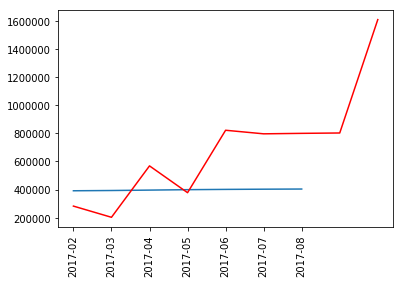

In [23]:
# best 3 models
for model in sorted_results[:3]:
    # get data
    zipcode = model['zipcode']
    data_zipcode = df_zipcode_clean[[zipcode]]
    iterations = (12-len(df_test)) + 18
    data_train = data_zipcode.T[date_columns].T
    
    # compute_arima
    predictions = compute_arima(data_train.ix[:,0], iterations=iterations, p=5)

    # plot predictions
    rolling_plot(df_test, predictions)